In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot

sns.set()

In [2]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



(array([1.2800e+02, 2.9120e+03, 1.6838e+04, 3.3453e+04, 2.9129e+04,
        1.3191e+04, 3.6070e+03, 6.4000e+02, 9.7000e+01, 5.0000e+00]),
 array([1.18727727, 1.34977247, 1.51226767, 1.67476287, 1.83725807,
        1.99975327, 2.16224847, 2.32474367, 2.48723887, 2.64973407,
        2.81222927]),
 <a list of 10 Patch objects>)

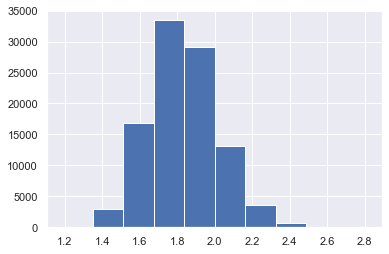

In [3]:
r_prior = pm.rlognormal(0.6, 1 / 0.1 ** 2,100000)
f_prior = pm.rbeta(5,200,100000)

plt.hist(r_prior)

In [4]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
   
    alpha=10

    #f_alpha = 5
    #f_beta = 100
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    r_mu = pm.Uniform('r_mu',0.05,0.6)
    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([r_mu, r_sigma,f_alpha,f_beta,f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(500000,100000,4)

    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')
    
    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [5]:
def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])

    samples.shape

    sample_df = pd.DataFrame(samples,index=range(len(samples)))
    sample_df.index.name='day'
    sample_df.columns.name='sample_nr'
    return sample_df

In [6]:

def plot(result,df,sample_df,country_name):
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    samples_daily_mean = sample_df.mean(axis=1)

    
    plt.figure(figsize=(18,12))
    title_postfix = r' Sample posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Week Actual: {}'.format(
        samples_89[0],samples_89[1],df.iloc[-1,2])


    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['lime'])
    plt.plot(range(len(df)),samples_daily_mean,color='crimson',ls='dashed',label='death samples weekly mean ')


    plt.title('Bayesian Posterior Expected number of deaths per week {}, after the day CONFIRMED hit {} \n'.format(
        country_name.upper(),limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of deaths per week')
    plt.xlabel('Week after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df['dead_inc'],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot_weekly.jpg'.format(country_name),format='jpg')
    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ Sweden +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-20   1278.666667   678.0      14.0     8.833333
2020-03-27   2352.000000  1430.0      89.0    49.428571
2020-04-03   4608.000000  3062.0     253.0   206.571429
2020-04-10   7916.714286  3554.0     512.0   598.857143
2020-04-17  11530.000000  3531.0     530.0  1096.285714
2020-04-24  15518.857143  4351.0     752.0  1786.571429
2020-05-01  19754.000000  3953.0     501.0  2388.000000
2020-05-08  23448.857143  3745.0     522.0  2875.285714
2020-05-15  27411.857143  3942.0     471.0  3378.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 705.0 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ Sweden ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.381675       0.024110        40.926518
std      

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ US +++++++++++++
               confirmed       inc  dead_inc      deceased
2020-03-13  1.707667e+03    1220.0      21.0     42.000000
2020-03-20  8.297429e+03   17094.0     300.0    162.000000
2020-03-27  5.824657e+04   82384.0    1916.0   1161.285714
2020-04-03  1.920869e+05  173710.0    6981.0   5625.428571
2020-04-10  3.995513e+05  221168.0   13087.0  16310.428571
2020-04-17  6.105209e+05  203171.0   15078.0  30504.571429
2020-04-24  8.145823e+05  205652.0   14082.0  45296.000000
2020-05-01  1.016787e+06  198103.0   13450.0  58873.714286
2020-05-08  1.206513e+06  180468.0   12237.0  71476.285714
2020-05-15  1.372439e+06  158895.0   10350.0  82700.857143
 [-----------------100%-----------------] 500000 of 500000 complete in 618.9 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ US ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.00000

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ India +++++++++++++
               confirmed      inc  dead_inc     deceased
2020-04-03   1796.666667   1580.0      48.0    49.333333
2020-04-10   5285.428571   5031.0     174.0   160.142857
2020-04-17  11385.000000   6754.0     240.0   387.000000
2020-04-24  20133.285714  10178.0     294.0   642.714286
2020-05-01  31447.142857  12727.0     443.0  1015.571429
2020-05-08  49582.000000  22438.0     762.0  1661.714286
2020-05-15  74409.285714  26089.0     768.0  2425.000000
cant fit India
 [-----------------100%-----------------] 500000 of 500000 complete in 662.9 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ India ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.336401       0.010961        25.274370
std         0.273475       0.002193         0.483163
min         0.661269       0.005157        23.147330
25%         1.134348       0.009311        24.947532
50%         1.294867       0.010863        25.272452
75%         1.511144       0.012401        25.597910
max         2.691370       0.021149        27.321998



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Italy +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-06    2706.142857   3748.0     176.0     92.285714
2020-03-13   10737.571429  13024.0    1069.0    659.000000
2020-03-20   32737.000000  29361.0    2766.0   2618.000000
2020-03-27   69613.142857  39477.0    5102.0   6864.285714
2020-04-03  106190.714286  33329.0    5547.0  12367.428571
2020-04-10  136048.285714  27750.0    4168.0  17099.428571
2020-04-17  162452.571429  24857.0    3896.0  21065.571429
2020-04-24  184339.428571  20560.0    3224.0  24607.428571
2020-05-01  201489.571429  14434.0    2267.0  27321.285714
2020-05-08  213213.714286   9757.0    1965.0  29404.428571
2020-05-15  221064.714286   6700.0    1409.0  30955.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 694.1 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Italy ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.270436       0.019206        63.766901
std         0.241758       0.003555         0.356905
min         0.763319       0.010221        61.963074
25%         1.090894       0.016582        63.526674
50%         1.240204       0.018999        63.766585
75%         1.420969       0.021604        64.006854
max         2.319414       0.031110        65.425305



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Spain +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-13    2510.800000   4559.0     116.0     61.000000
2020-03-20   12594.571429  15178.0     910.0    550.714286
2020-03-27   43169.000000  45309.0    4095.0   3059.428571
2020-04-03   96086.571429  53480.0    6060.0   8556.857143
2020-04-10  142306.571429  39074.0    4883.0  14042.000000
2020-04-17  175132.714286  32566.0    3921.0  18236.000000
2020-04-24  202741.571429  12151.0    2522.0  21289.714286
2020-05-01  210763.571429  12226.0    2019.0  23828.000000
2020-05-08  219431.000000   7641.0    1756.0  25661.571429
2020-05-15  227401.142857   7326.0    1160.0  26949.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 626.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Spain ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.347382       0.015841        51.708712
std         0.256349       0.002984         0.311411
min         0.780775       0.008866        50.315748
25%         1.159197       0.013544        51.498057
50%         1.309124       0.015734        51.707710
75%         1.520814       0.017775        51.920242
max         2.318571       0.026433        53.262930



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Korea, South +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-02-28   1788.000000  1360.0       3.0   12.666667
2020-03-06   4958.428571  4256.0      29.0   28.714286
2020-03-13   7564.142857  1386.0      24.0   56.142857
2020-03-20   8347.714286   673.0      28.0   81.714286
2020-03-27   9066.857143   680.0      45.0  120.000000
2020-04-03   9776.142857   730.0      35.0  160.571429
2020-04-10  10323.571429   388.0      34.0  192.857143
2020-04-17  10561.714286   185.0      22.0  221.142857
2020-04-24  10684.428571    83.0      10.0  236.714286
2020-05-01  10756.857143    62.0      10.0  245.714286
2020-05-08  10810.857143    60.0       6.0  254.142857
2020-05-15  10961.000000   197.0       6.0  258.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 765.7 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Korea, South ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.344290       0.001853         4.289095
std         0.263310       0.000382         0.269651
min         0.537954       0.000715         3.220011
25%         1.145661       0.001570         4.103382
50%         1.311028       0.001824         4.283488
75%         1.519507       0.002097         4.466365
max         3.205188       0.004686         5.641511



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Netherlands +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-20   1965.500000  2041.0      95.0    54.833333
2020-03-27   5822.000000  5644.0     440.0   306.714286
2020-04-03  12791.142857  7174.0     943.0  1046.142857
2020-04-10  19878.428571  7428.0    1030.0  2083.857143
2020-04-17  27560.714286  7370.0     951.0  3018.714286
2020-04-24  34313.000000  6110.0     833.0  3938.142857
2020-05-01  38710.714286  3260.0     605.0  4639.714286
2020-05-08  41320.000000  2303.0     468.0  5180.285714
2020-05-15  43221.000000  1588.0     285.0  5536.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 764.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.334870       0.019489        49.223840
std         0.261352       0.003842         0.656486
min         0.579707       0.009208        46.456961
25%         1.138324       0.016609        48.781470
50%         1.304700       0.019192        49.221038
75%         1.508776       0.022007        49.665507
max         2.774603       0.042836        52.006870



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Canada +++++++++++++
               confirmed      inc  dead_inc     deceased
2020-03-27   2799.857143   3739.0      42.0    30.428571
2020-04-03   8723.142857   7755.0     125.0   104.714286
2020-04-10  17860.428571   9622.0     378.0   379.714286
2020-04-17  27451.714286  10755.0     799.0   953.285714
2020-04-24  39561.428571  12105.0    1046.0  1903.428571
2020-05-01  51262.142857  11424.0    1135.0  3012.000000
2020-05-08  63167.285714  11331.0    1160.0  4182.285714
2020-05-15  72428.571429   8285.0     982.0  5275.000000
 [-----------------100%-----------------] 500000 of 500000 complete in 669.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Canada ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.357871       0.015311        56.009235
std         0.266640       0.003022         0.740656
min         0.583723       0.008319        53.026720
25%         1.150868       0.012952        55.506862
50%         1.325746       0.015091        56.003269
75%         1.544202       0.017394        56.507959
max         2.420600       0.033933        59.119259



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Germany +++++++++++++
                confirmed      inc  dead_inc     deceased
2020-03-13    1889.000000   2876.0       7.0     2.833333
2020-03-20   10629.142857  16173.0      60.0    28.571429
2020-03-27   34465.714286  31023.0     275.0   181.857143
2020-04-03   73186.857143  40288.0     933.0   812.571429
2020-04-10  108700.000000  31012.0    1492.0  2082.428571
2020-04-17  132577.285714  19226.0    1585.0  3493.428571
2020-04-24  148951.142857  13602.0    1408.0  5079.142857
2020-05-01  160225.428571   9078.0     976.0  6302.714286
2020-05-08  167424.285714   6511.0     774.0  7120.142857
2020-05-15  173251.285714   4645.0     387.0  7737.000000
 [-----------------100%-----------------] 500000 of 500000 complete in 660.2 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.387757       0.005838        14.752384
std         0.271922       0.001109         0.165957
min         0.792768       0.002615        14.053171
25%         1.179498       0.004981        14.639949
50%         1.354708       0.005766        14.751165
75%         1.567646       0.006620        14.864292
max         2.994603       0.009877        15.536728



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Netherlands +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-20   1965.500000  2041.0      95.0    54.833333
2020-03-27   5822.000000  5644.0     440.0   306.714286
2020-04-03  12791.142857  7174.0     943.0  1046.142857
2020-04-10  19878.428571  7428.0    1030.0  2083.857143
2020-04-17  27560.714286  7370.0     951.0  3018.714286
2020-04-24  34313.000000  6110.0     833.0  3938.142857
2020-05-01  38710.714286  3260.0     605.0  4639.714286
2020-05-08  41320.000000  2303.0     468.0  5180.285714
2020-05-15  43221.000000  1588.0     285.0  5536.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 597.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.345614       0.019310        49.229010
std         0.260575       0.003681         0.654305
min         0.725392       0.009923        46.565807
25%         1.143350       0.016382        48.786744
50%         1.306159       0.019181        49.225406
75%         1.528739       0.021925        49.670780
max         2.552663       0.034071        51.919164



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ United Kingdom +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-20    2167.428571   3212.0     185.0     98.428571
2020-03-27    8842.714286  10731.0     968.0    591.857143
2020-04-03   26821.857143  23944.0    3304.0   2703.285714
2020-04-10   57298.857143  35916.0    6309.0   7706.857143
2020-04-17   94698.857143  35164.0    6134.0  14126.428571
2020-04-24  130148.285714  34871.0    5943.0  20245.000000
2020-05-01  163130.142857  34045.0    4730.0  25461.714286
2020-05-08  197483.142857  33944.0    3733.0  29598.571429
2020-05-15  227496.571429  25375.0    2762.0  32791.000000
 [-----------------100%-----------------] 500000 of 500000 complete in 602.4 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ United Kingdom ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.377094       0.028174        81.298216
std         0.262909       0.005014         0.440901
min         0.847162       0.015287        79.567493
25%         1.184699       0.024708        81.000797
50%         1.332469       0.028152        81.296771
75%         1.518864       0.031658        81.595342
max         2.439282       0.044537        83.208326



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ France +++++++++++++
                confirmed      inc  dead_inc      deceased
2020-03-13    2069.333333   2722.0      68.0     41.000000
2020-03-20    8039.714286   9077.0     372.0    189.142857
2020-03-27   23143.428571  20644.0    1546.0   1175.857143
2020-04-03   51384.285714  31800.0    4523.0   3974.571429
2020-04-10   79654.142857  26536.0    6695.0  10180.857143
2020-04-17  128582.571429  56346.0    5468.0  16107.714286
2020-04-24  155556.142857  11868.0    3565.0  20794.000000
2020-05-01  165718.142857   7353.0    2349.0  23643.000000
2020-05-08  171865.285714   8897.0    1636.0  25491.285714
2020-05-15  178082.857143   3428.0    1299.0  26910.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 603.1 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ France ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.388613       0.021352        59.065411
std         0.271683       0.004168         0.354722
min         0.817465       0.012194        57.618543
25%         1.181969       0.018076        58.825491
50%         1.361847       0.020966        59.064851
75%         1.579452       0.024160        59.302982
max         2.349228       0.034545        60.571414



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Belgium +++++++++++++
               confirmed     inc  dead_inc     deceased
2020-03-20   1567.800000  1371.0      33.0    17.400000
2020-03-27   4669.142857  5027.0     252.0   148.428571
2020-04-03  12960.857143  9486.0     854.0   712.000000
2020-04-10  22311.857143  9897.0    1876.0  2025.571429
2020-04-17  31984.714286  9471.0    2144.0  4209.428571
2020-04-24  40799.571429  8155.0    1516.0  6056.142857
2020-05-01  47270.000000  4739.0    1024.0  7335.285714
2020-05-08  50630.142857  2979.0     818.0  8117.714286
2020-05-15  53688.285714  2633.0     438.0  8772.857143
 [-----------------100%-----------------] 500000 of 500000 complete in 649.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Belgium ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.361016       0.025717        52.780237
std         0.272650       0.005004         0.558371
min         0.666281       0.013101        50.245577
25%         1.158620       0.021924        52.403611
50%         1.316947       0.025578        52.777342
75%         1.535635       0.029065        53.155450
max         2.600754       0.050748        55.361139



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Austria +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-03-20   1679.400000  1528.0       5.0    4.400000
2020-03-27   5186.714286  5269.0      52.0   30.000000
2020-04-03  10031.571429  3867.0     110.0  123.142857
2020-04-10  12644.142857  2031.0     151.0  248.571429
2020-04-17  14203.571429  1040.0     112.0  381.857143
2020-04-24  14869.428571   476.0      99.0  488.285714
2020-05-01  15341.285714   460.0      59.0  564.142857
2020-05-08  15662.285714   243.0      25.0  604.428571
2020-05-15  15958.714286   335.0      14.0  622.000000
 [-----------------100%-----------------] 500000 of 500000 complete in 626.7 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Austria ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.352643       0.004571         9.988482
std         0.268395       0.000921         0.400066
min         0.580426       0.002094         8.373589
25%         1.151182       0.003877         9.716694
50%         1.317018       0.004514         9.984186
75%         1.531086       0.005169        10.254468
max         2.792451       0.010477        11.931643



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Norway +++++++++++++
              confirmed     inc  dead_inc    deceased
2020-03-20  1473.857143   918.0       7.0    4.571429
2020-03-27  2885.000000  1841.0      12.0   11.857143
2020-04-03  4680.714286  1615.0      40.0   38.857143
2020-04-10  5971.285714   944.0      54.0   88.571429
2020-04-17  6676.142857   623.0      48.0  140.428571
2020-04-24  7237.571429   526.0      38.0  181.714286
2020-05-01  7645.142857   320.0      11.0  205.714286
2020-05-08  7945.000000   287.0       8.0  214.571429
2020-05-15  8154.714286   149.0      14.0  226.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 625.4 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Norway ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.343604       0.003420         6.521262
std         0.263263       0.000700         0.427637
min         0.570015       0.001306         4.688357
25%         1.144042       0.002900         6.227595
50%         1.305888       0.003374         6.512092
75%         1.517726       0.003874         6.804115
max         3.511558       0.007854         8.517733



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Denmark +++++++++++++
               confirmed     inc  dead_inc    deceased
2020-03-20   1175.750000   404.0       6.0    5.750000
2020-03-27   1758.428571   863.0      43.0   29.857143
2020-04-03   3076.142857  1746.0      87.0   95.714286
2020-04-10   5201.714286  2068.0     108.0  204.571429
2020-04-17   6713.857143  1254.0      89.0  297.571429
2020-04-24   7915.142857  1140.0      67.0  373.714286
2020-05-01   9061.714286  1101.0      57.0  436.571429
2020-05-08  10006.571429   907.0      62.0  499.571429
2020-05-15  10772.714286   573.0      15.0  531.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 590.5 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Denmark ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.336119       0.007478        11.297032
std         0.266220       0.001501         0.486331
min         0.615656       0.003310         9.336346
25%         1.136854       0.006348        10.965686
50%         1.296733       0.007406        11.291962
75%         1.509321       0.008462        11.617927
max         3.018982       0.016369        13.404613



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Finland +++++++++++++
              confirmed     inc  dead_inc    deceased
2020-03-27  1041.000000    83.0       2.0    7.000000
2020-04-03  1393.714286   574.0      13.0   15.142857
2020-04-10  2307.714286  1154.0      28.0   34.857143
2020-04-17  3171.285714   720.0      34.0   65.285714
2020-04-24  4022.000000   906.0      95.0  131.571429
2020-05-01  4776.857143   656.0      41.0  200.428571
2020-05-08  5450.428571   687.0      42.0  243.285714
2020-05-15  6036.571429   490.0      33.0  277.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 584.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Finland ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.344977       0.007918        10.674028
std         0.265874       0.001610         0.626489
min         0.594114       0.003607         8.207561
25%         1.143941       0.006702        10.243595
50%         1.305865       0.007827        10.659214
75%         1.520556       0.008978        11.089145
max         2.718504       0.017450        13.768010



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


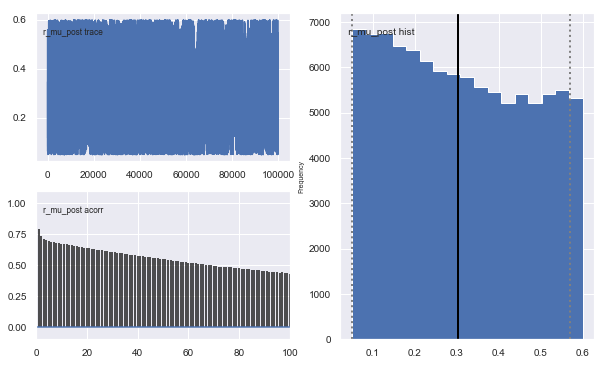

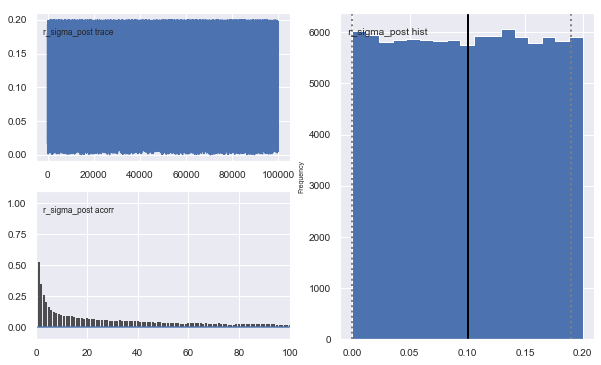

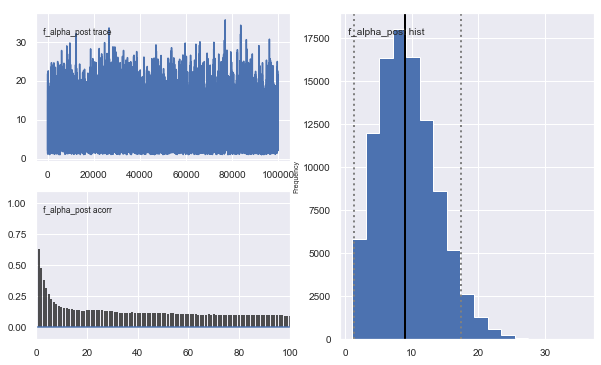

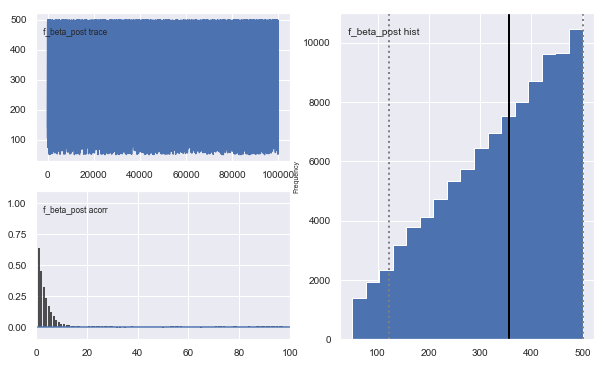

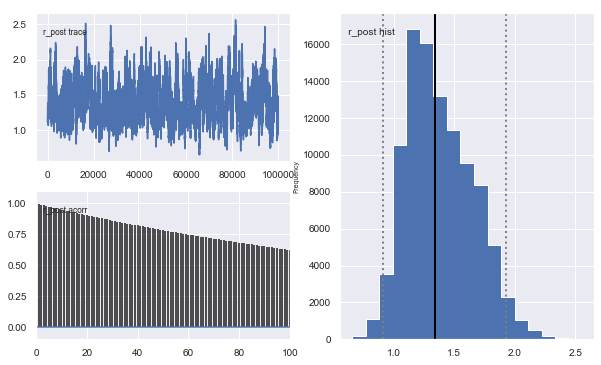

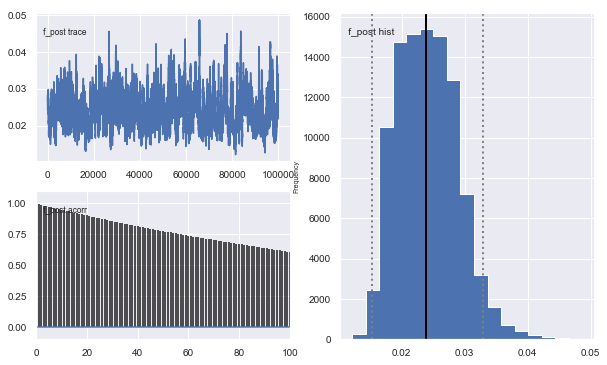

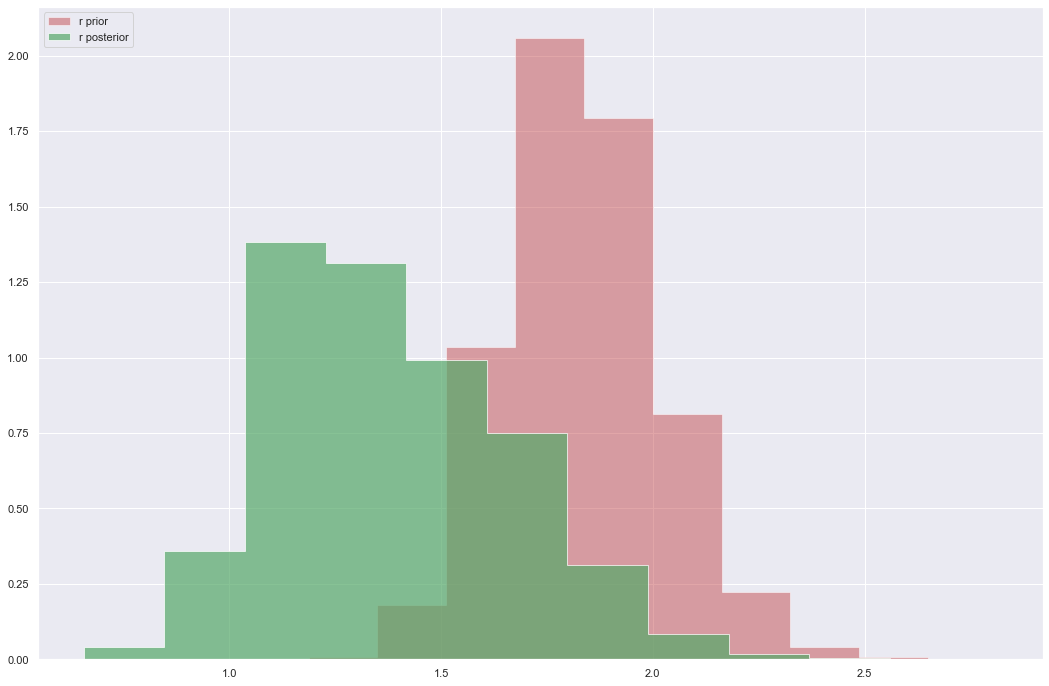

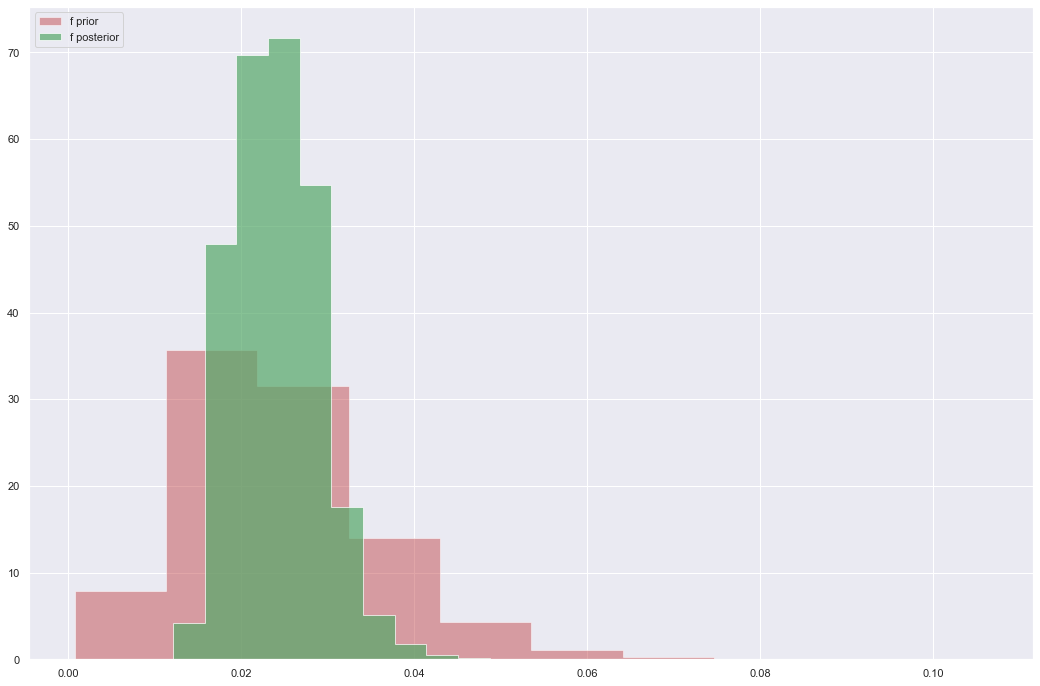

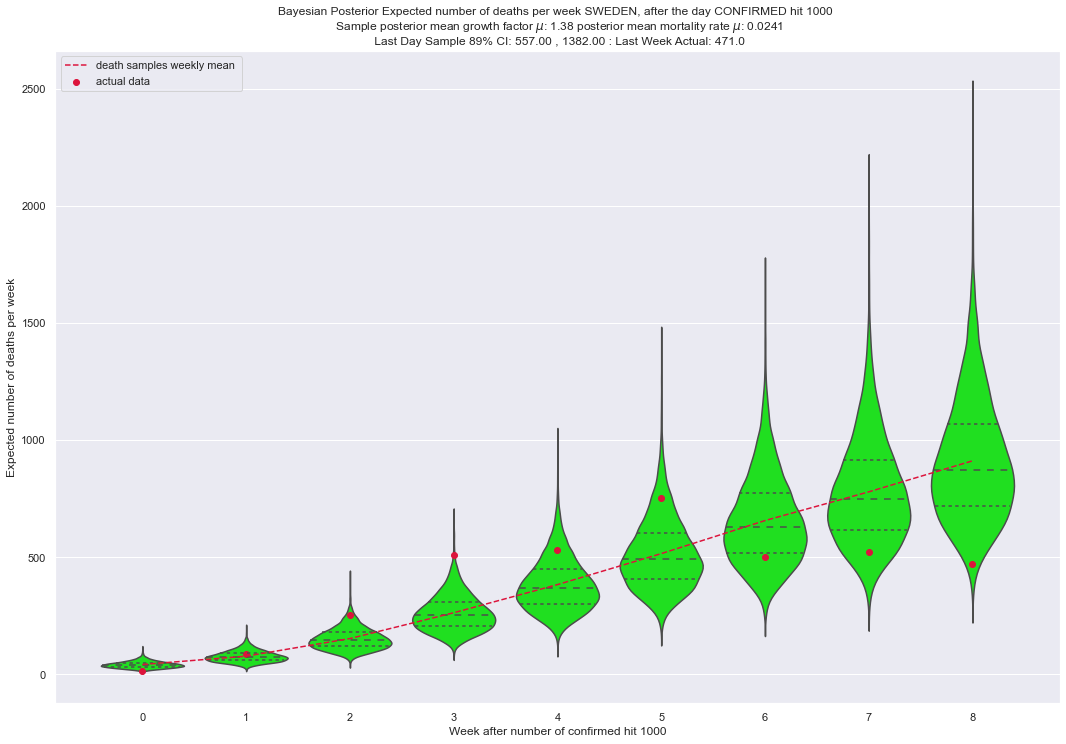

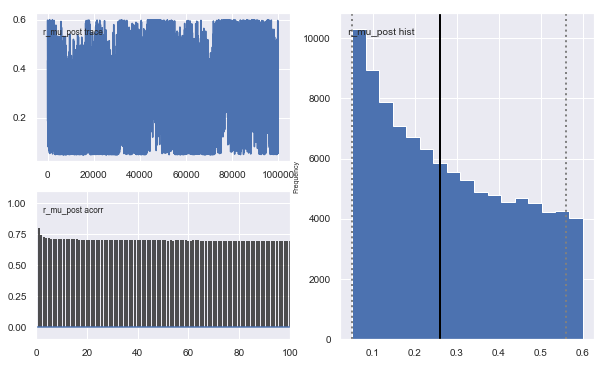

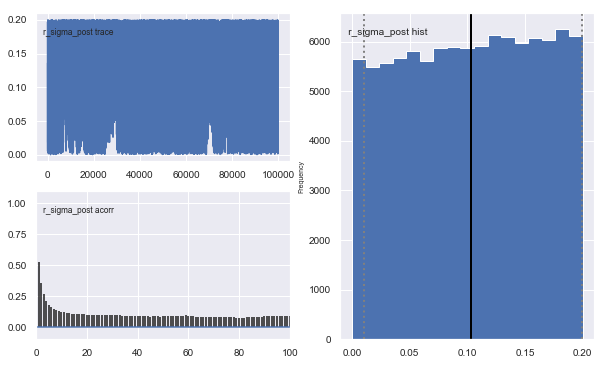

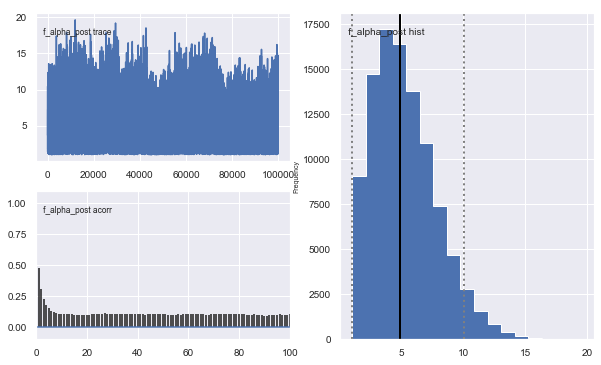

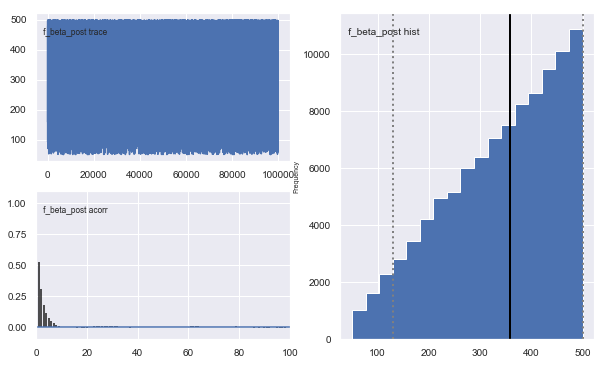

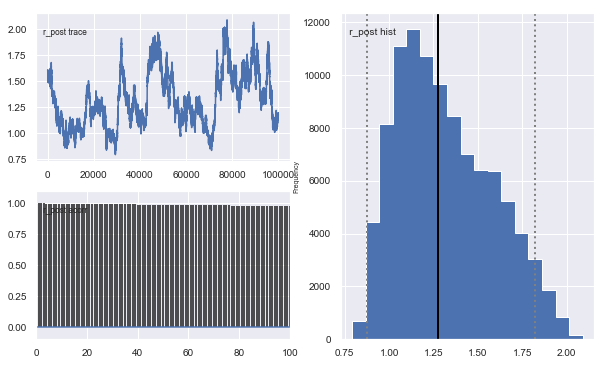

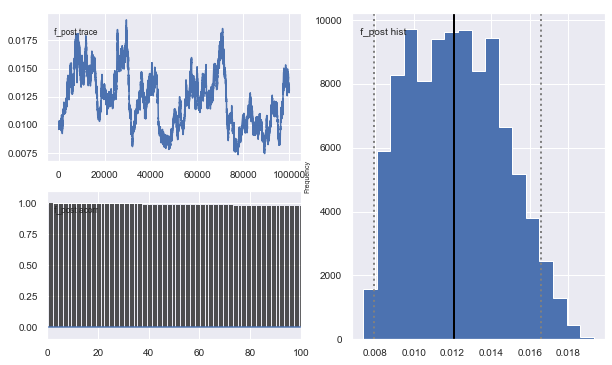

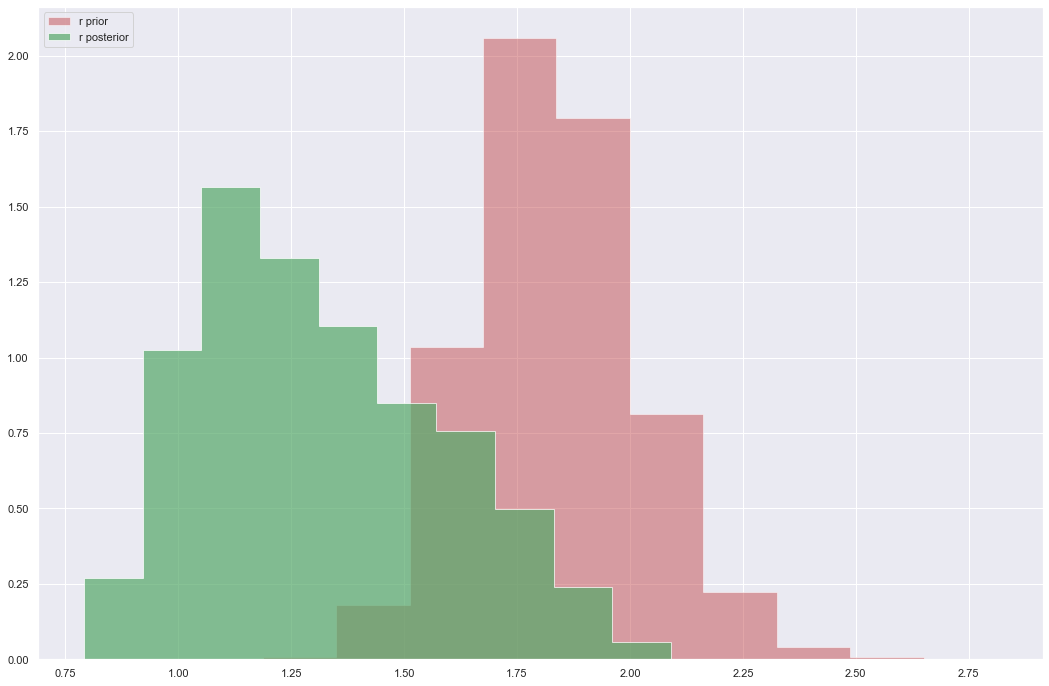

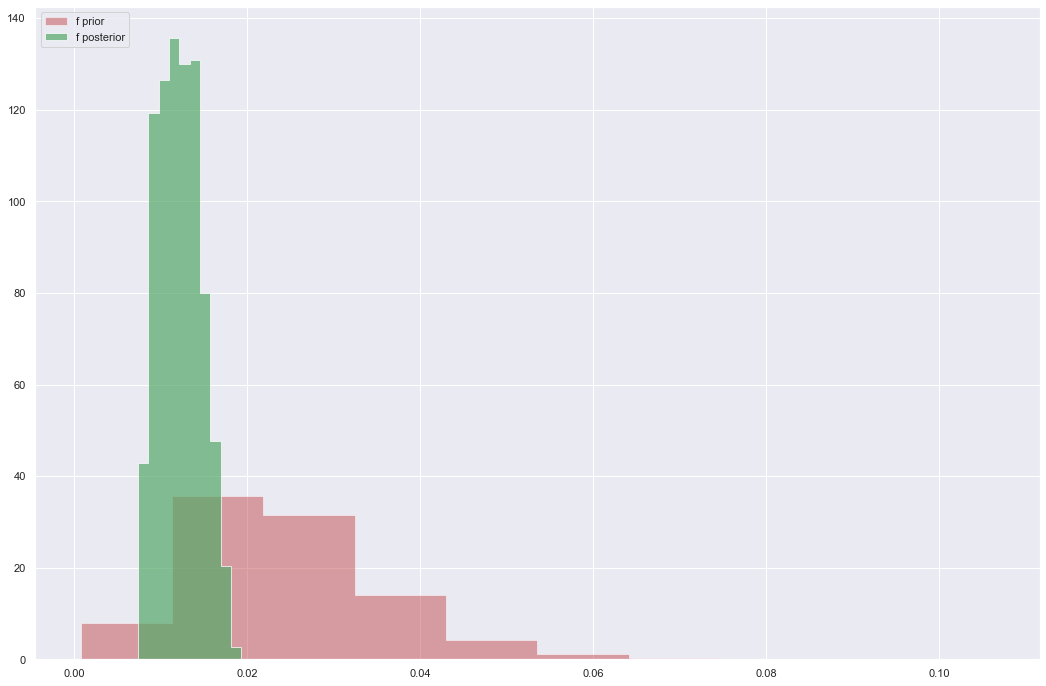

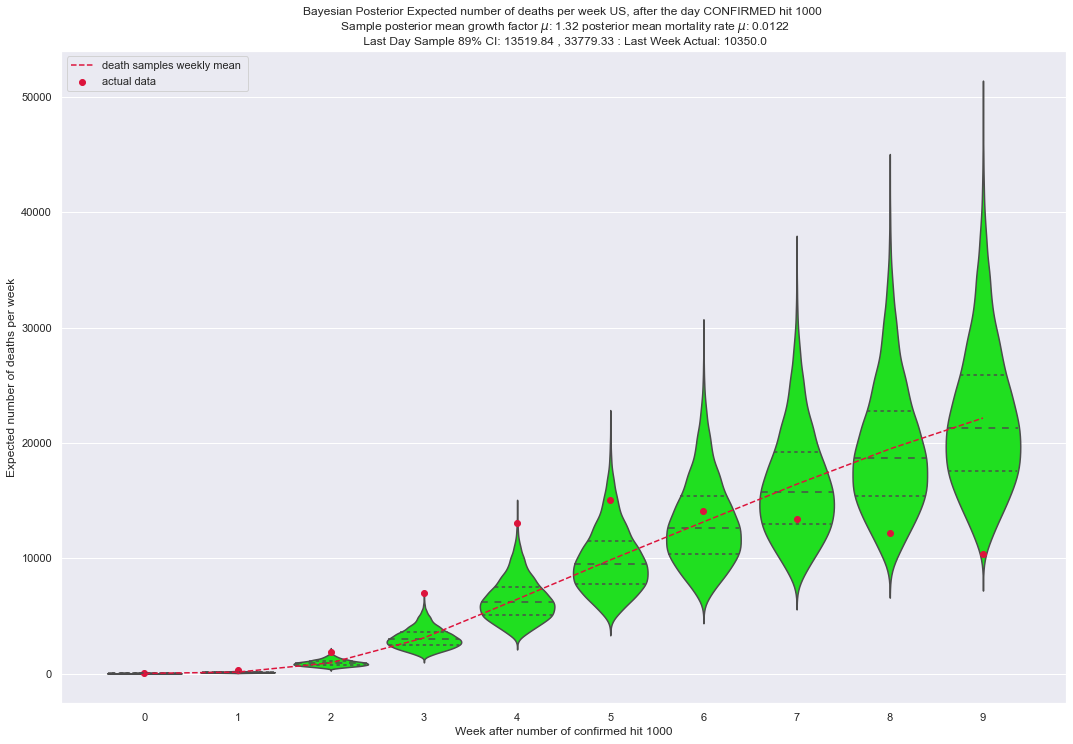

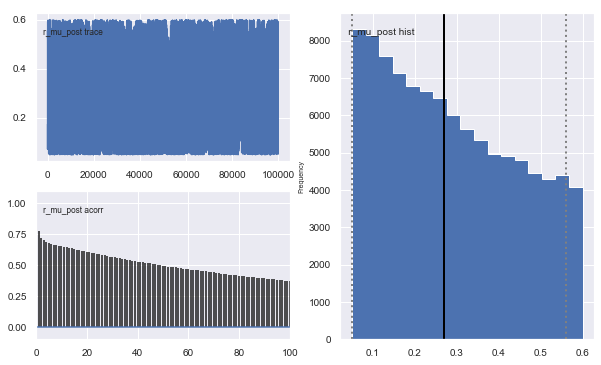

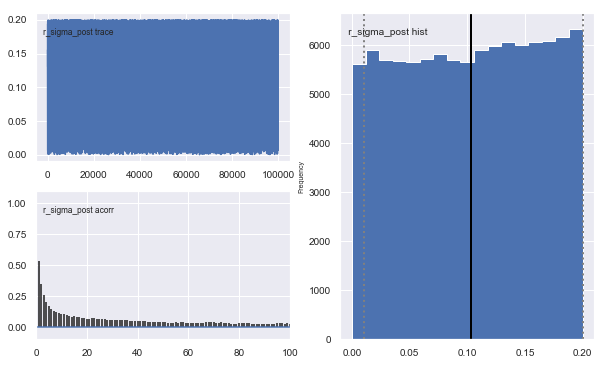

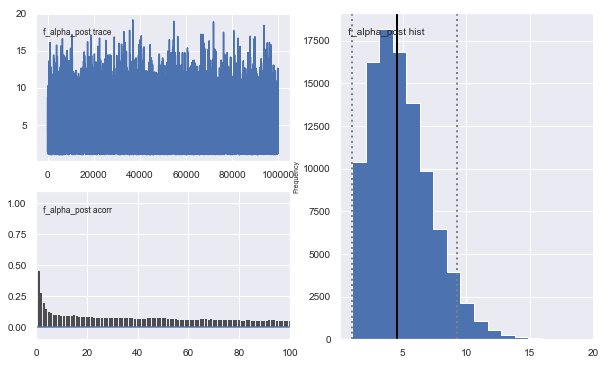

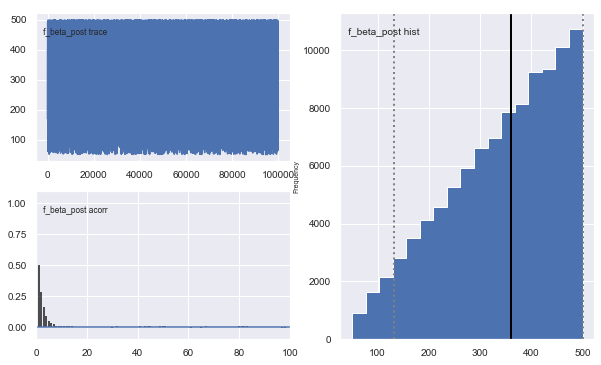

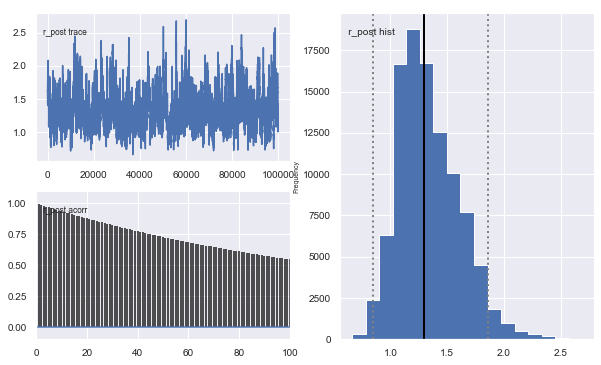

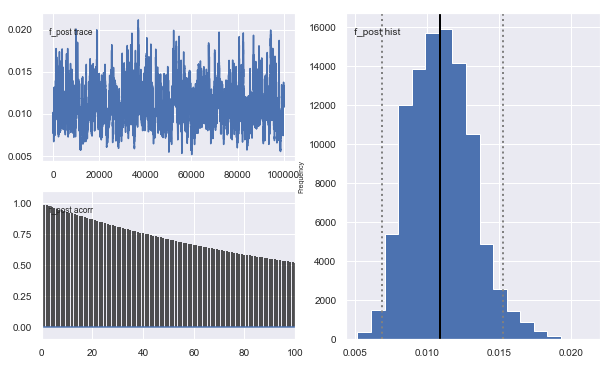

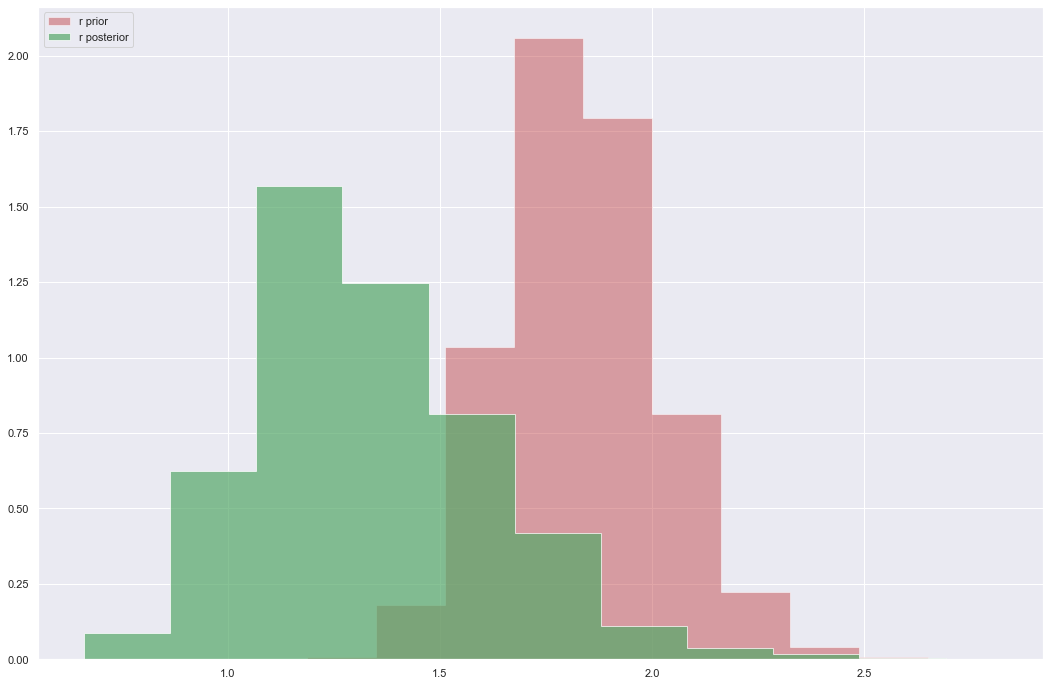

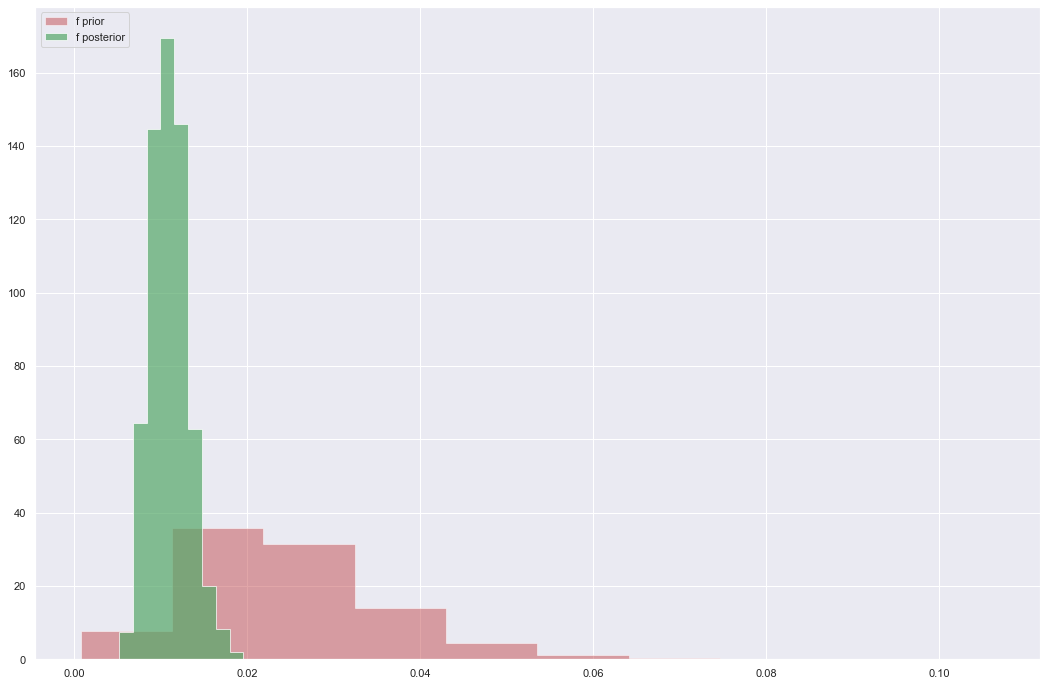

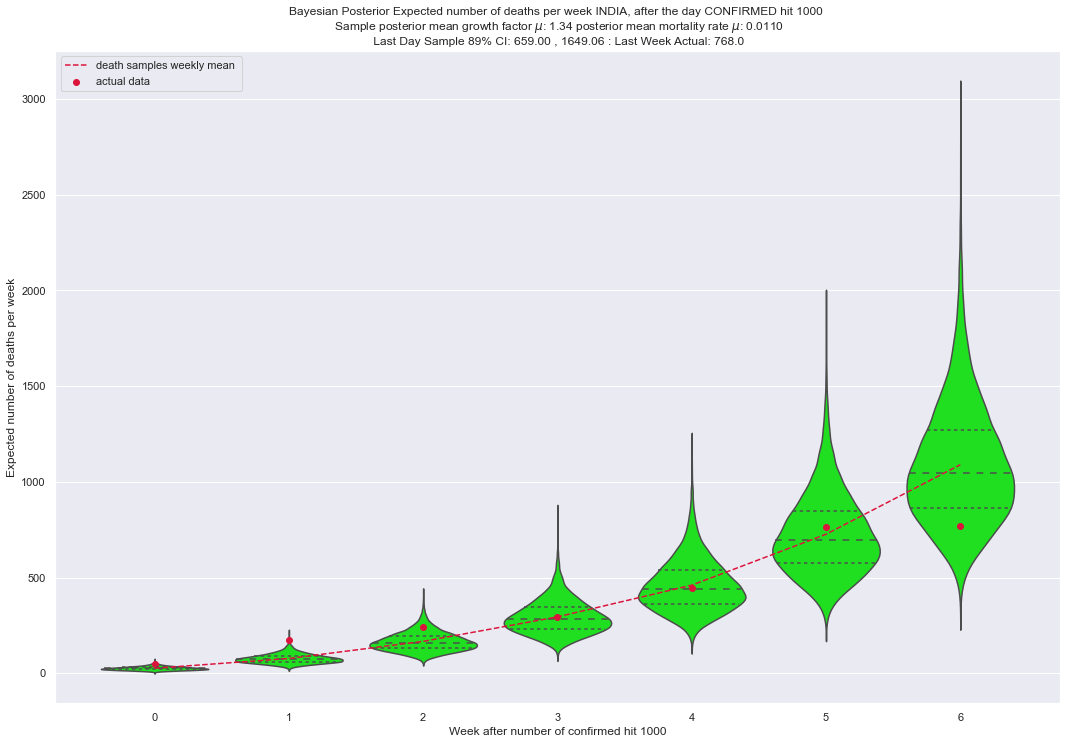

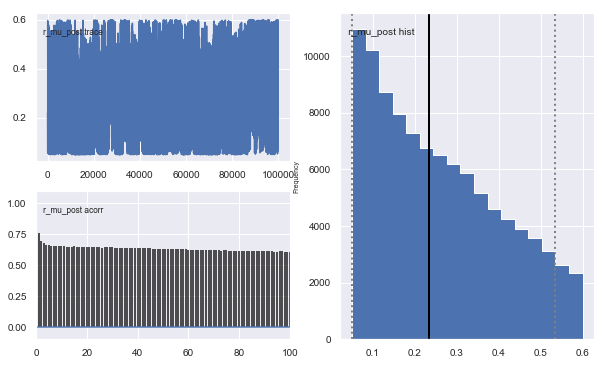

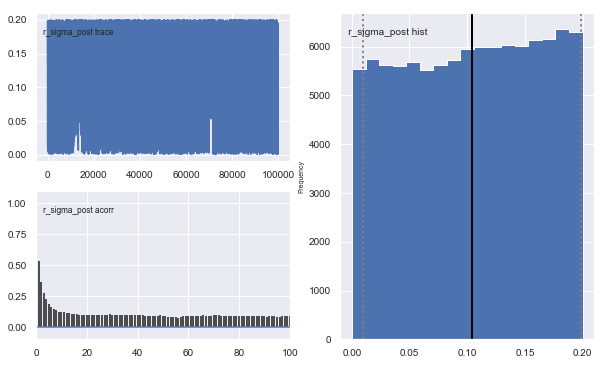

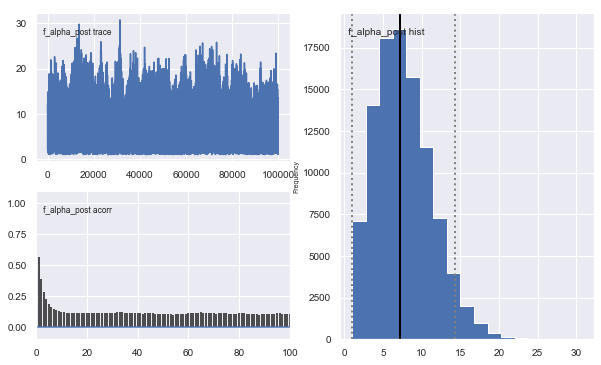

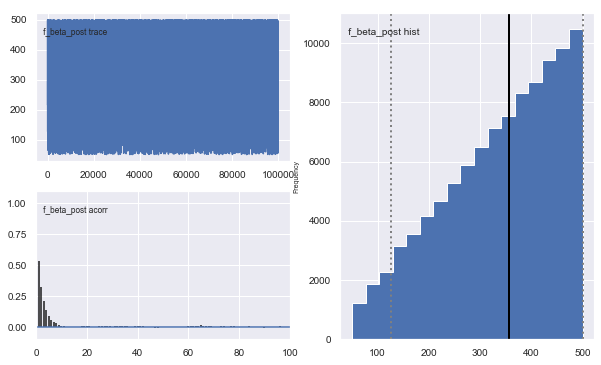

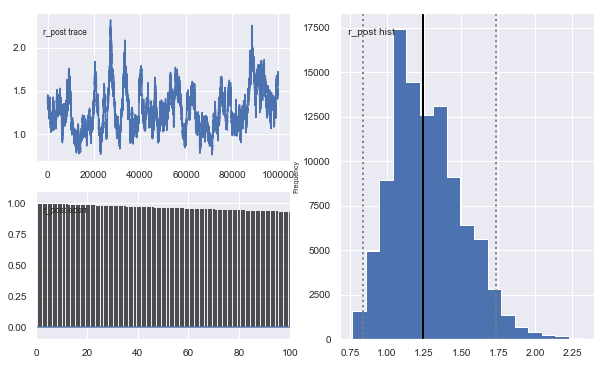

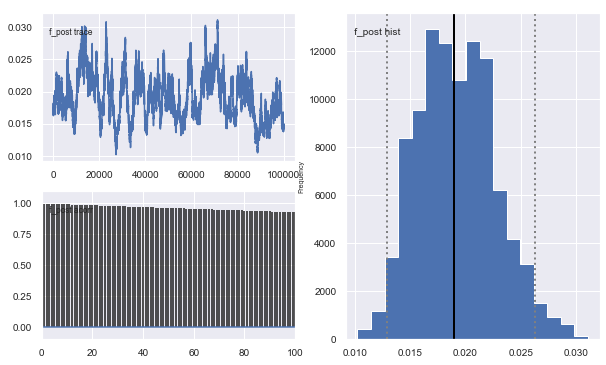

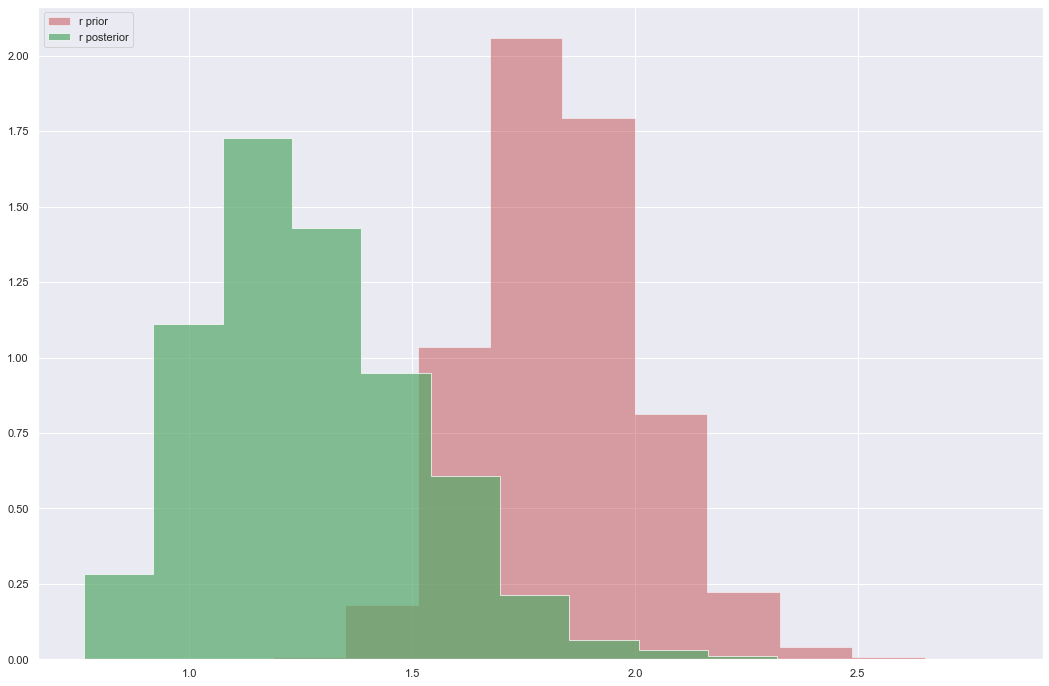

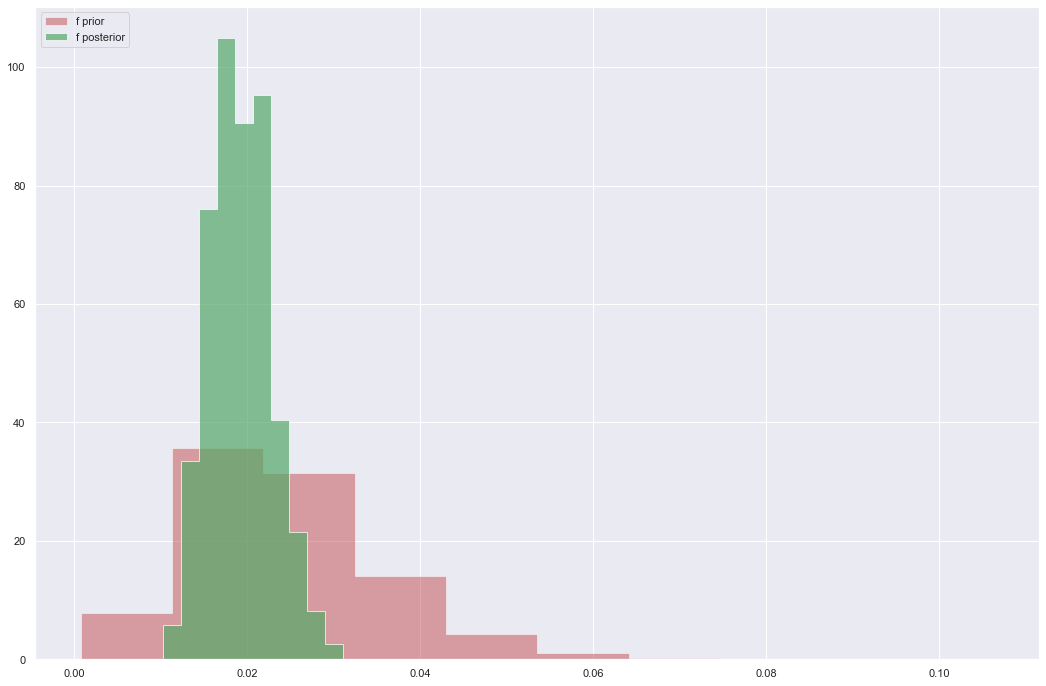

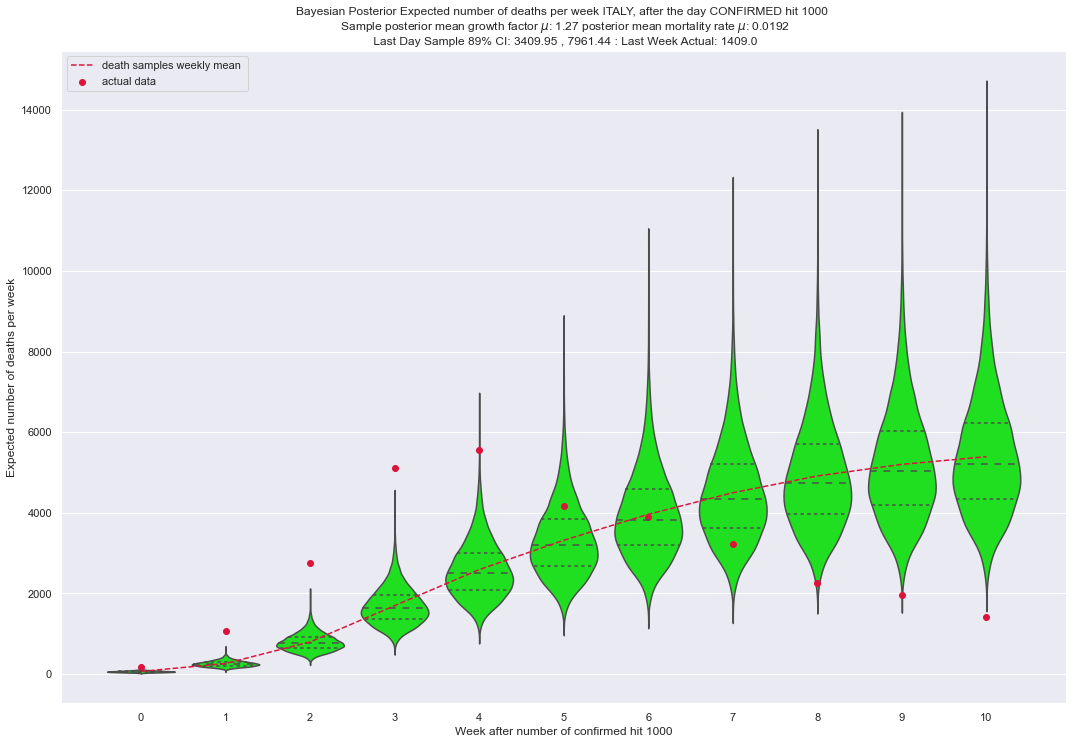

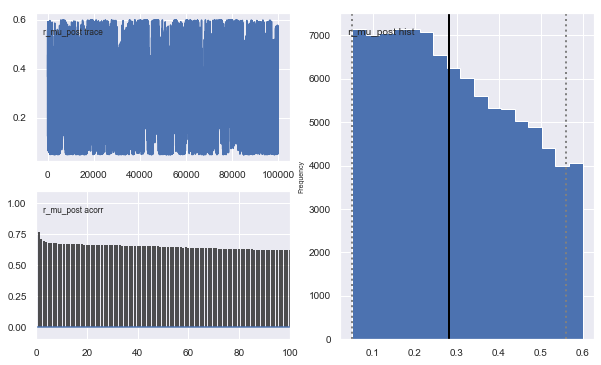

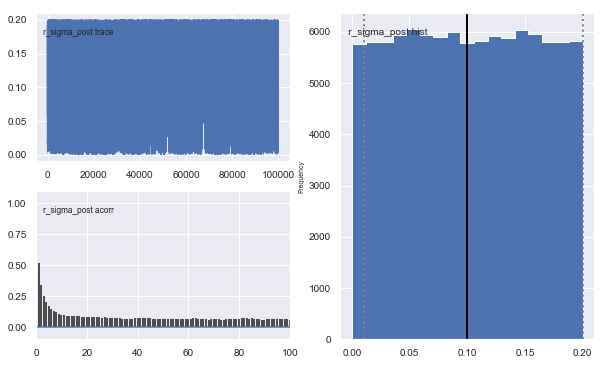

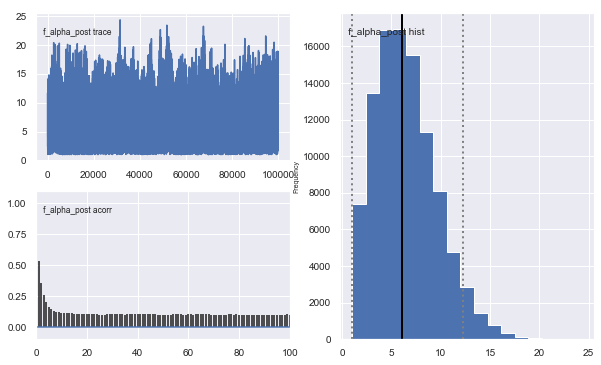

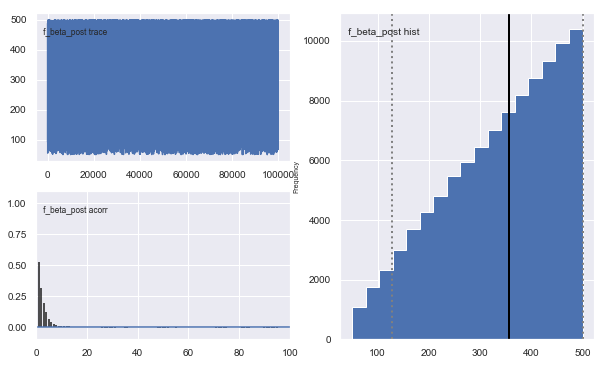

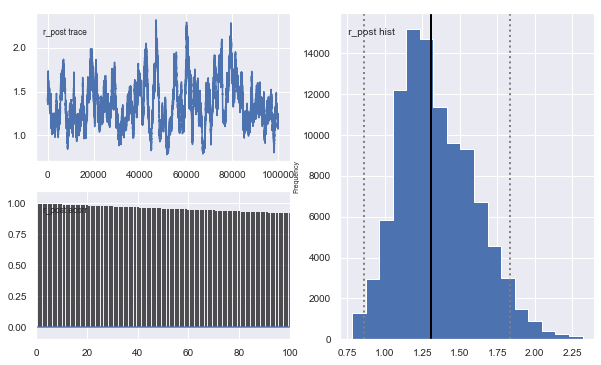

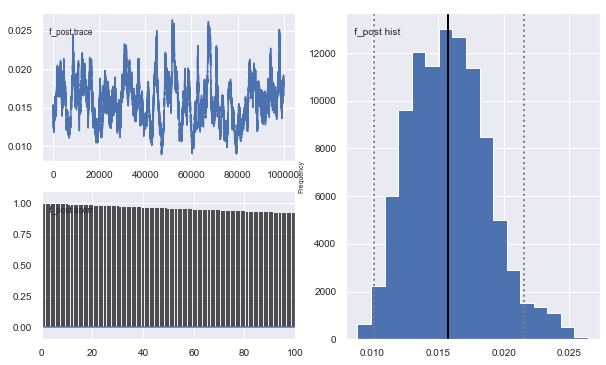

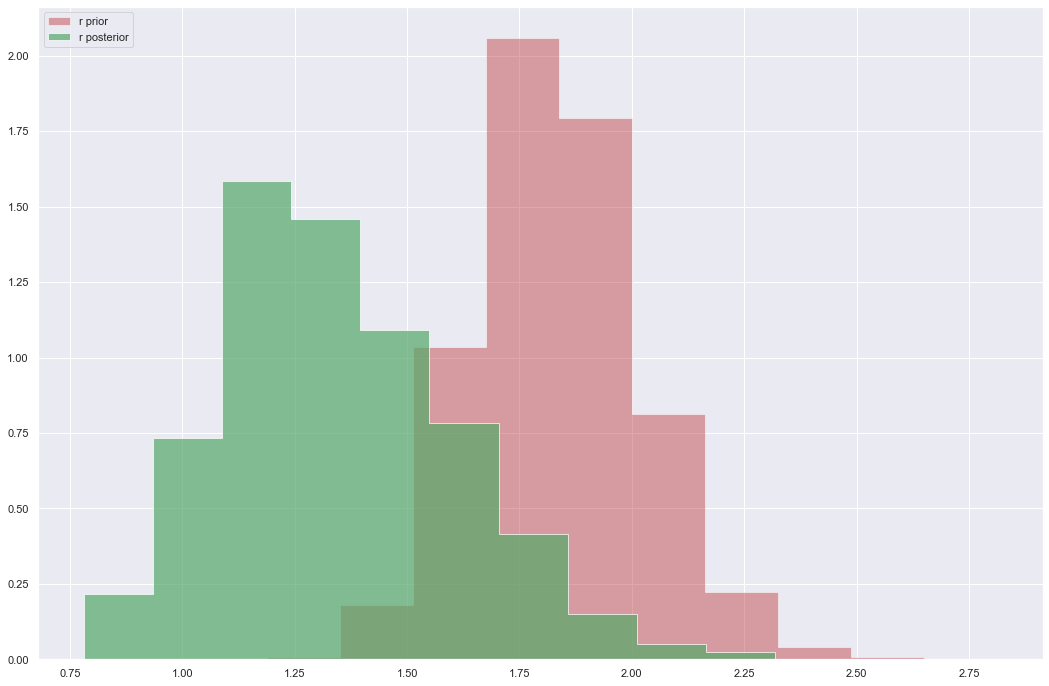

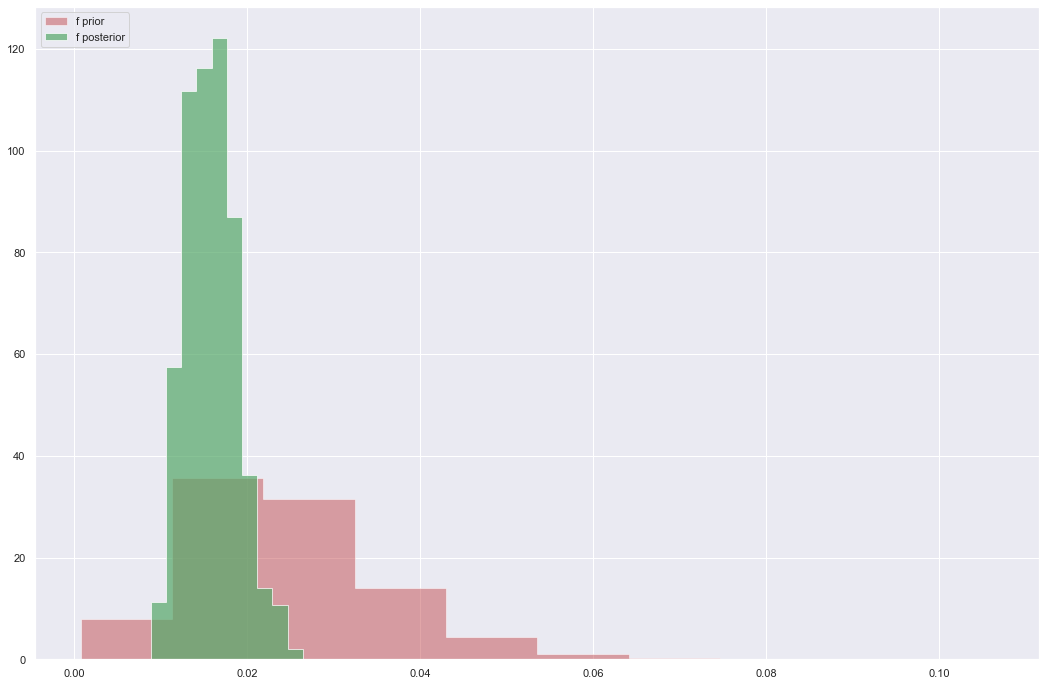

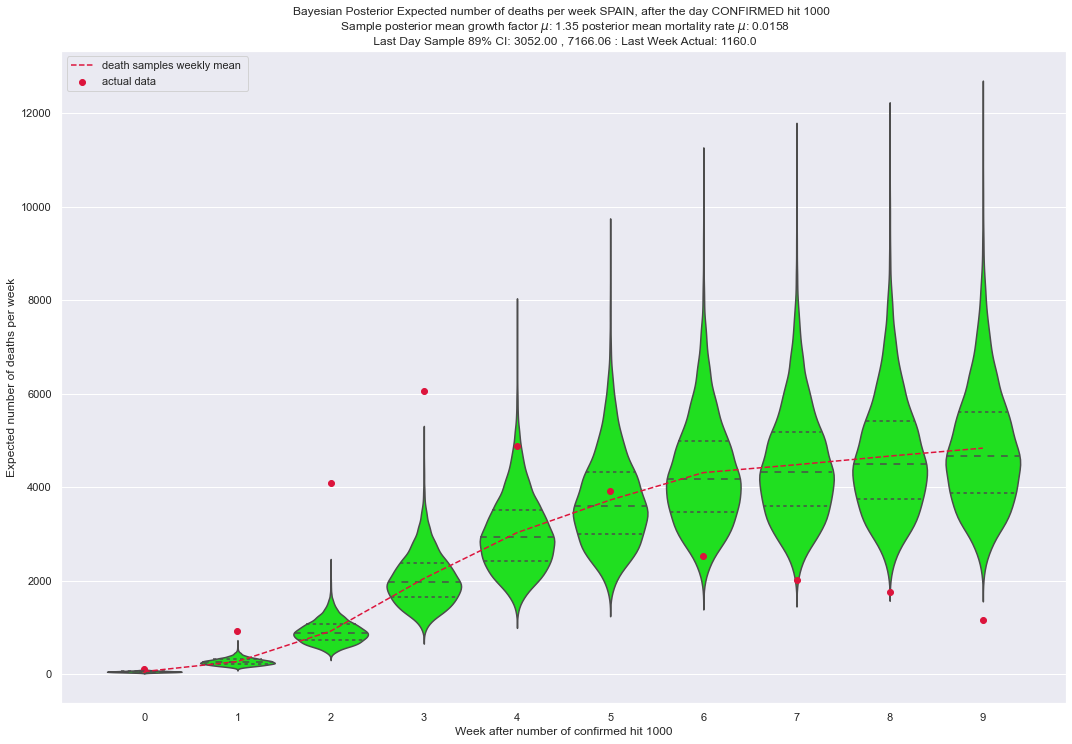

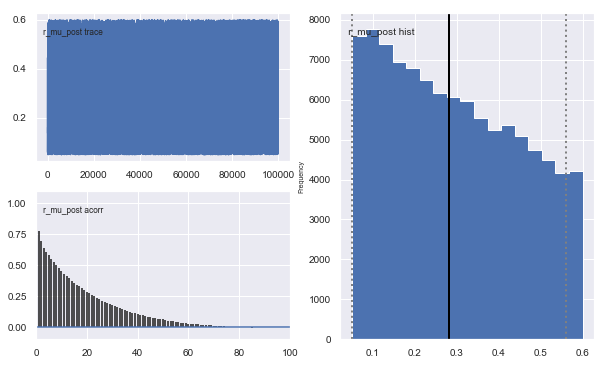

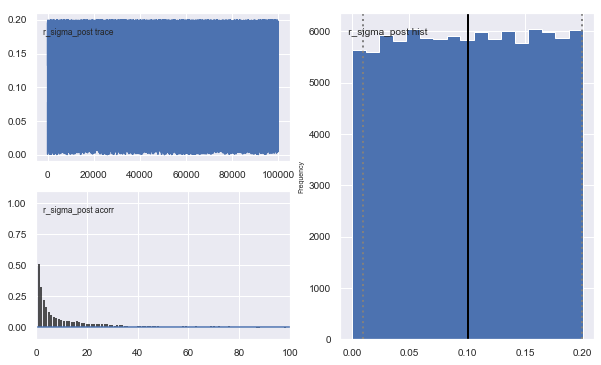

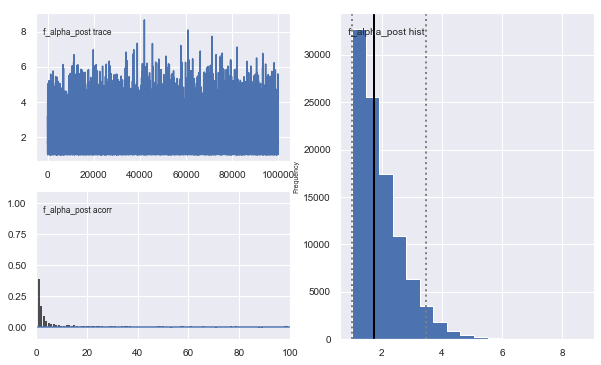

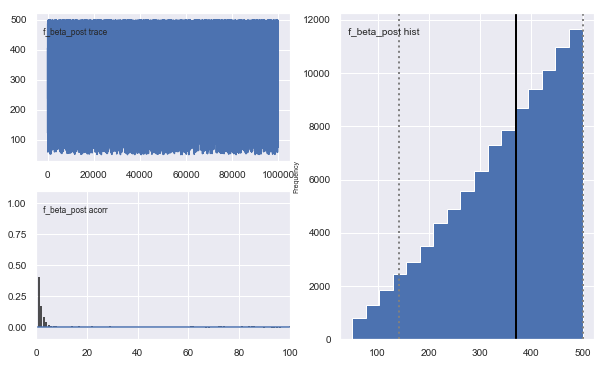

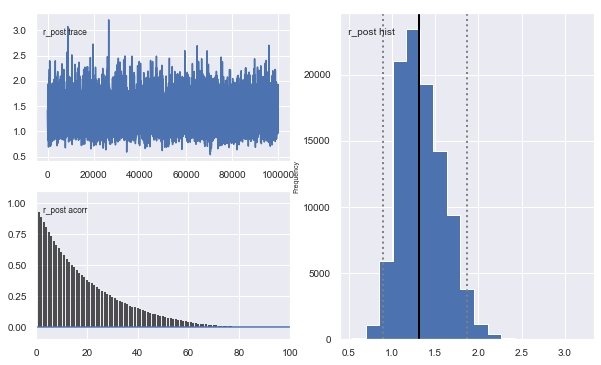

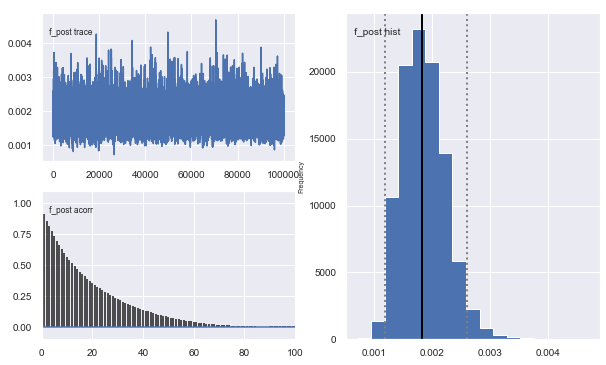

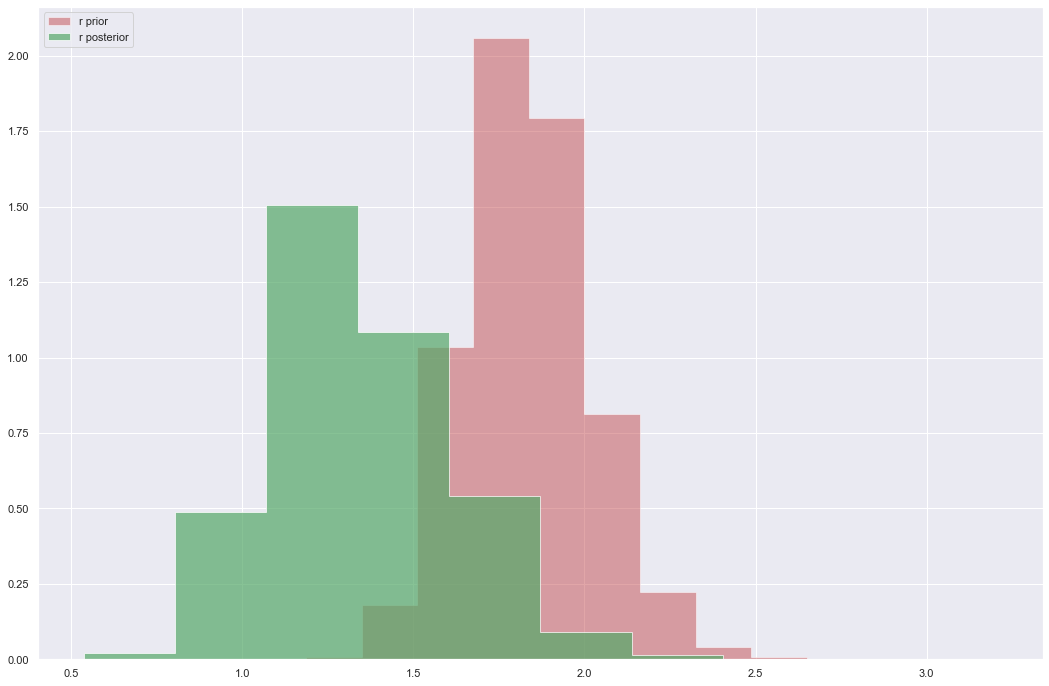

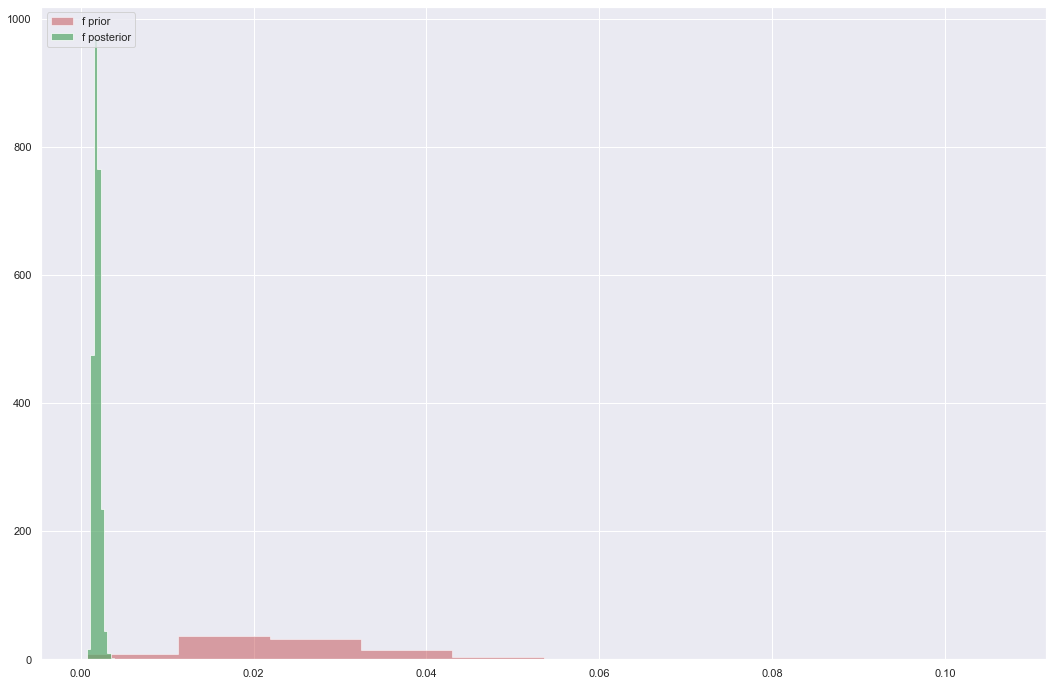

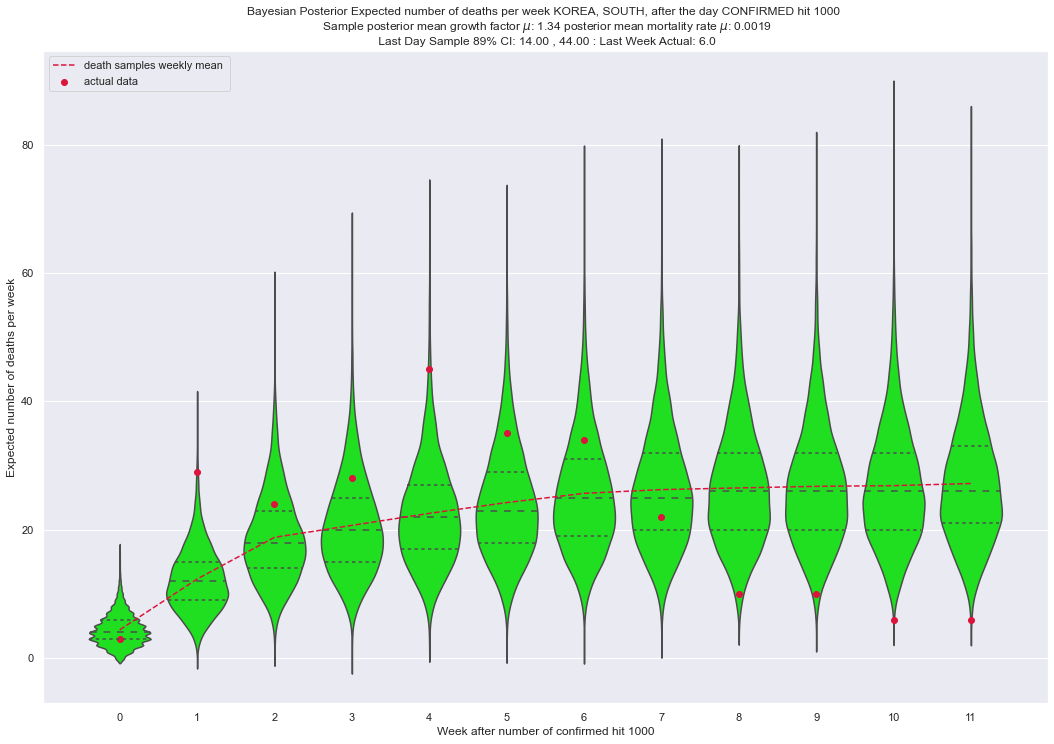

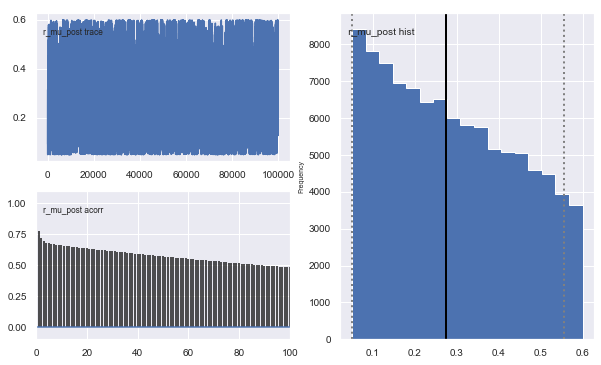

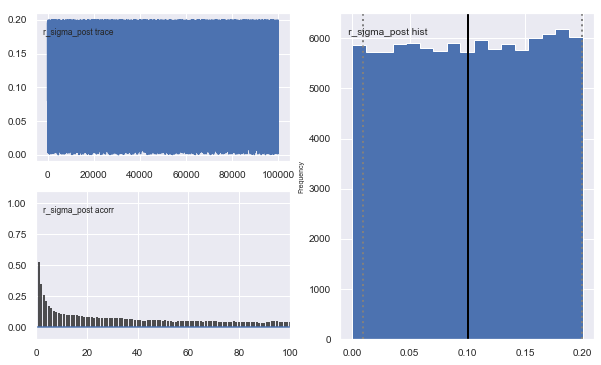

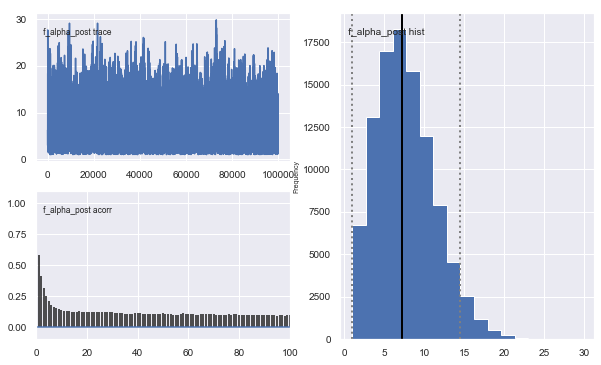

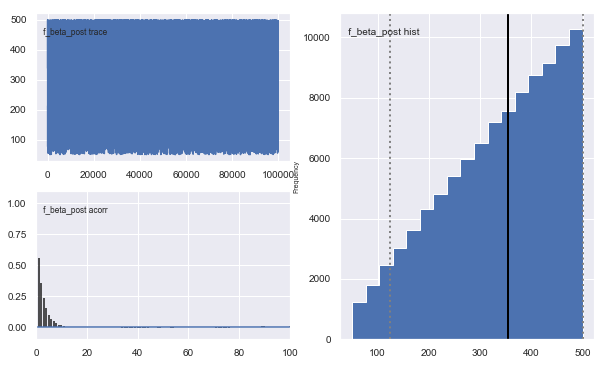

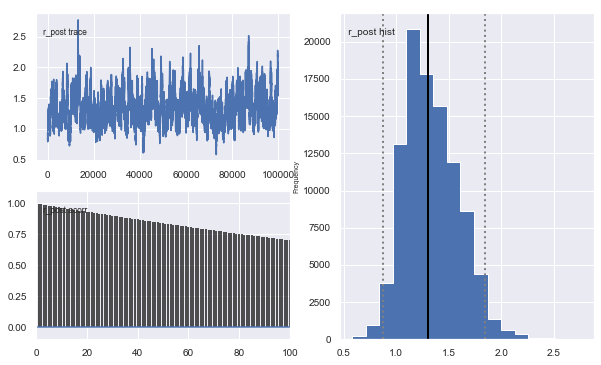

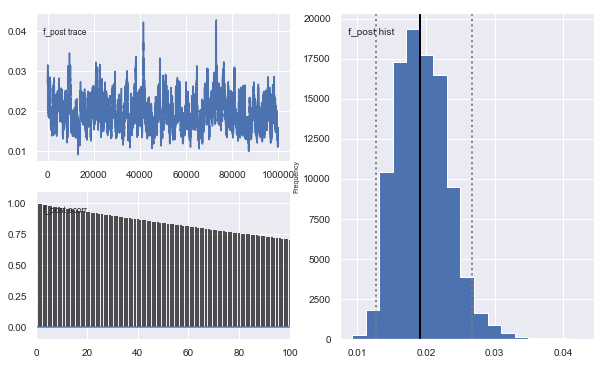

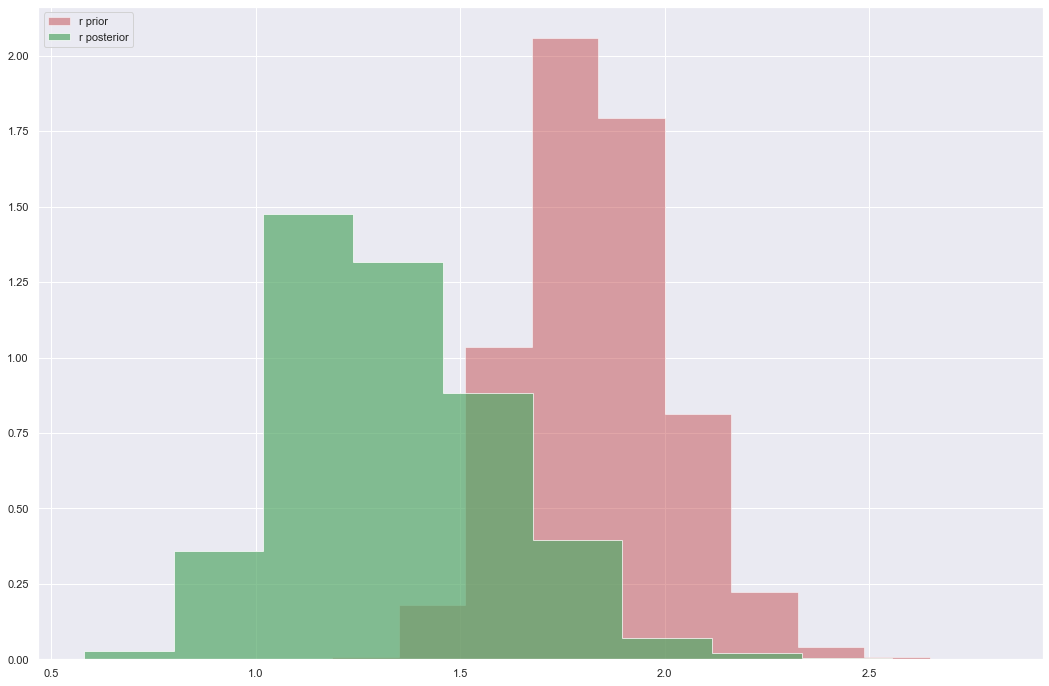

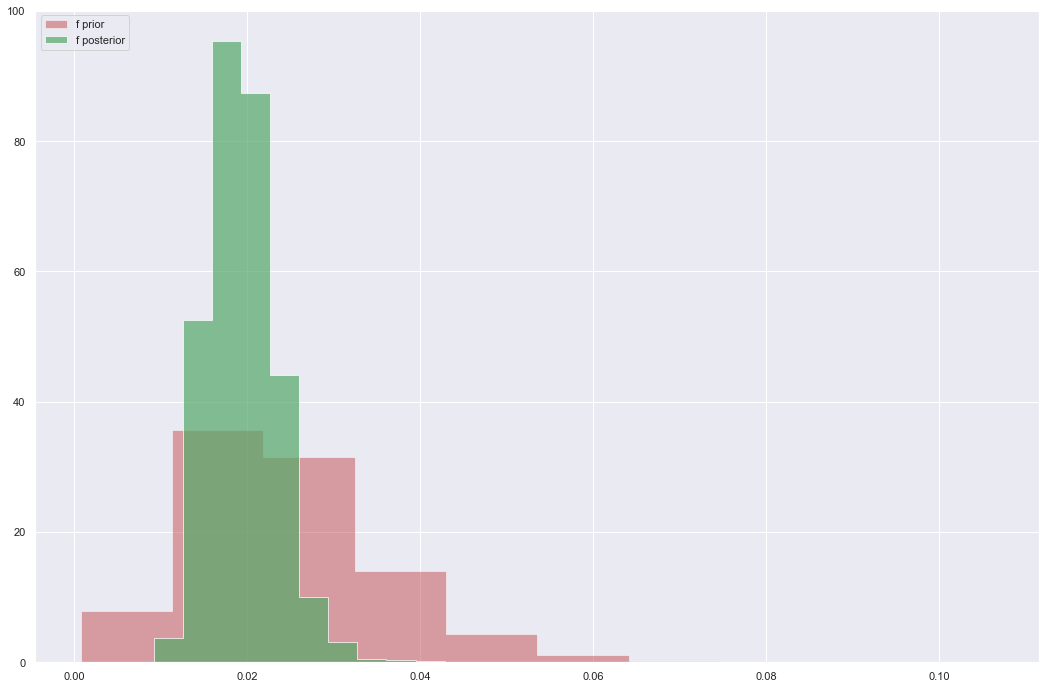

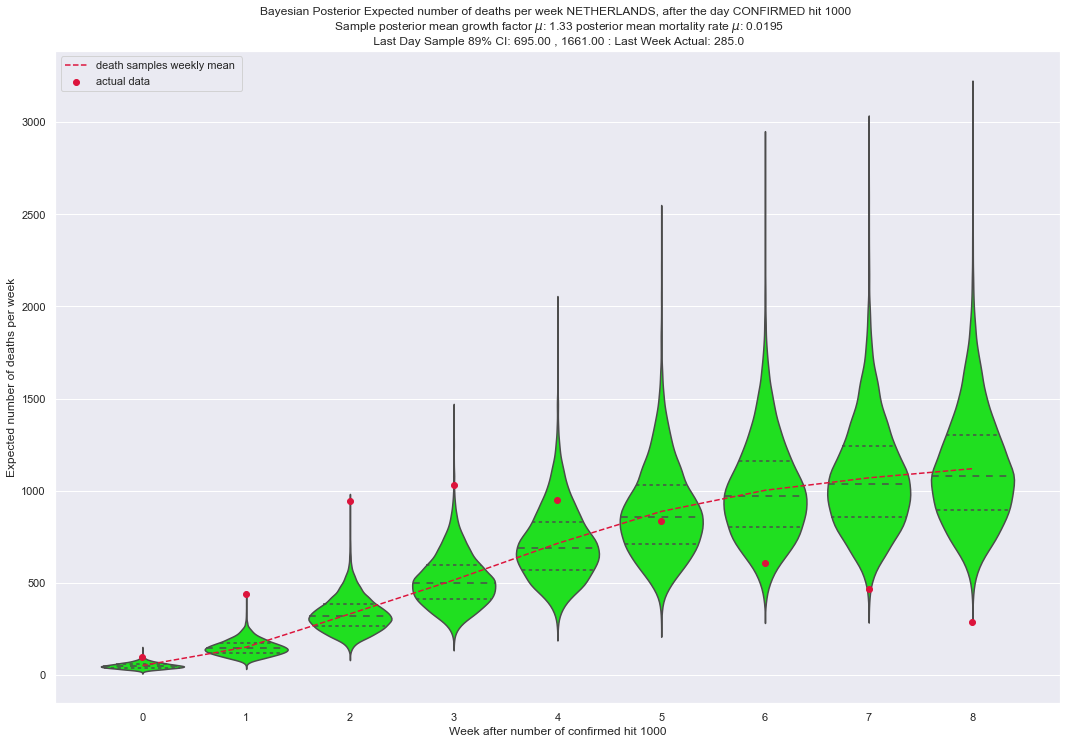

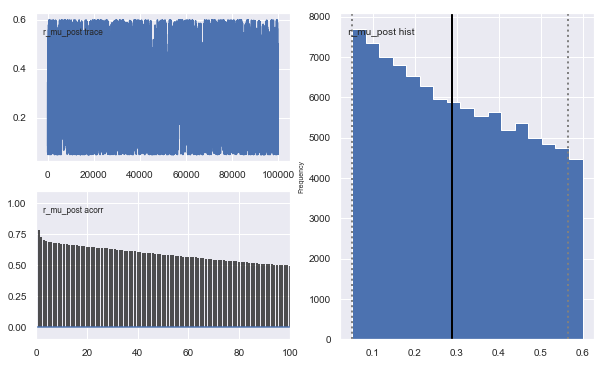

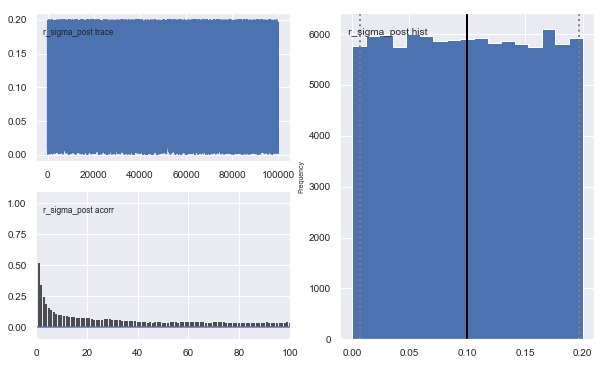

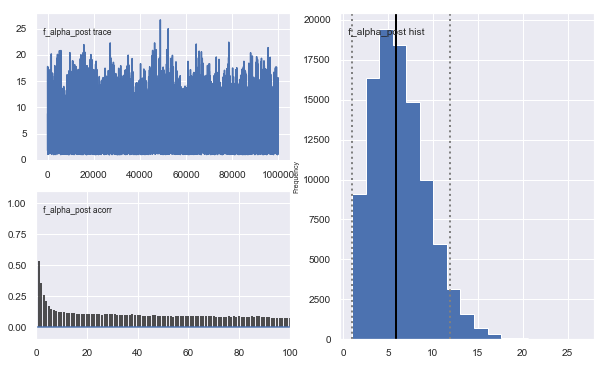

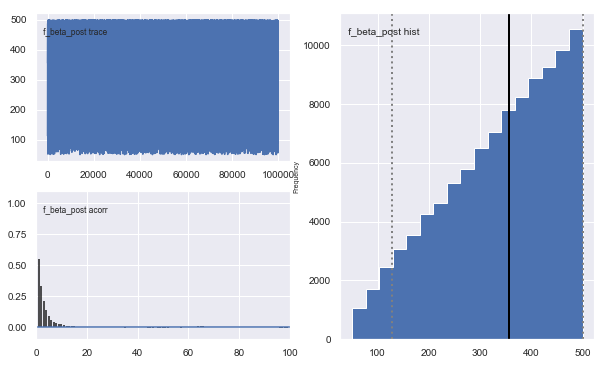

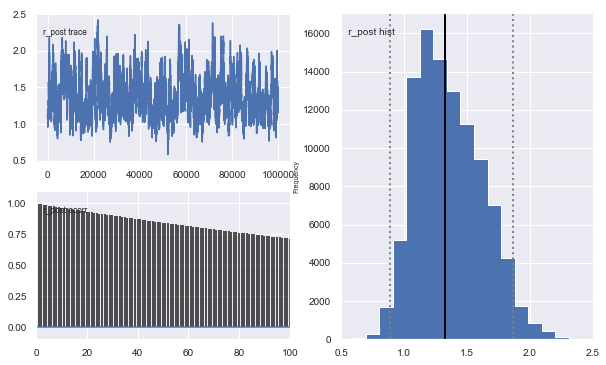

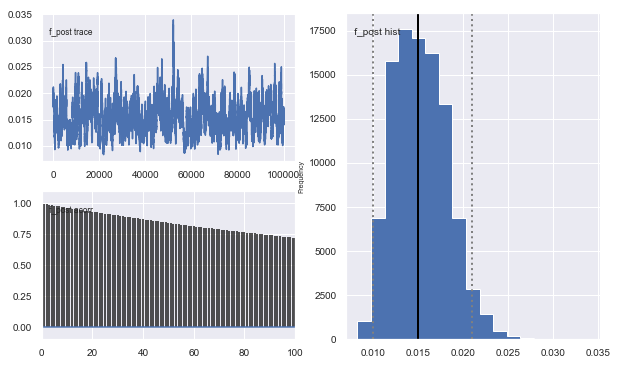

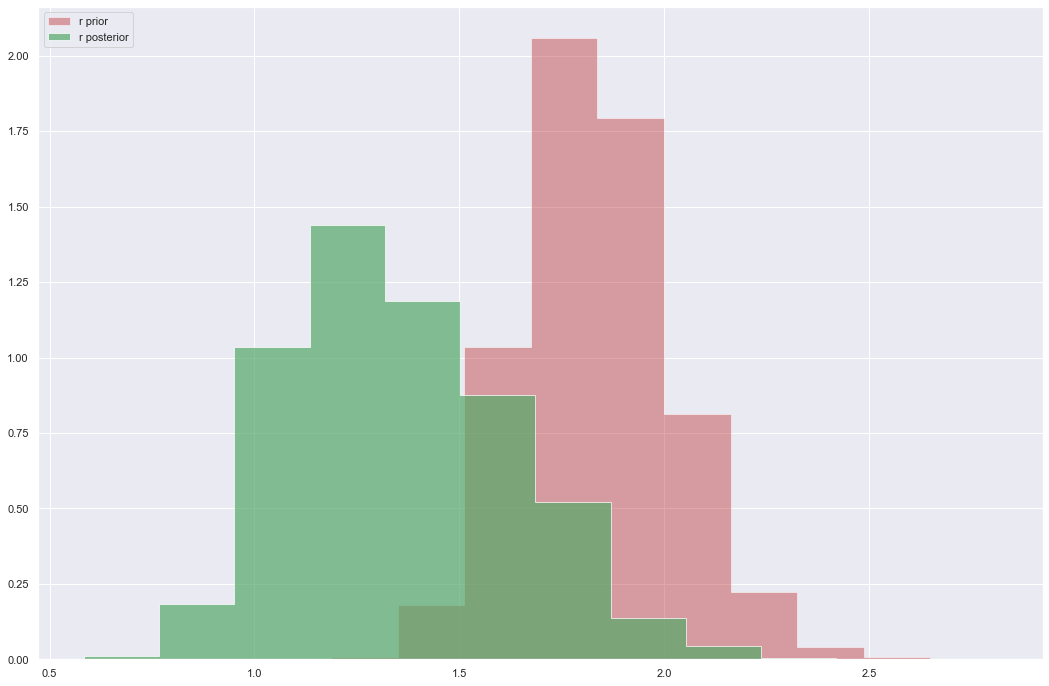

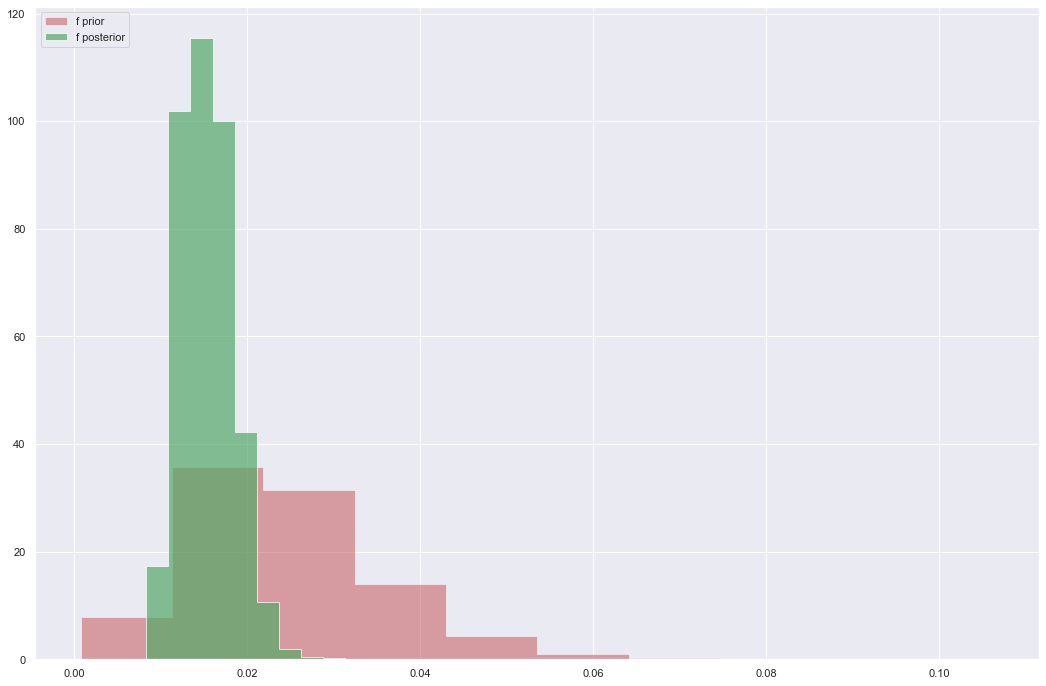

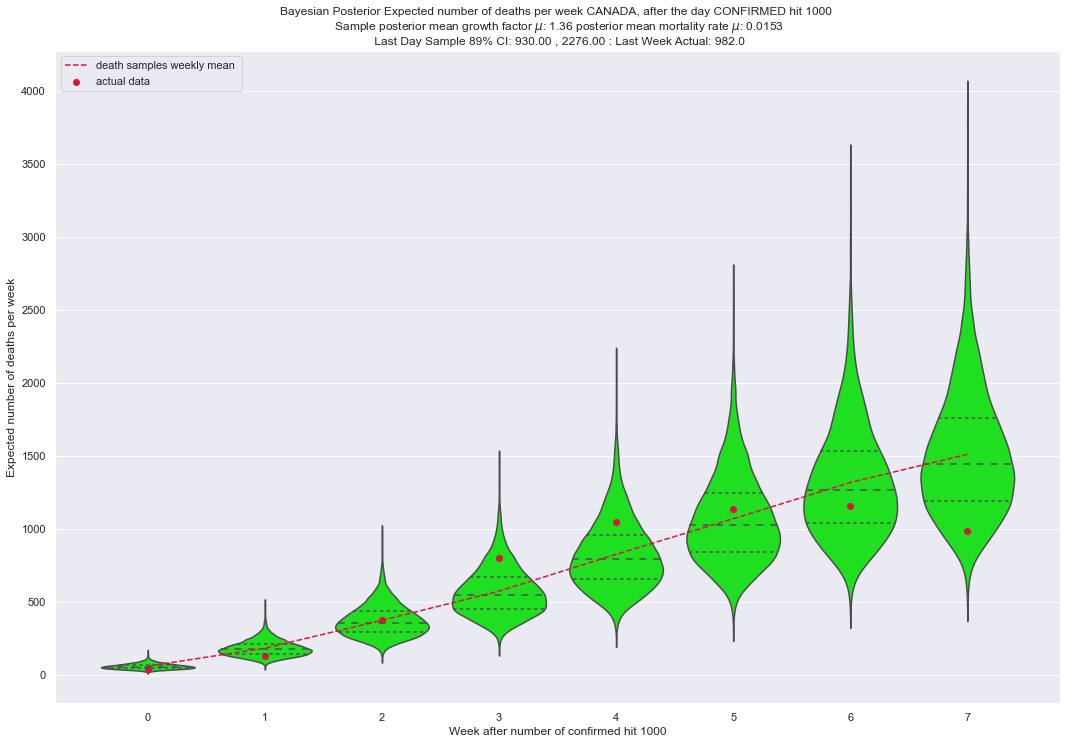

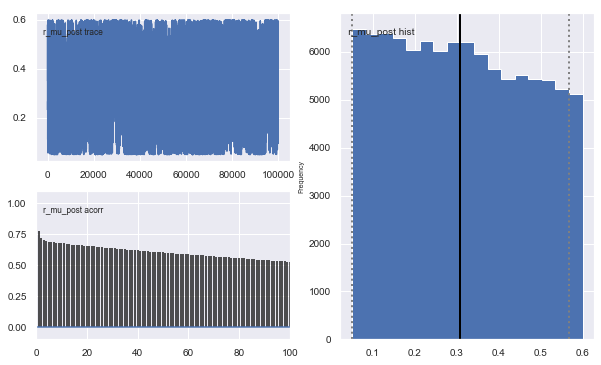

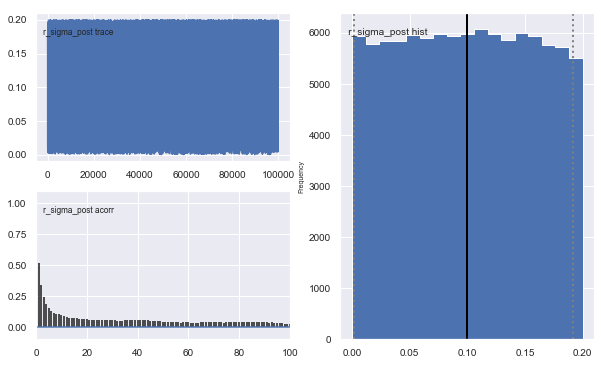

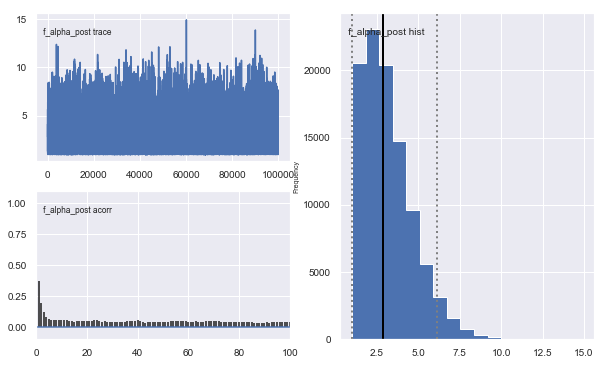

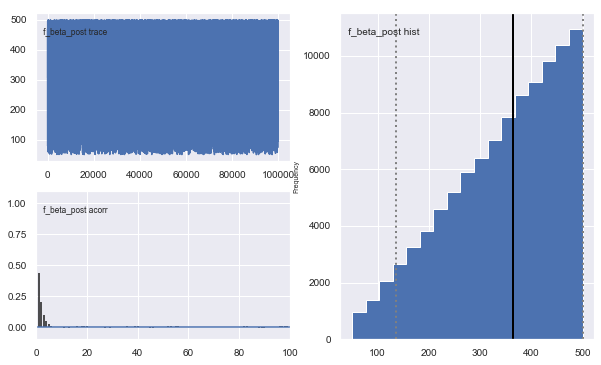

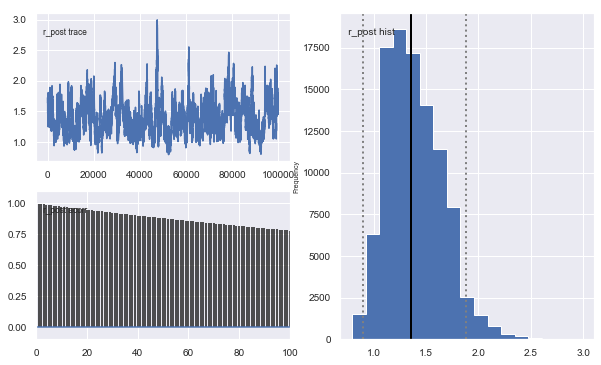

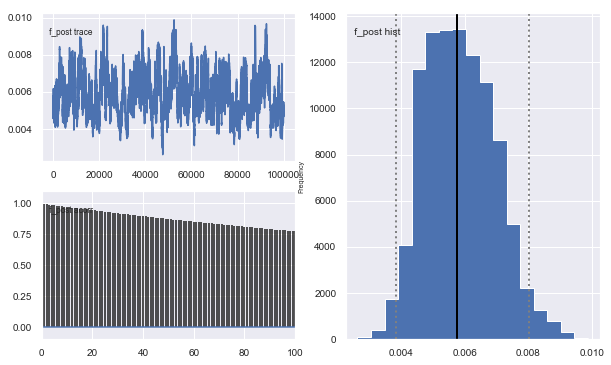

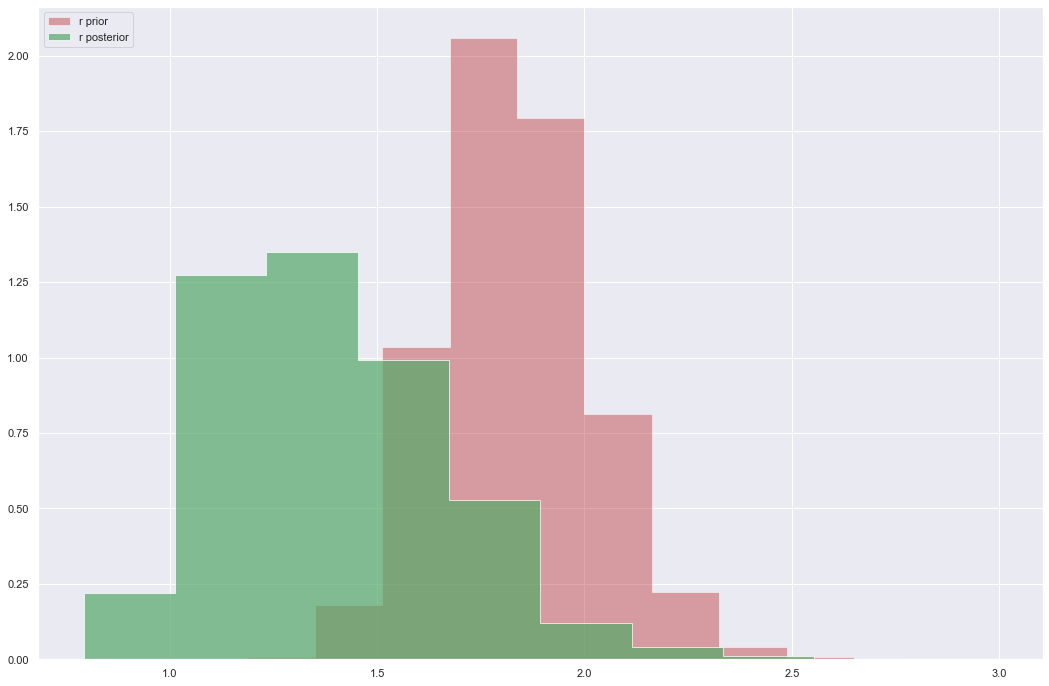

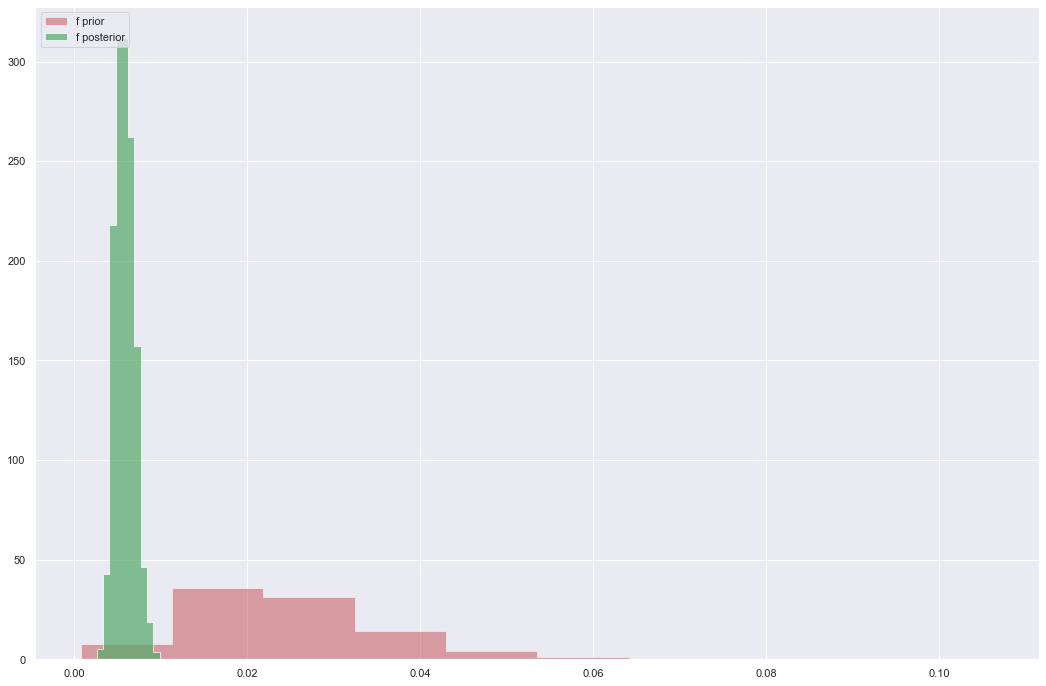

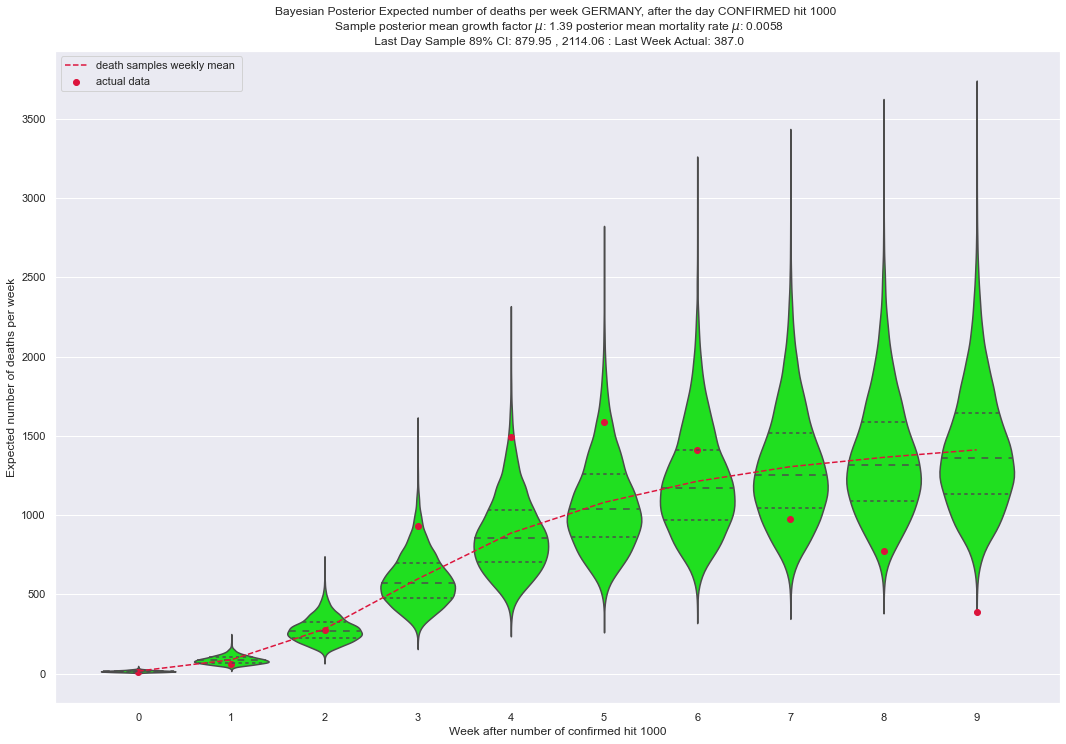

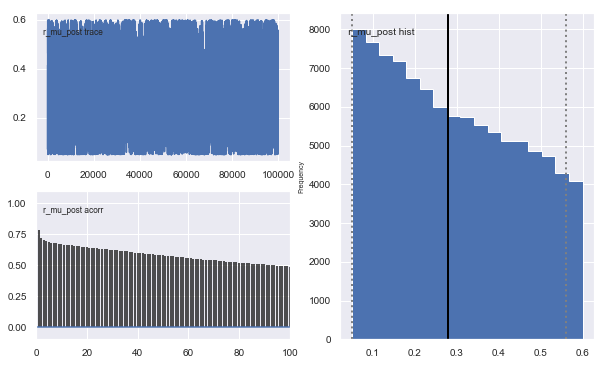

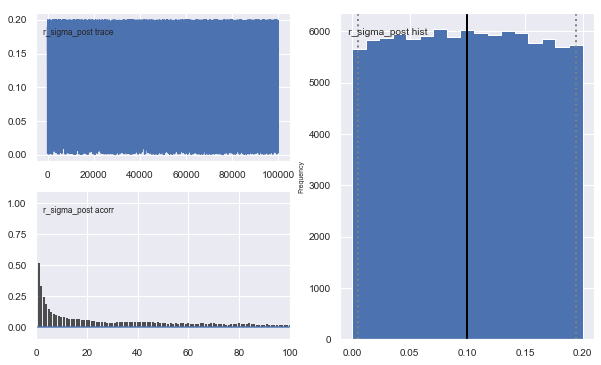

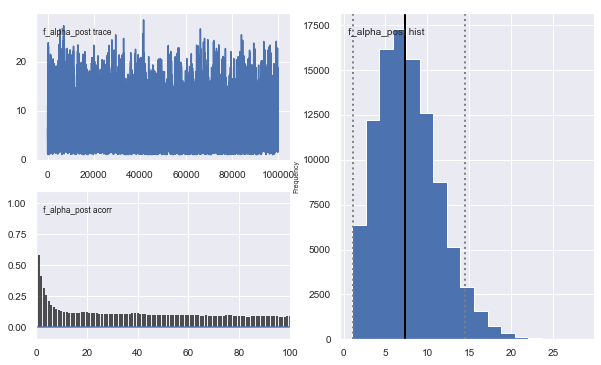

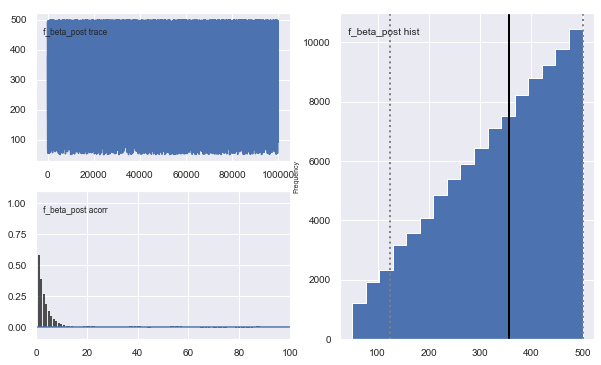

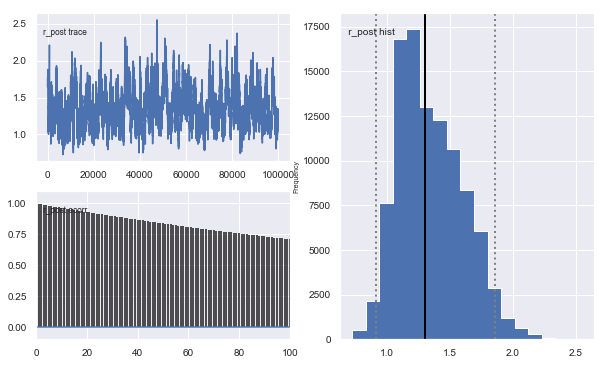

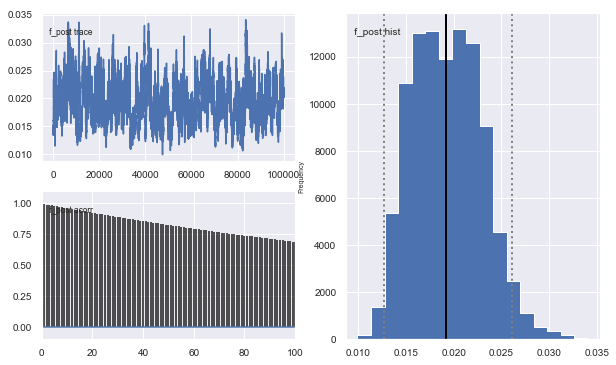

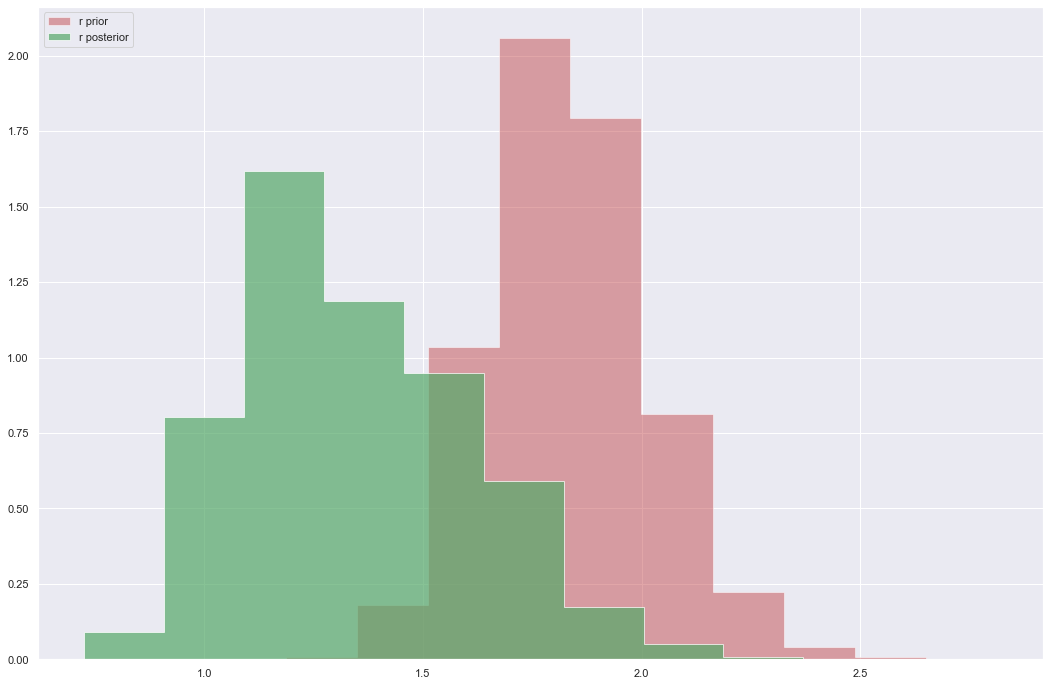

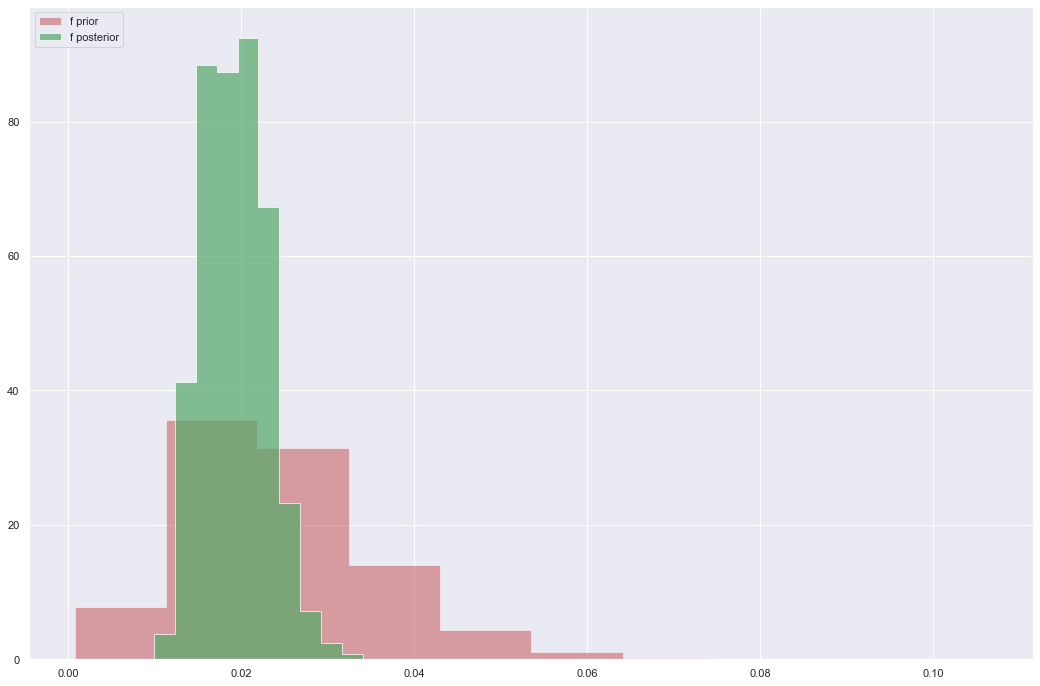

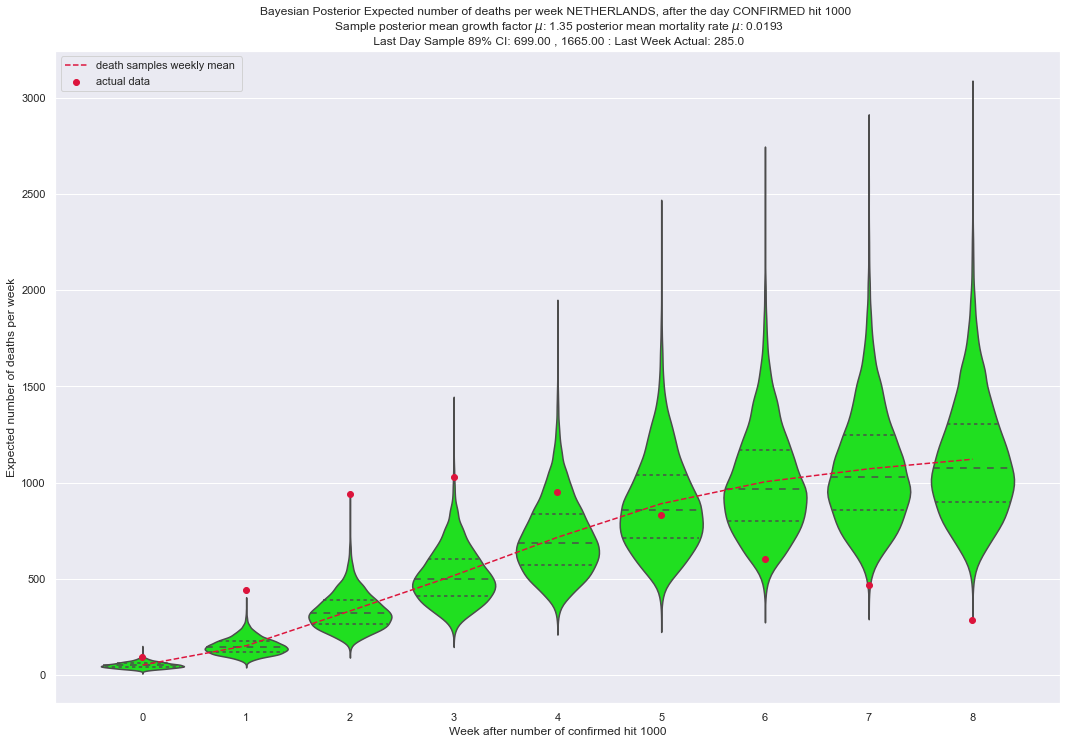

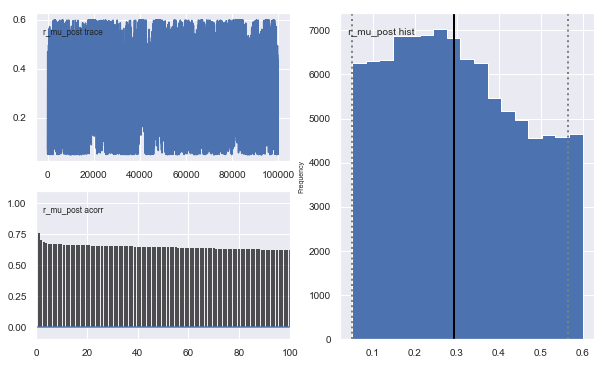

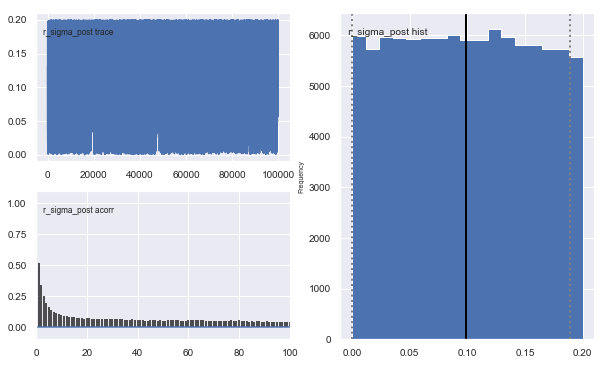

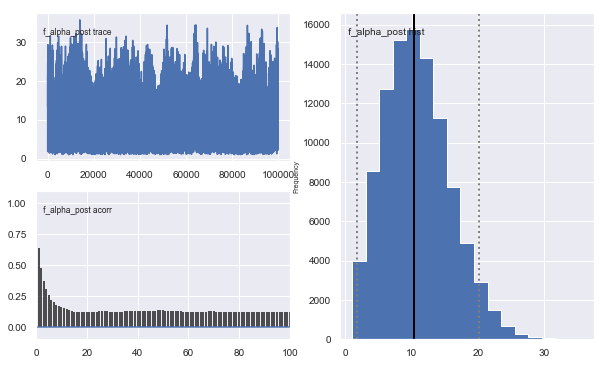

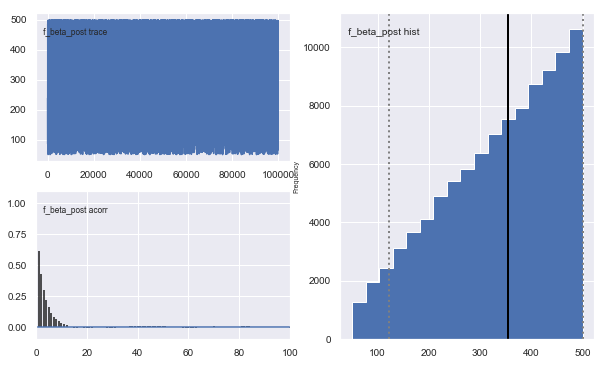

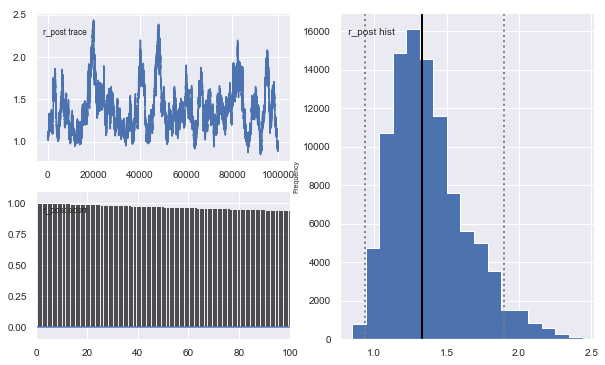

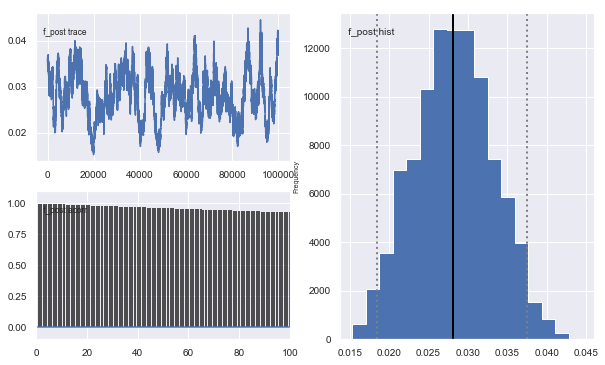

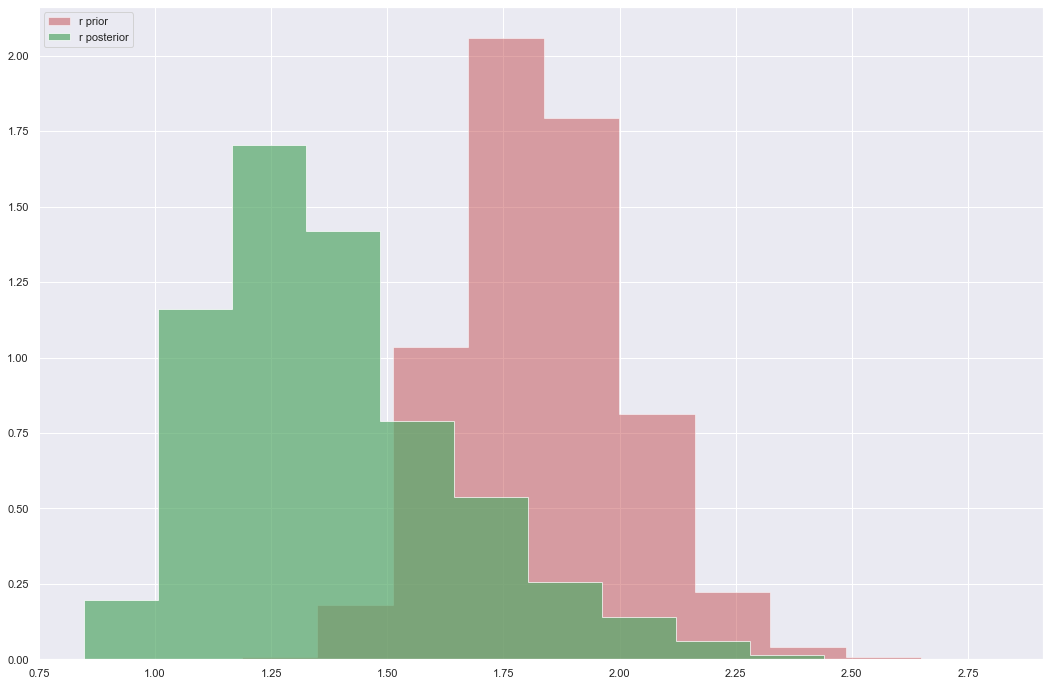

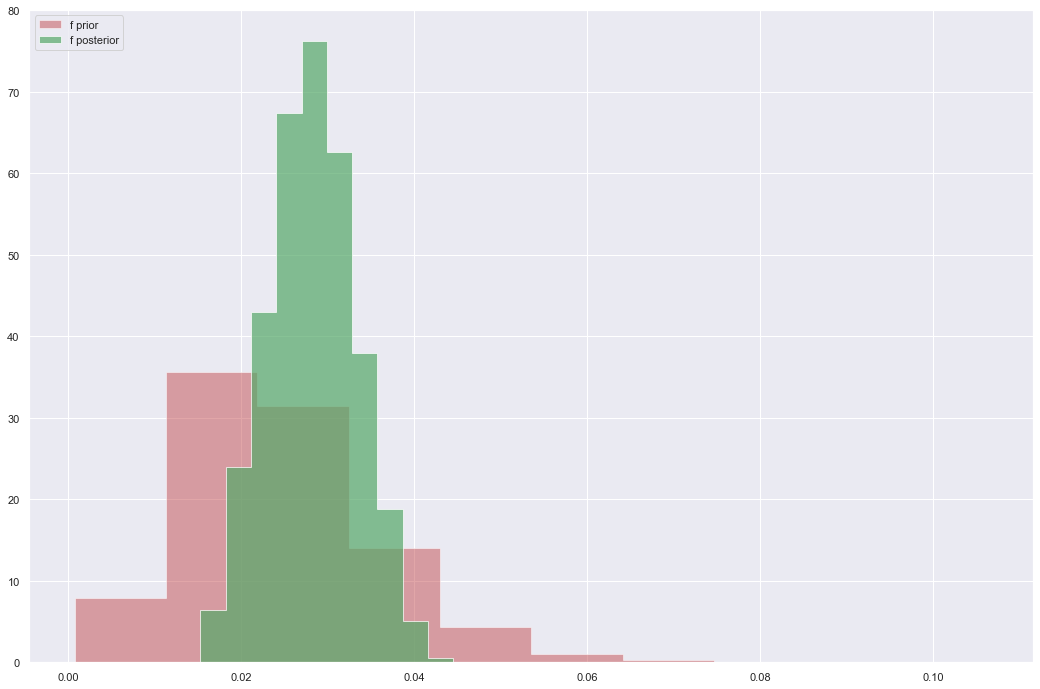

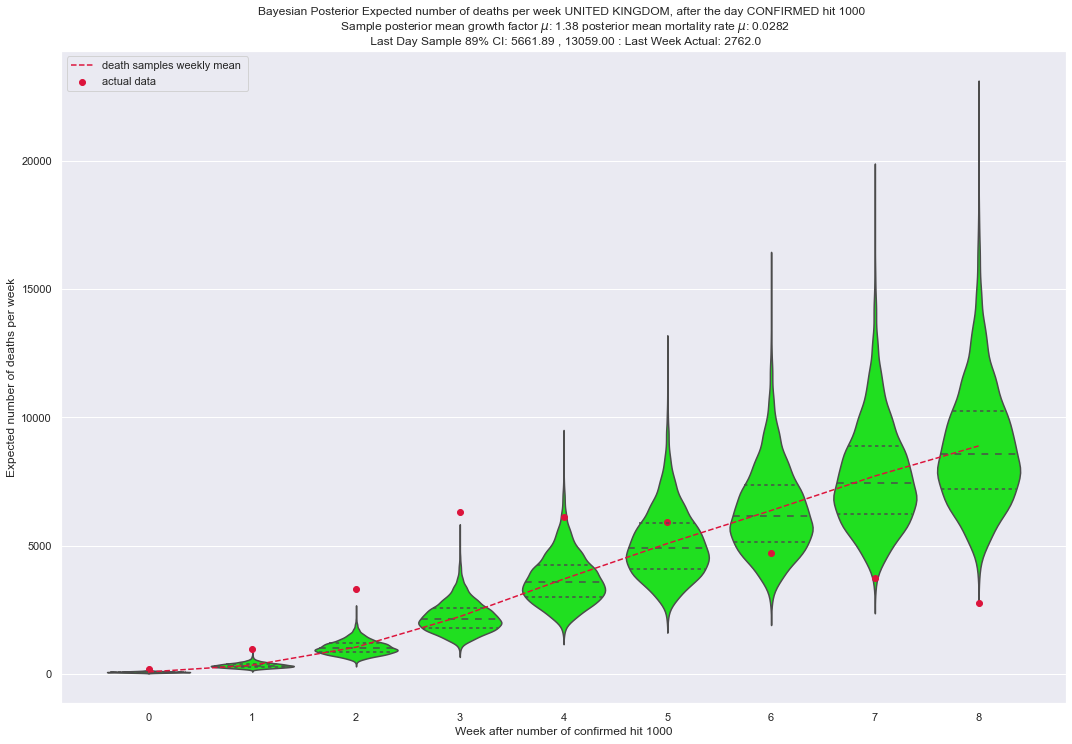

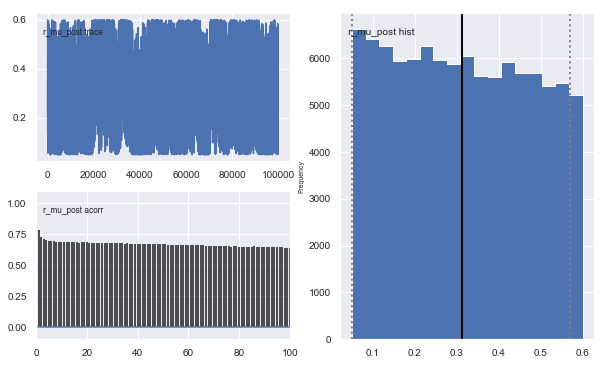

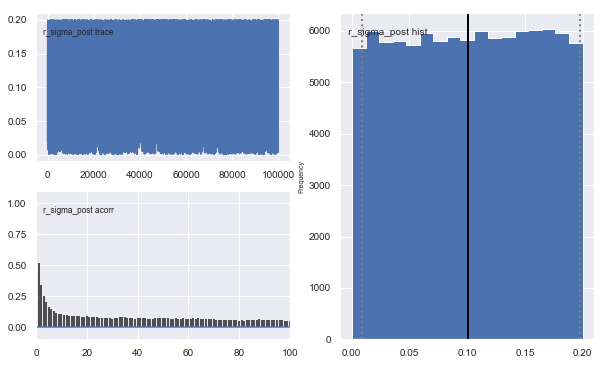

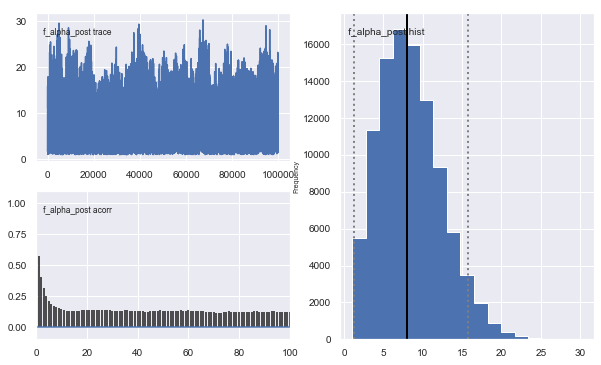

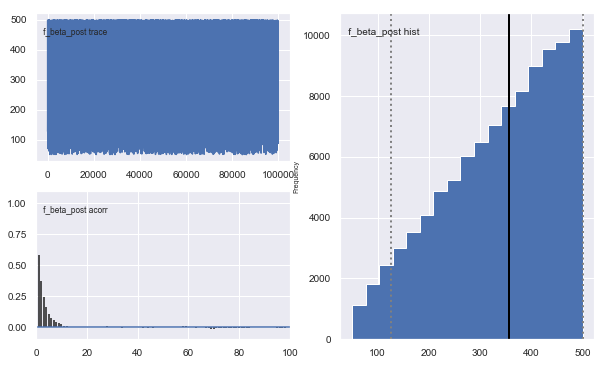

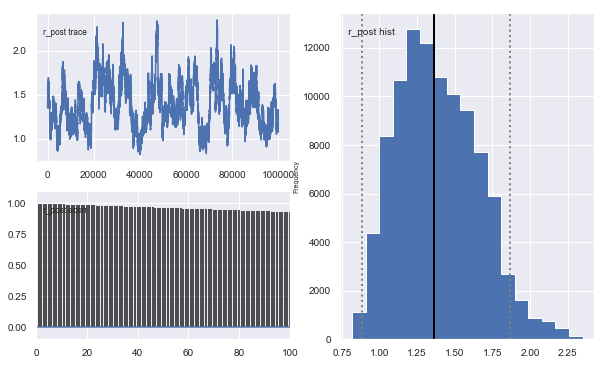

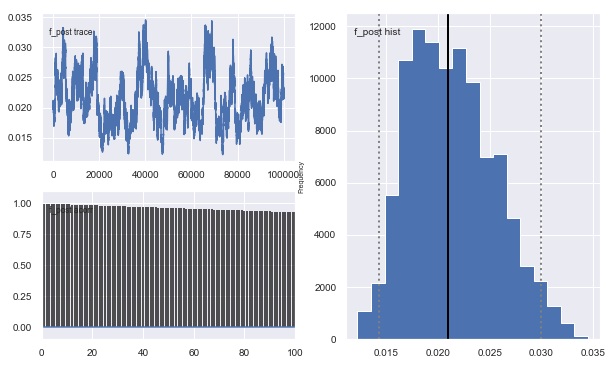

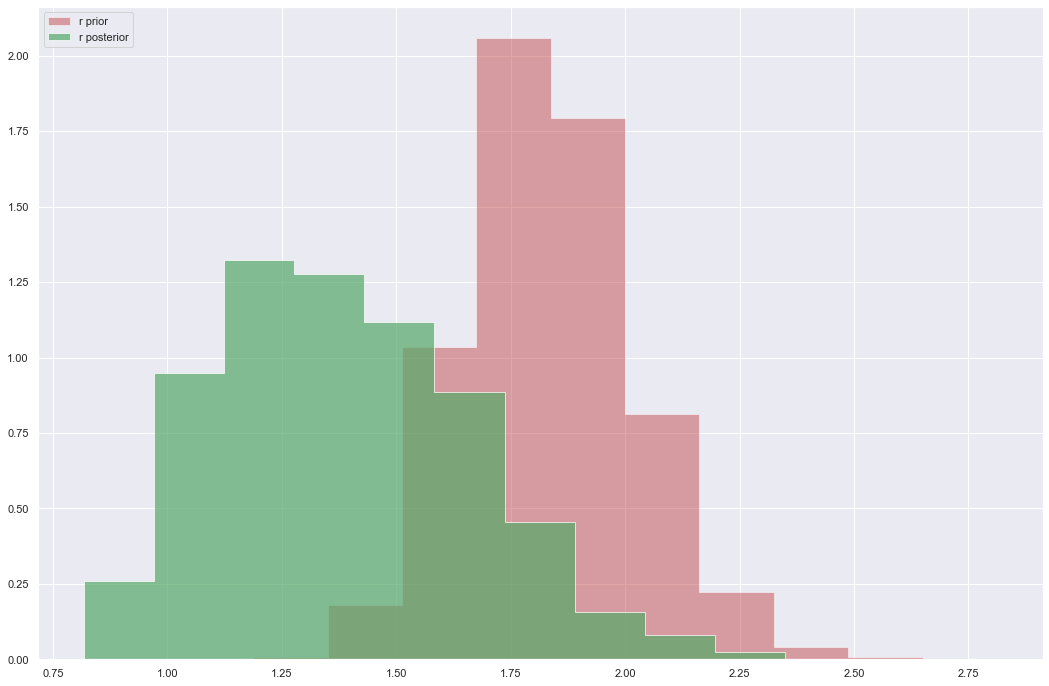

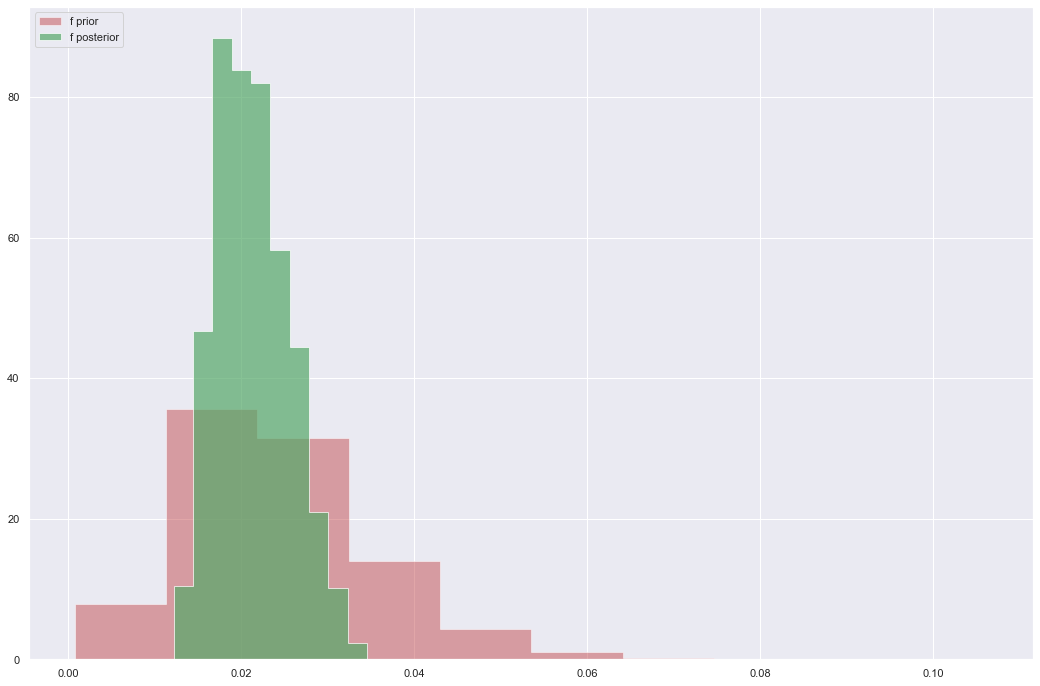

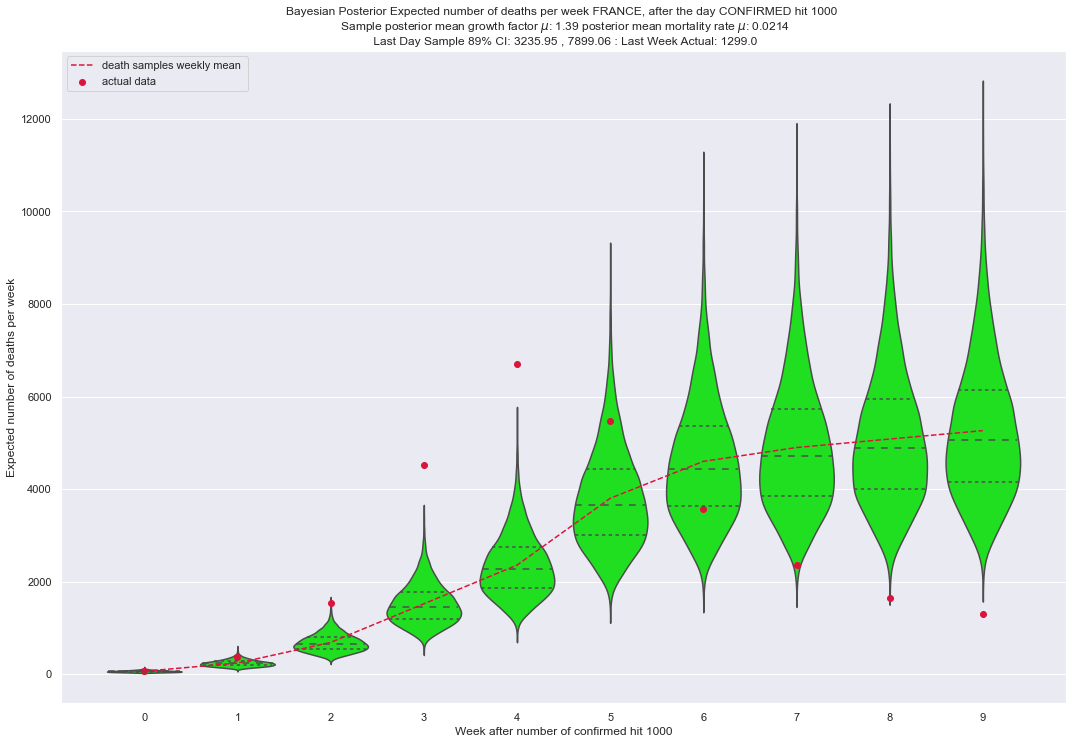

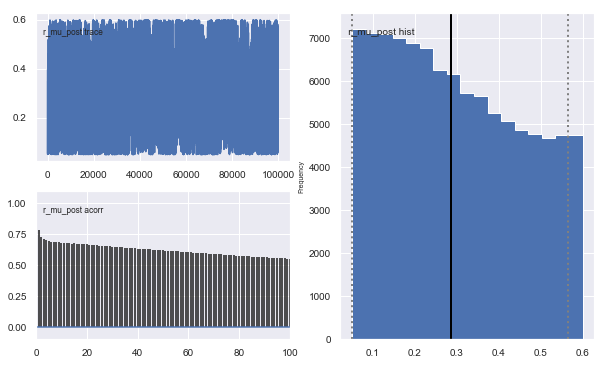

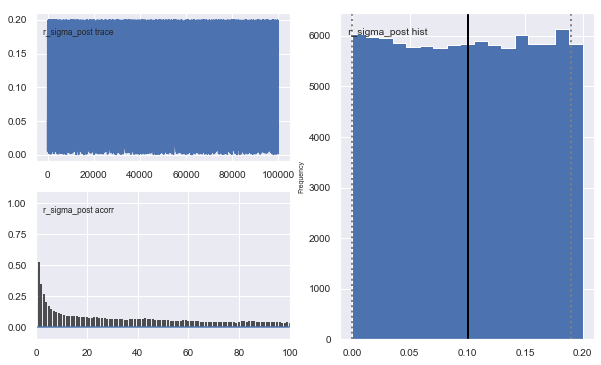

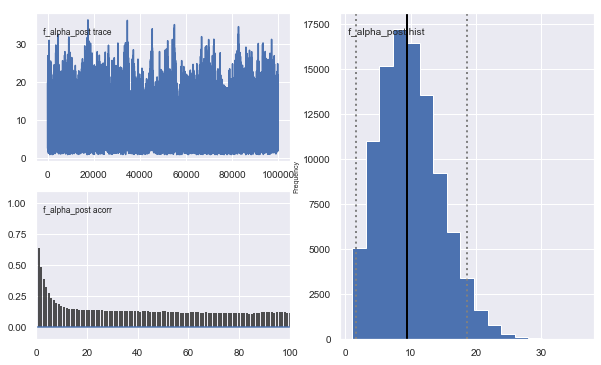

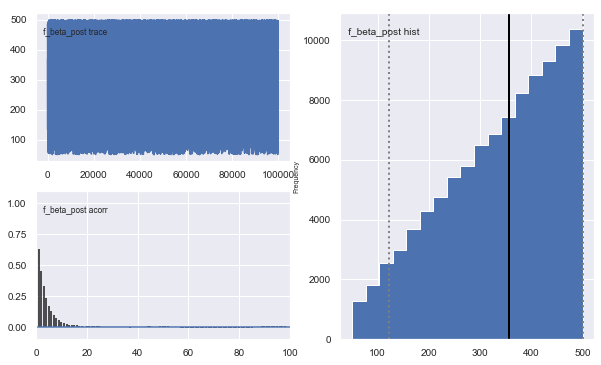

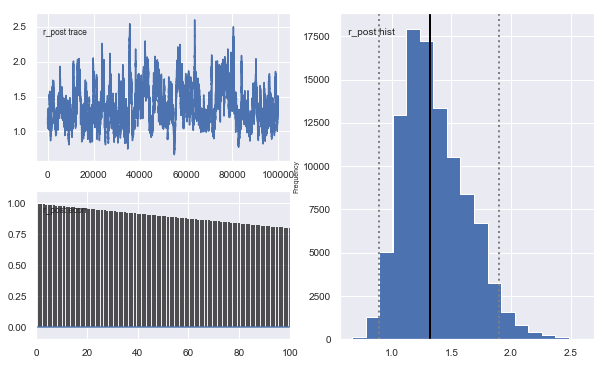

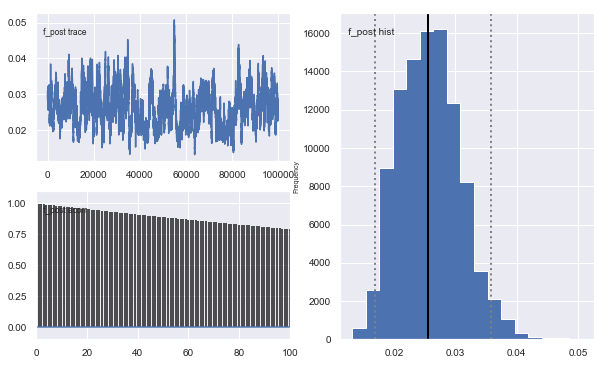

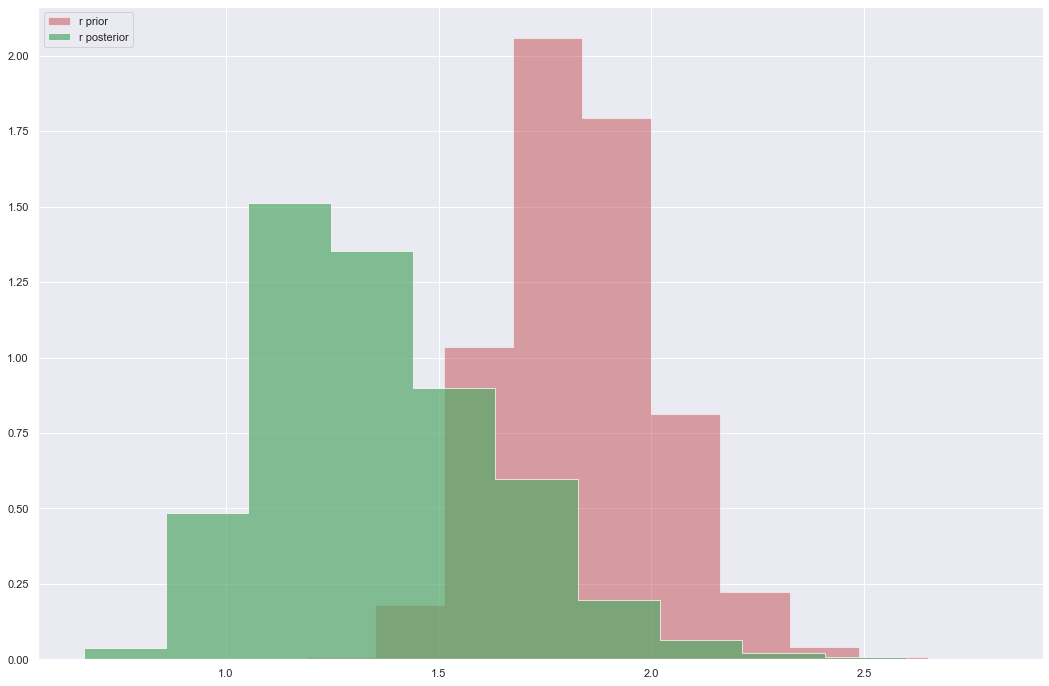

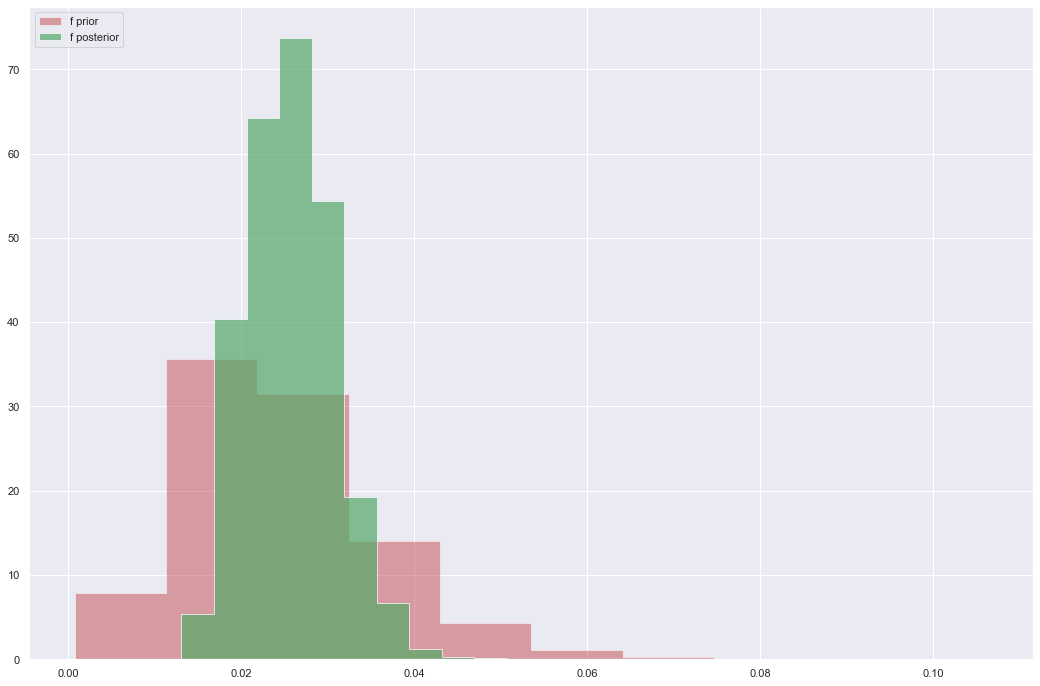

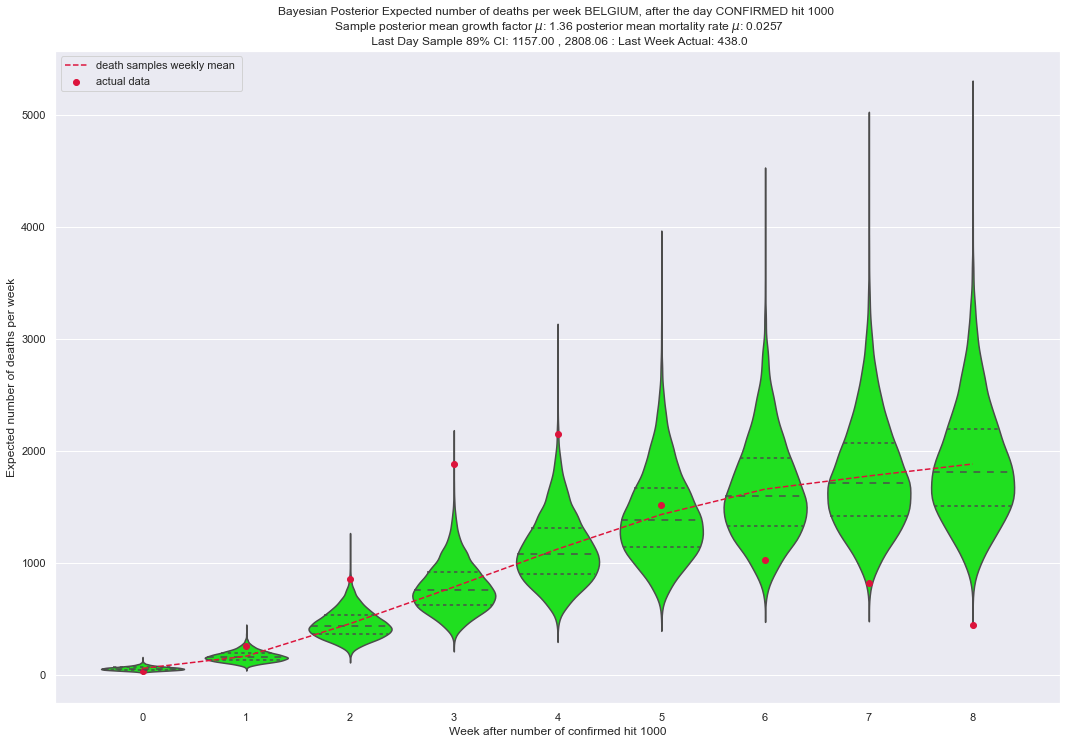

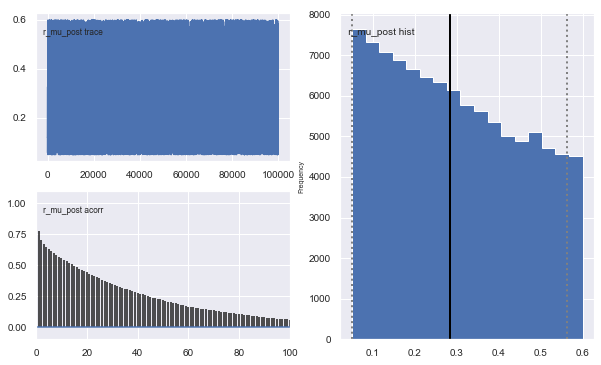

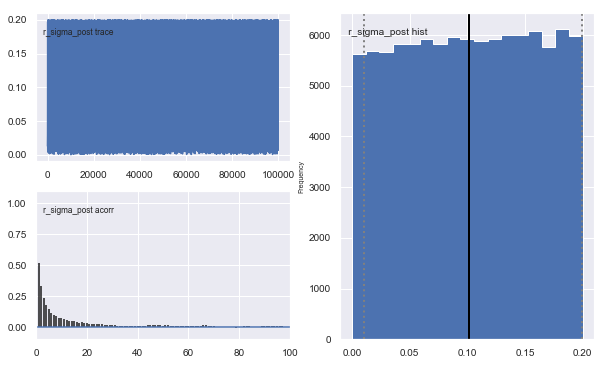

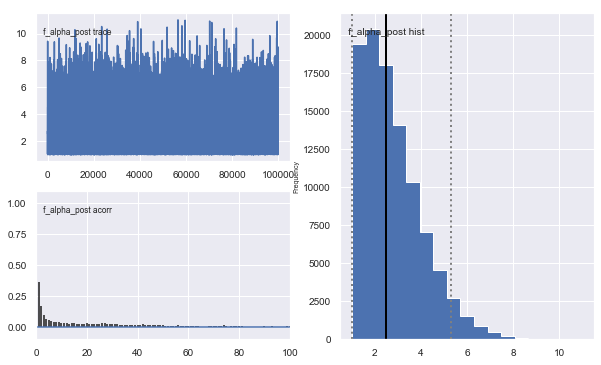

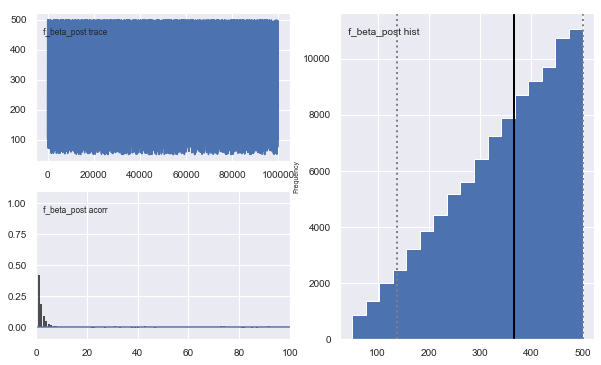

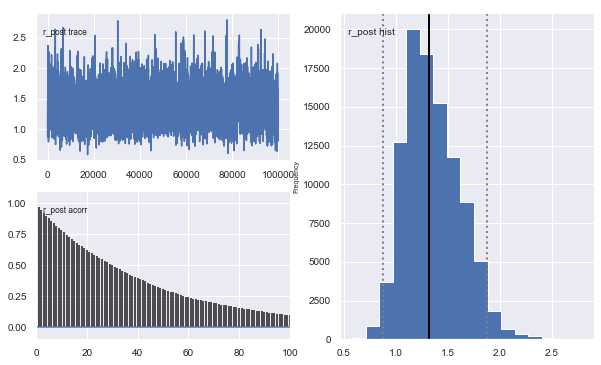

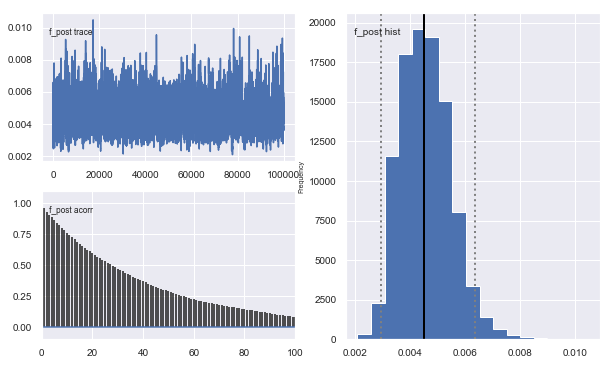

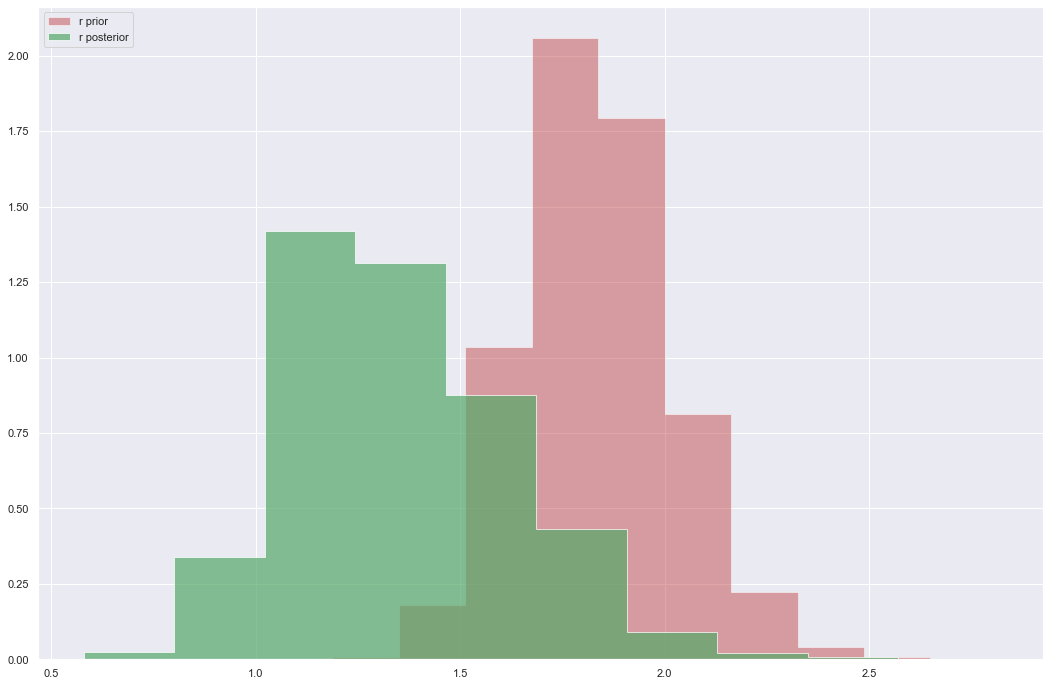

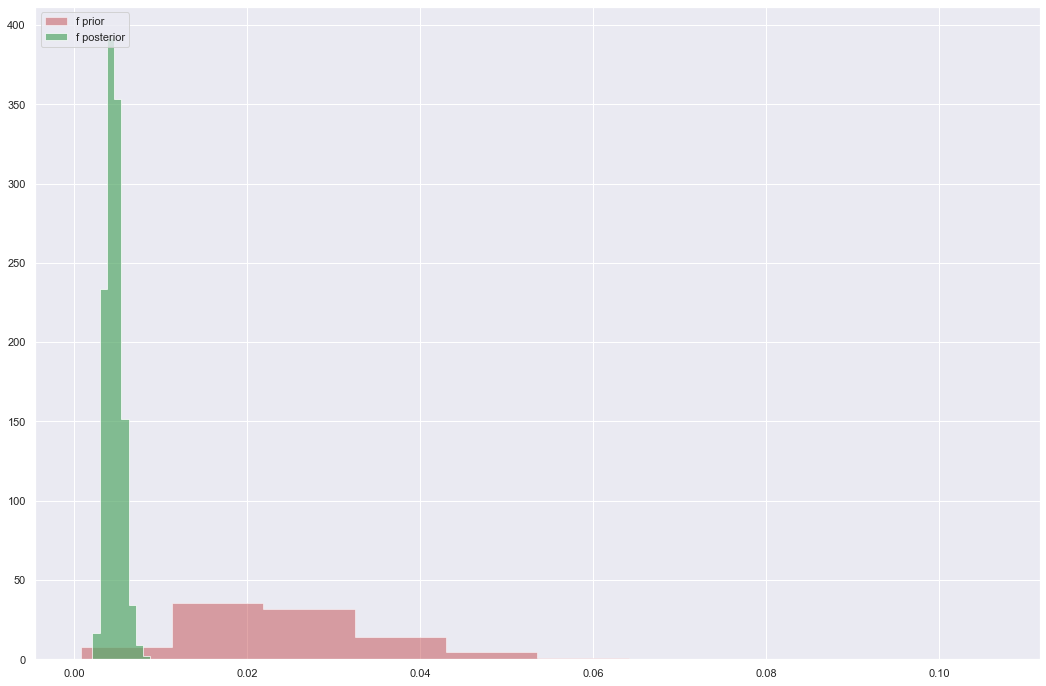

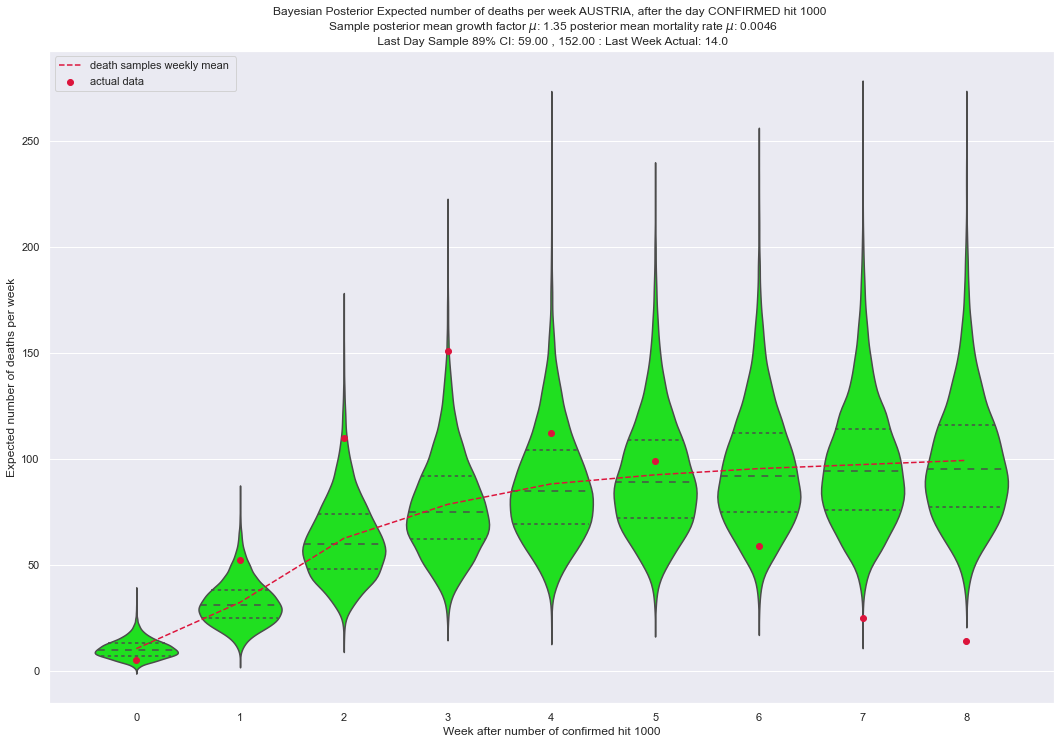

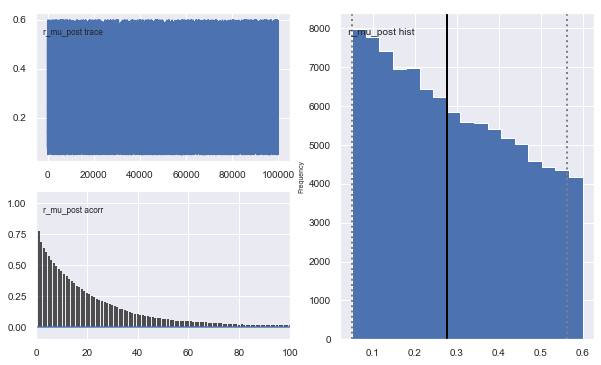

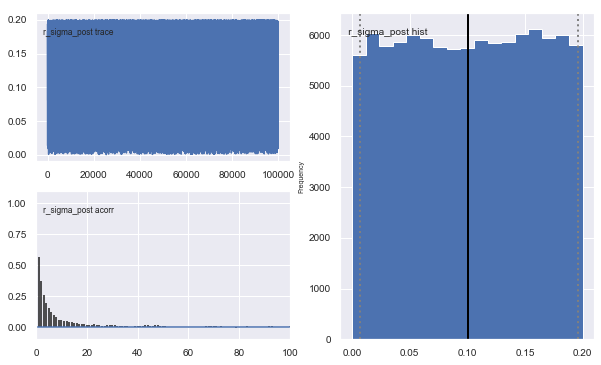

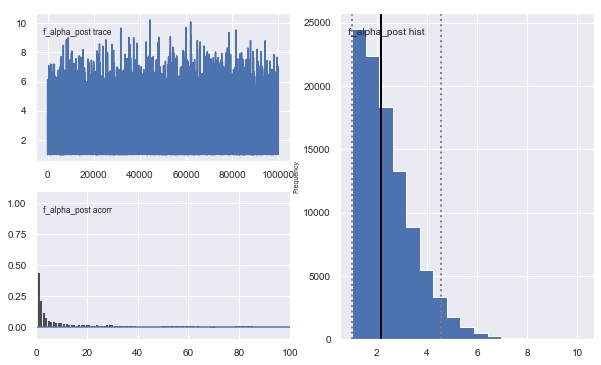

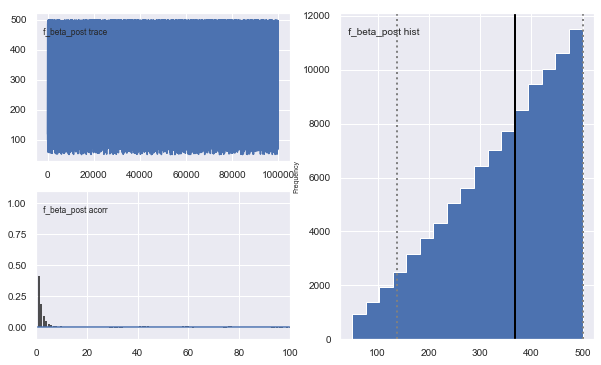

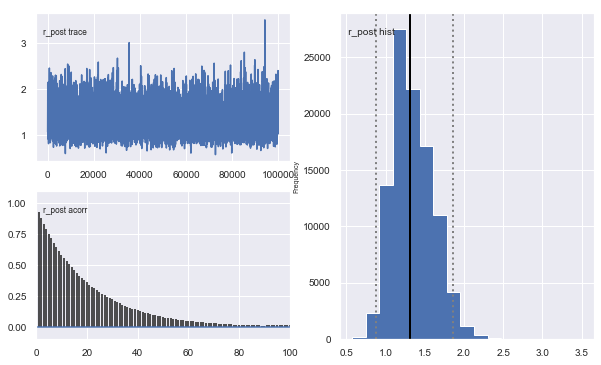

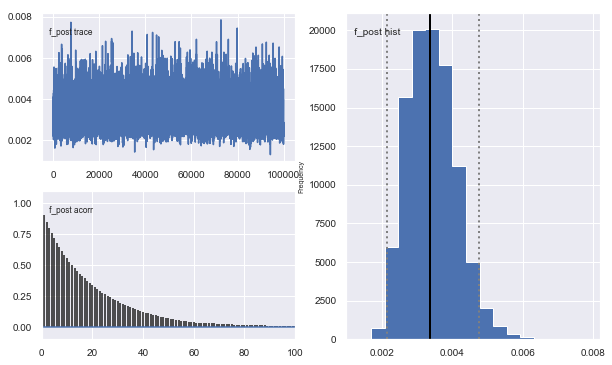

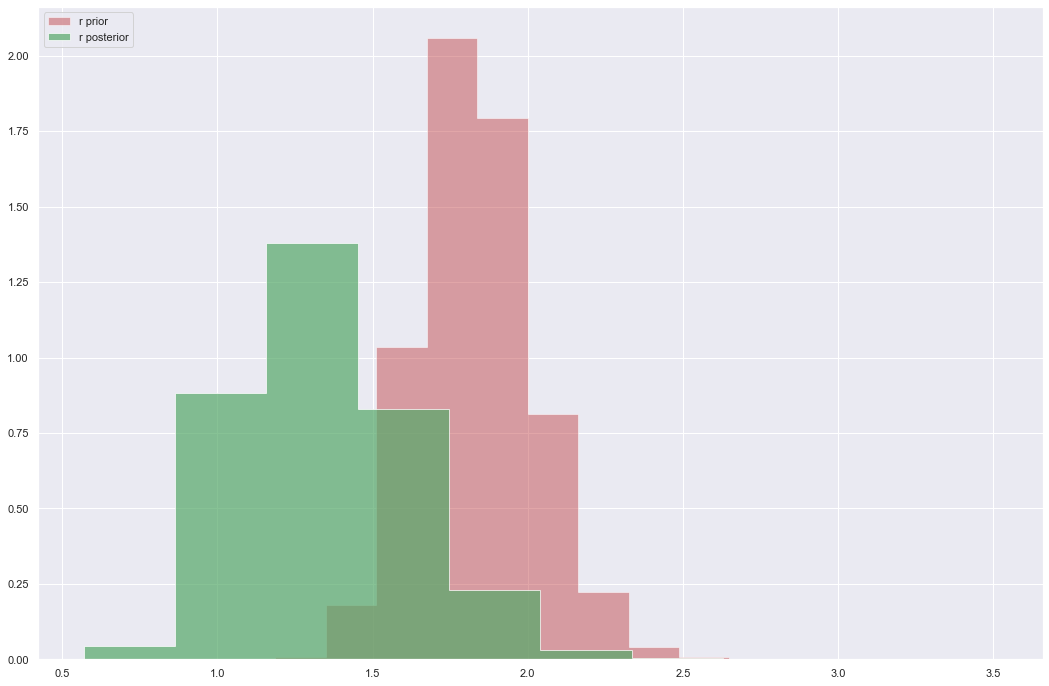

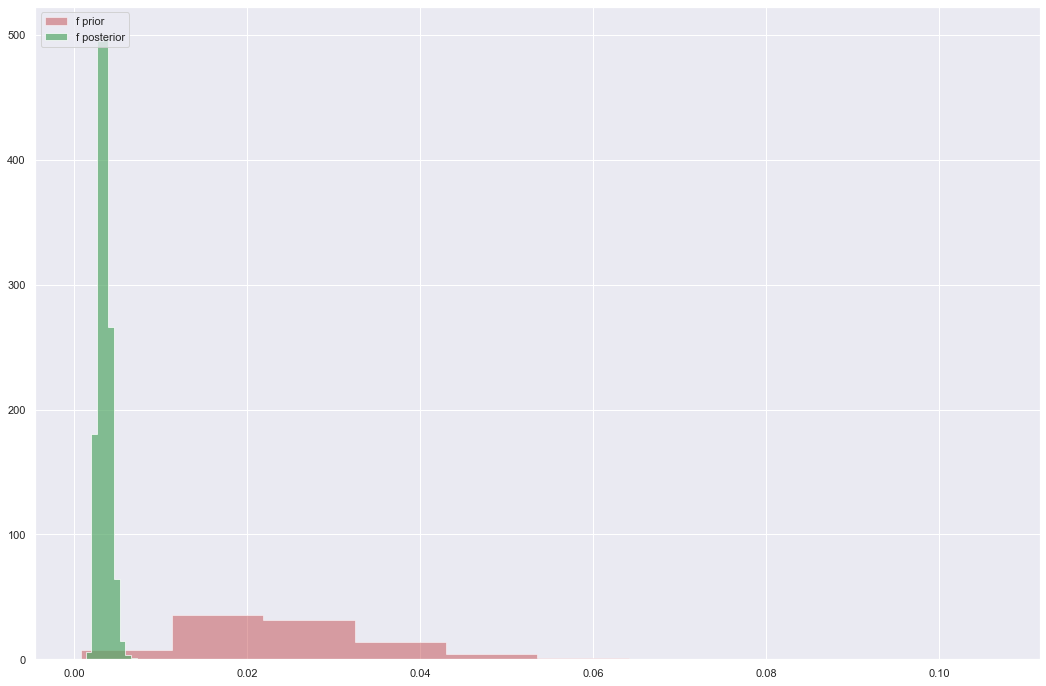

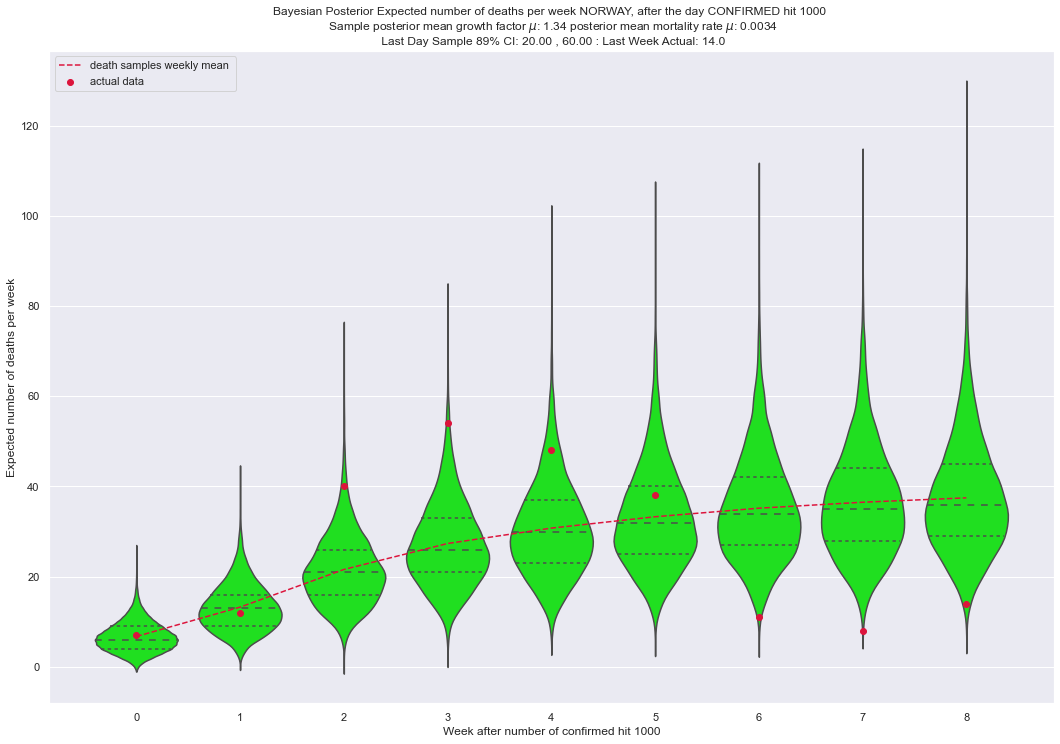

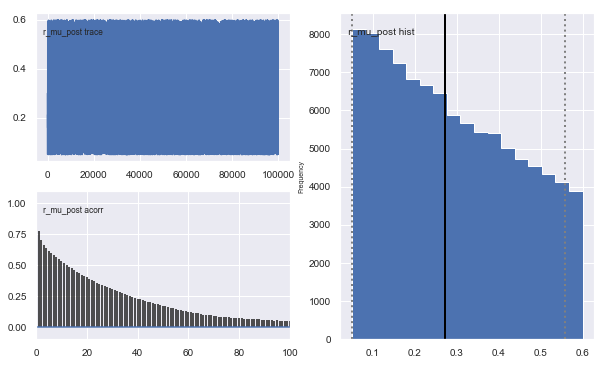

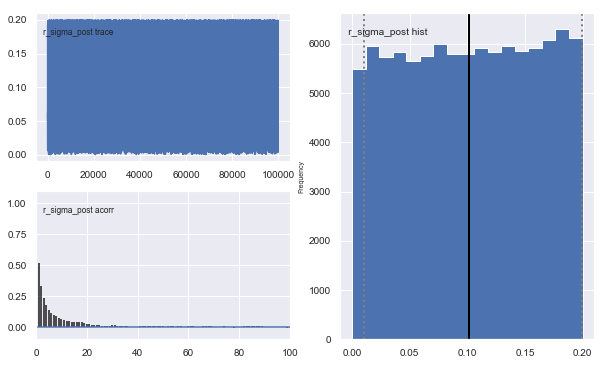

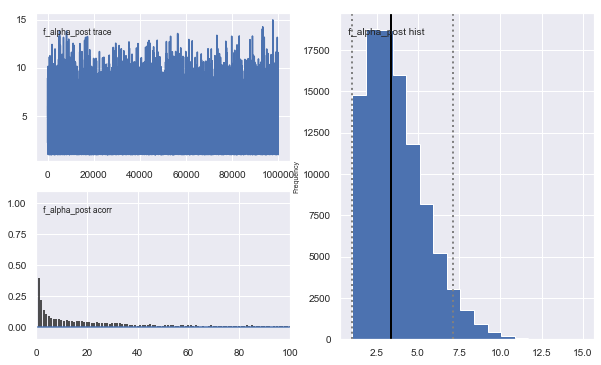

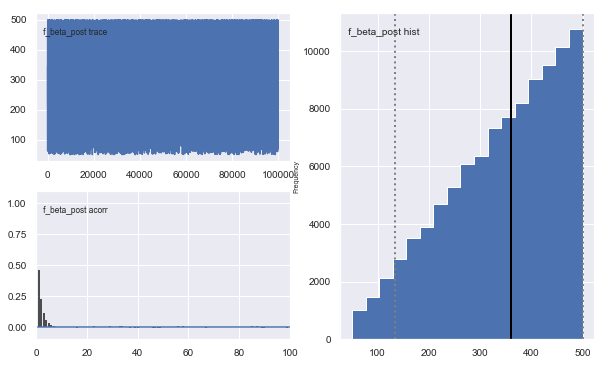

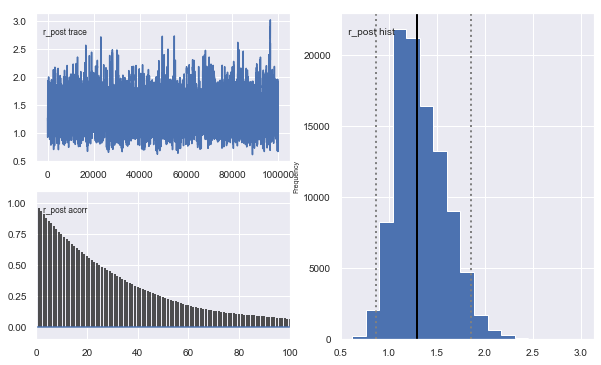

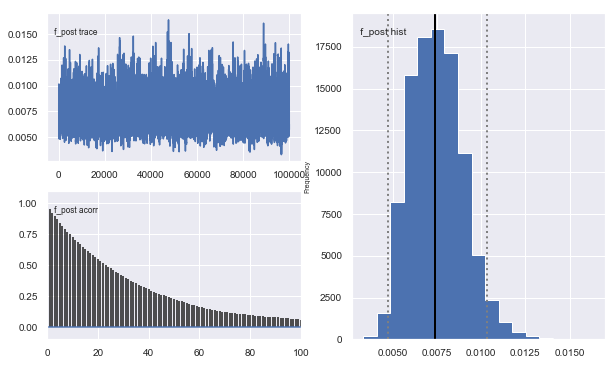

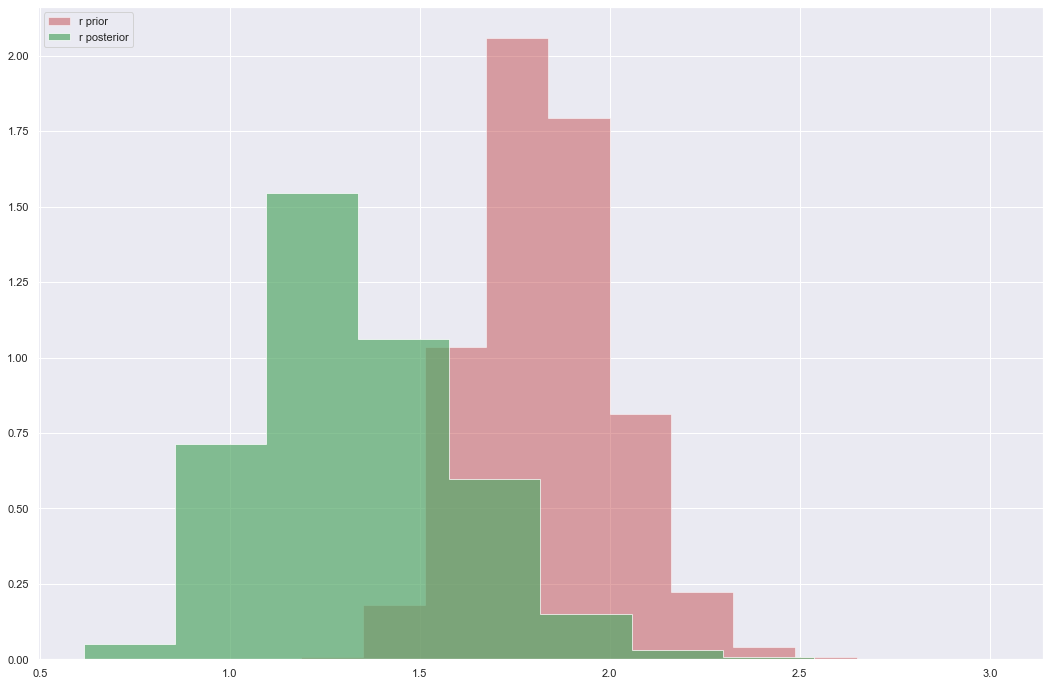

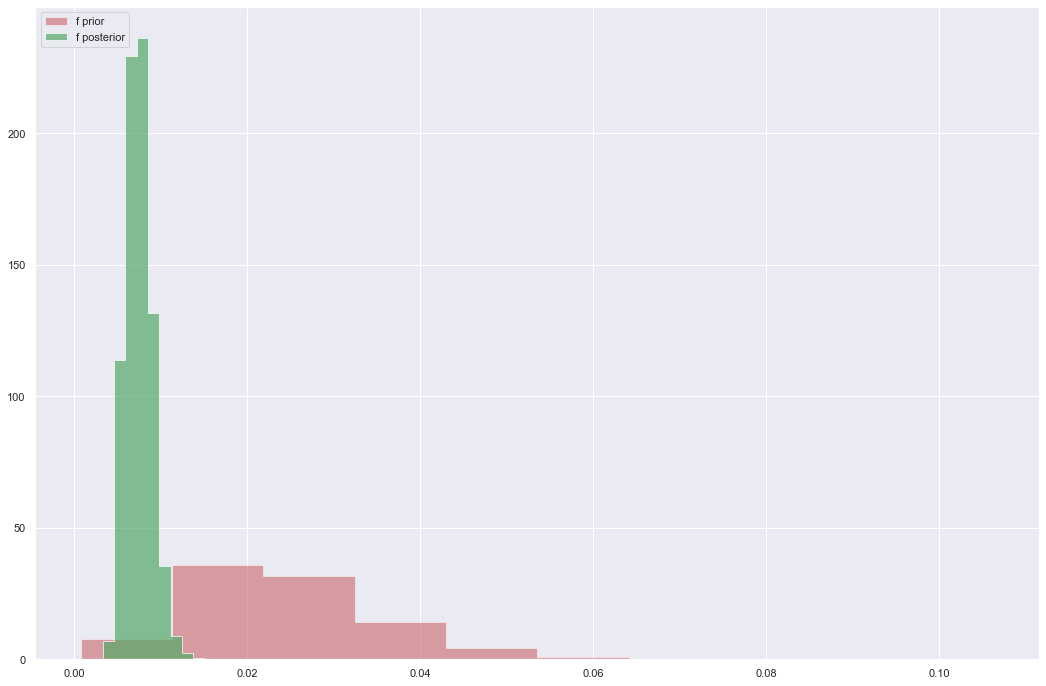

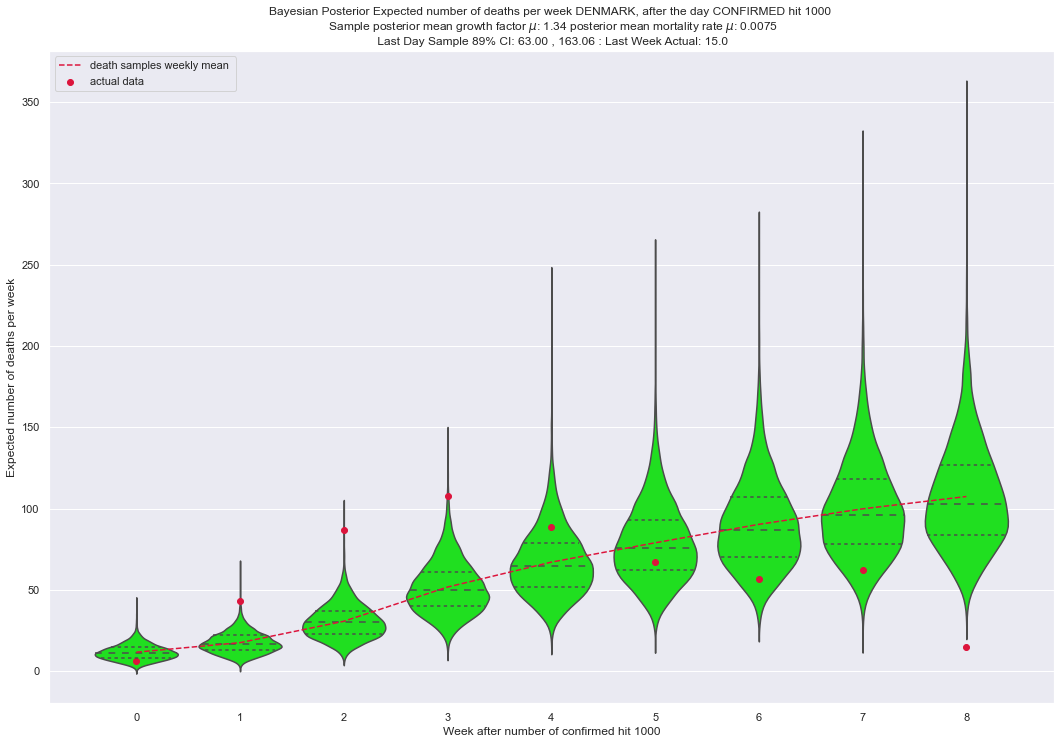

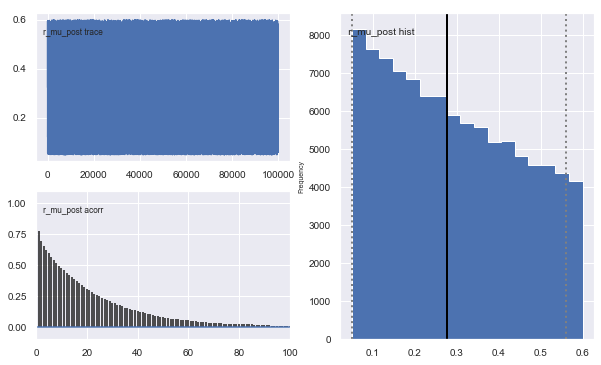

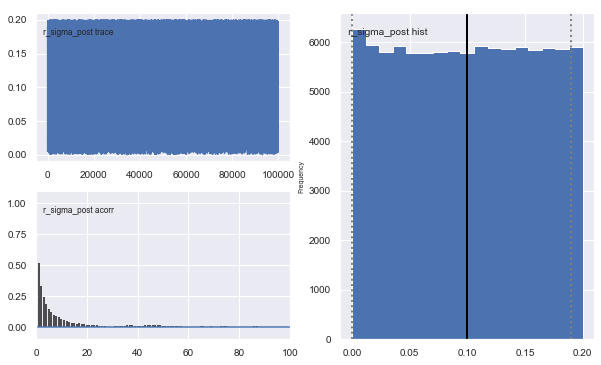

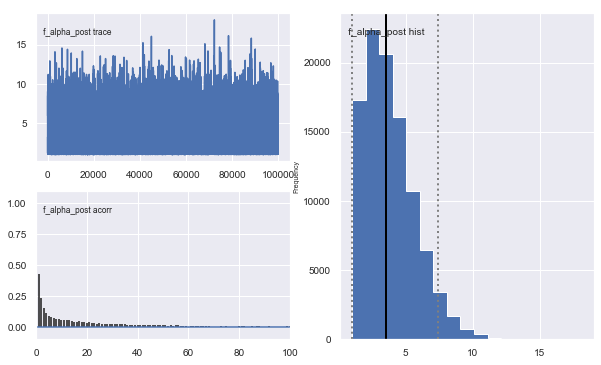

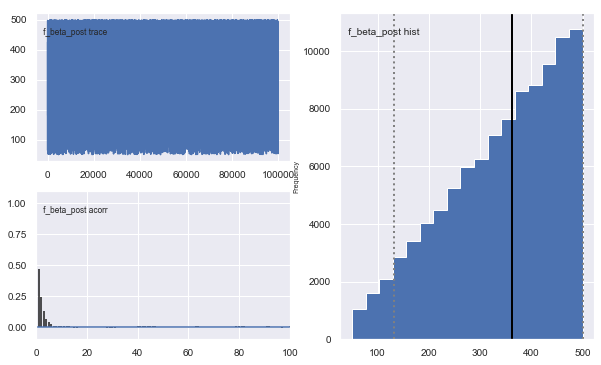

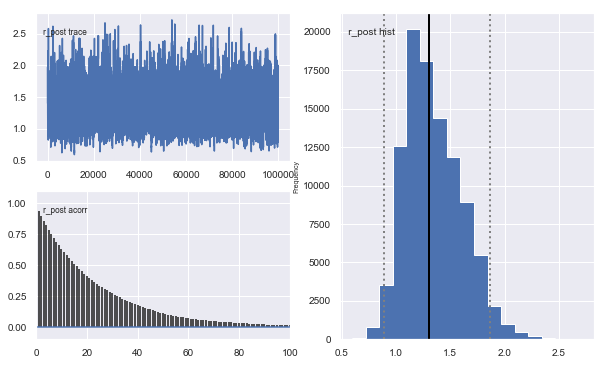

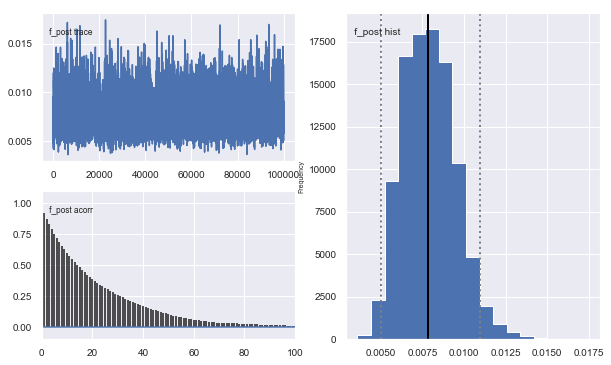

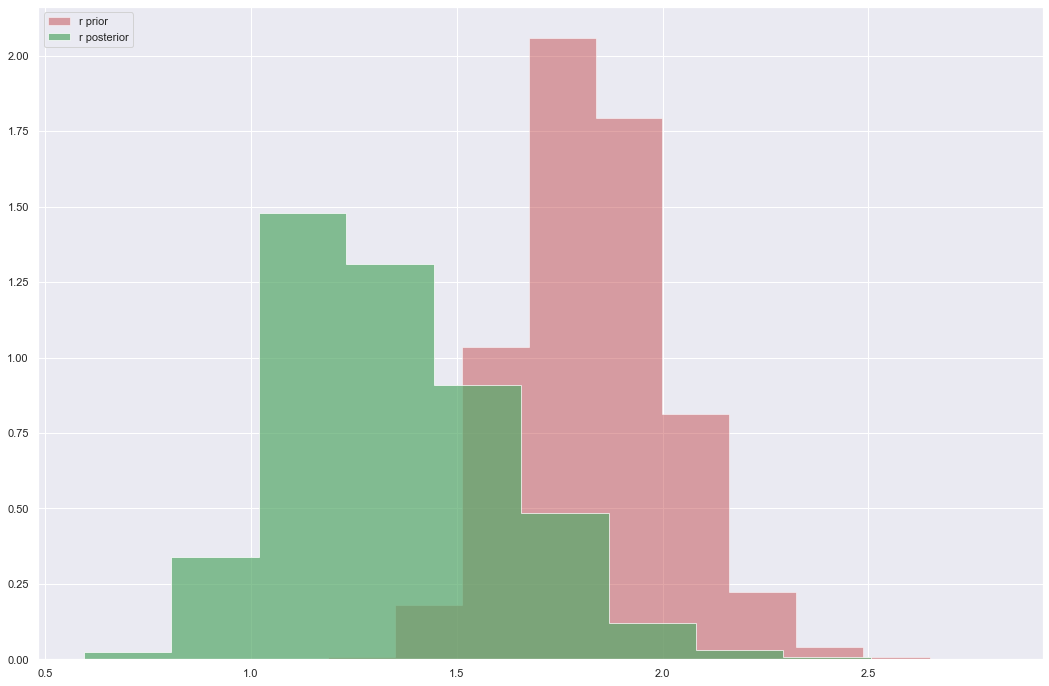

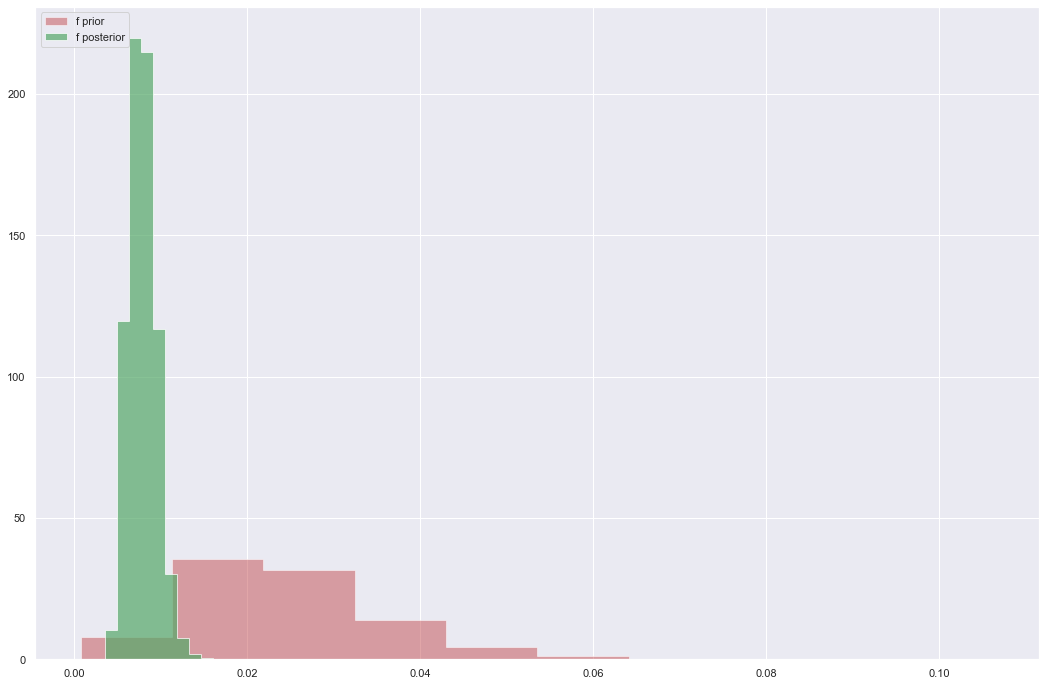

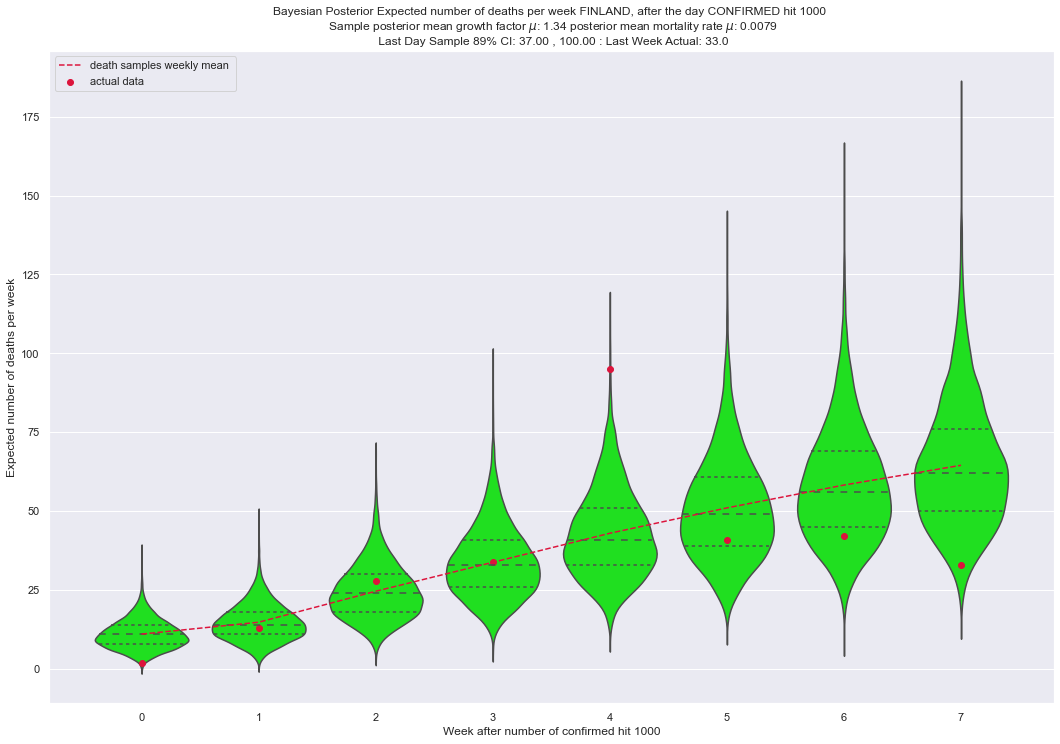

In [7]:
countries = ['Sweden','US','India','Italy','Spain',
             'Korea, South','Netherlands','Canada','Germany','Netherlands',
             'United Kingdom','France','Belgium','Austria','Norway','Denmark','Finland']


#countries = ['Finland','Norway','Denmark','Iceland','Australia','Russia','France','United Kingdom',
            #'Japan','Hong Kong']

#countries = ['India']


for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

    df = df.resample(yesterday(today)).agg({'confirmed' : np.mean,'inc': np.sum,'dead_inc':np.sum,'deceased':np.mean})
    D = df['dead_inc'].resample(yesterday(today)).sum().astype(int)
    C = df['confirmed'].resample(yesterday(today)).mean().astype(int)
    #C = df['inc'].resample(yesterday(today)).mean().astype(int)

    
    print()
    print ('+++++++++++++ {} +++++++++++++'.format(country_name))
    print (df)


    result = inference(df,C,D,country_name)
    sample_df = create_posterior_samples(result)
    #print (sample_df.head(40))
    sample_df.iloc[-1].describe()
    plot(result,df,sample_df,country_name)

In [8]:
US = pd.read_pickle('us_state_dict.pkl')

In [9]:
ny = US['New York']
ny.index = pd.DatetimeIndex(ny.index)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


 [-----------------100%-----------------] 500000 of 500000 complete in 796.0 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ New York ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.385060       0.012516        48.022924
std         0.262863       0.002370         0.286416
min         0.764050       0.007515        46.746157
25%         1.176934       0.010610        47.829899
50%         1.353167       0.012362        48.021337
75%         1.576556       0.014213        48.215680
max         2.222840       0.022001        49.235503



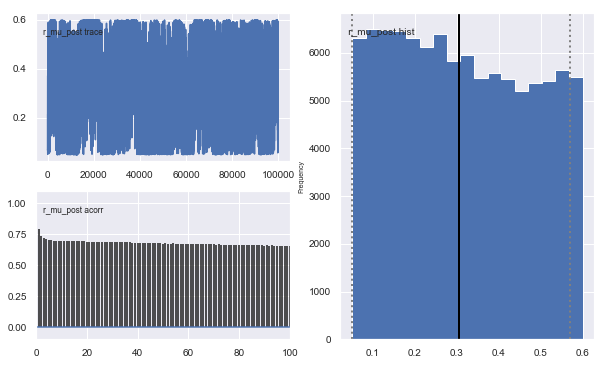

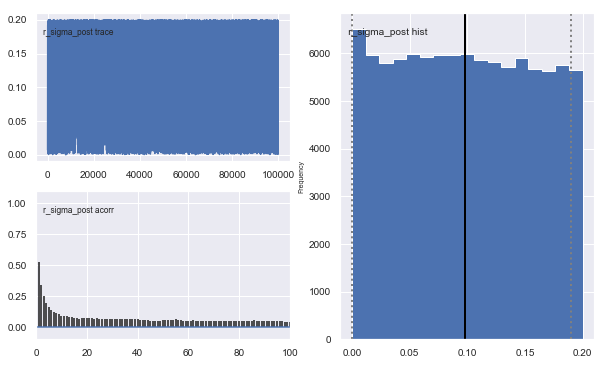

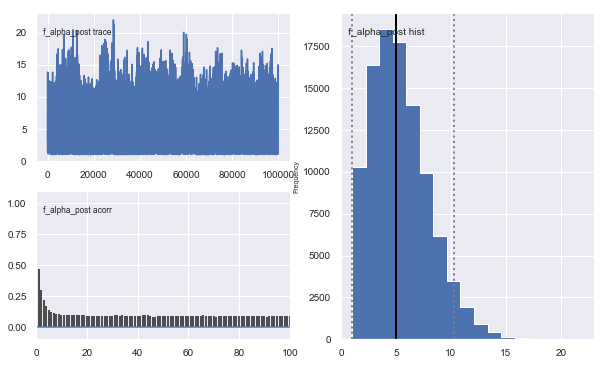

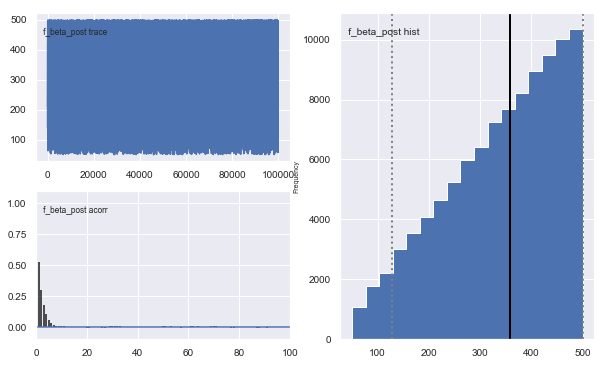

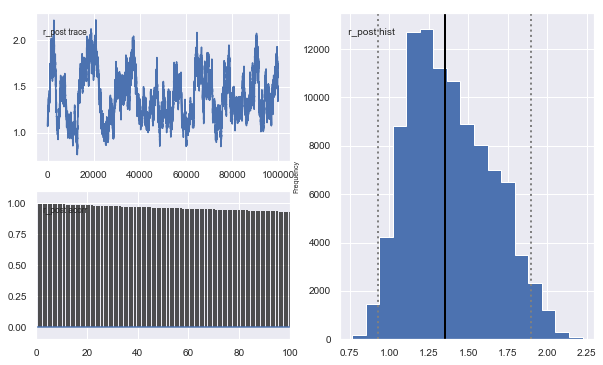

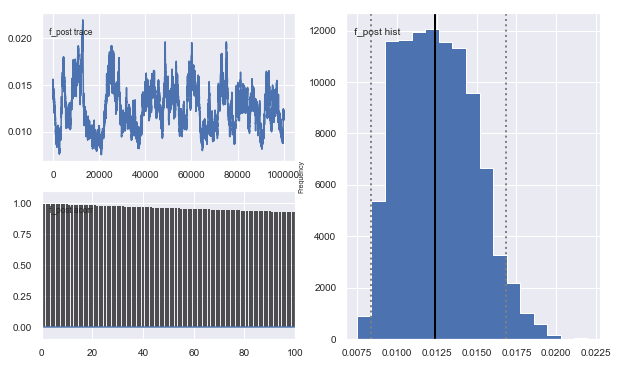

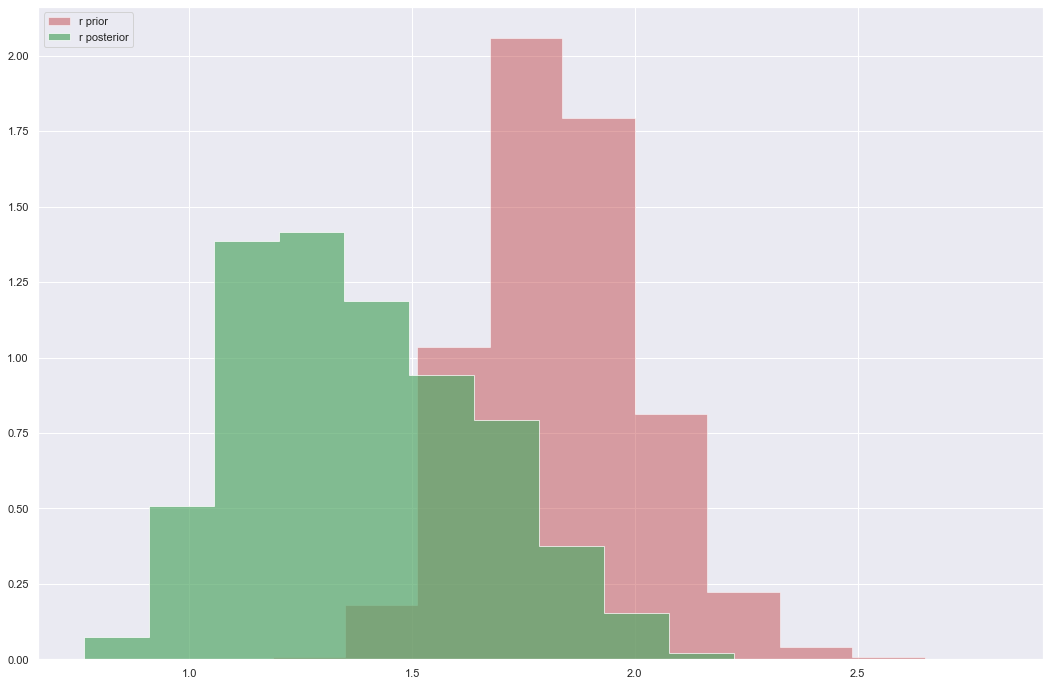

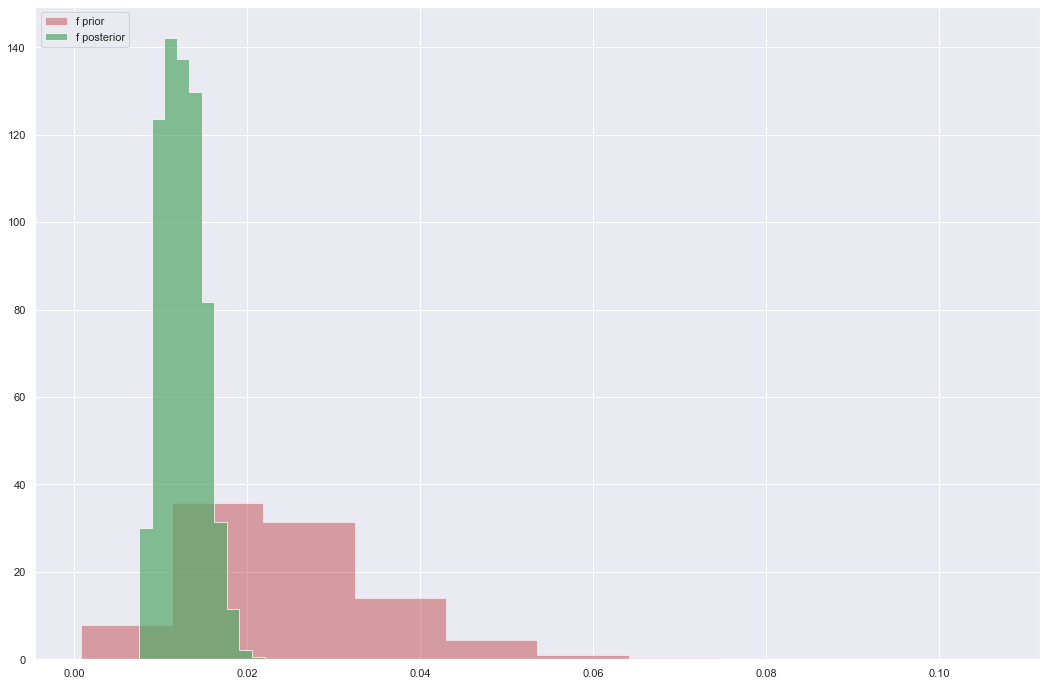

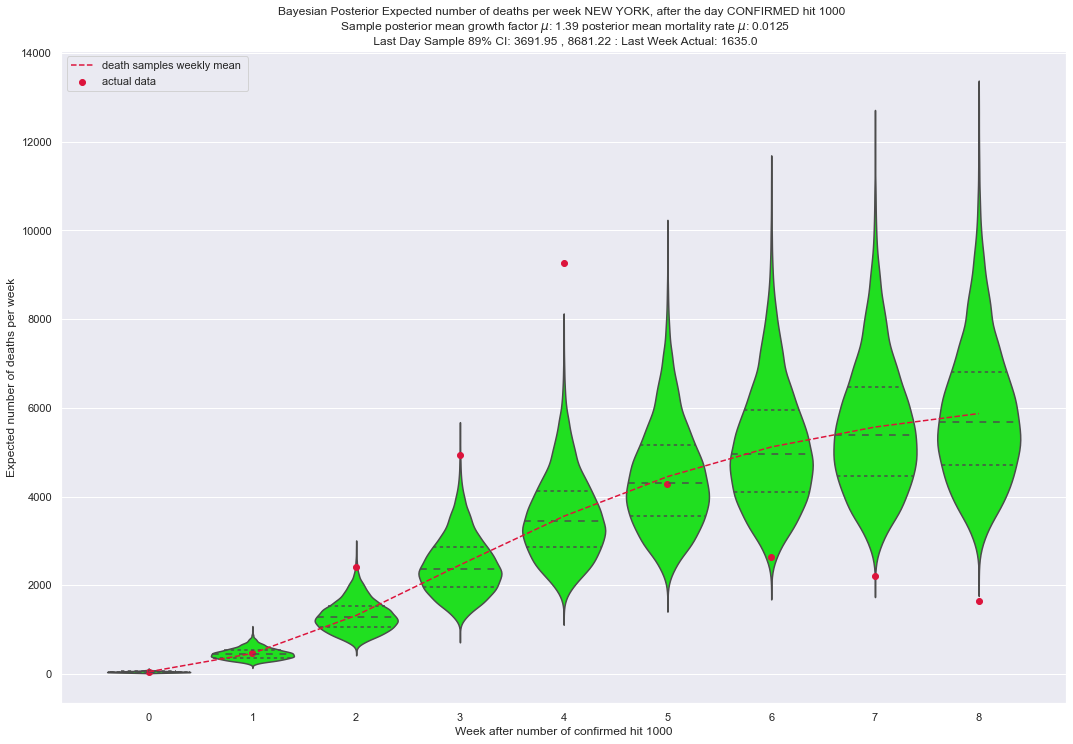

In [10]:
resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

ny = ny.resample(yesterday(today)).agg({'confirmed' : np.mean,'inc':np.sum,'dead_inc':np.sum,'deceased':np.mean})
D = ny['dead_inc'].resample(yesterday(today)).sum().astype(int)
C = ny['confirmed'].resample(yesterday(today)).mean().astype(int)    
#C = ny['inc'].resample(yesterday(today)).mean().astype(int)    

#D = ny['dead_inc']
#C = ny['confirmed']

#print (D)

result = inference(ny,C,D,'New York')
sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')